## EDA: part2

In [2]:
# load library
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
from datetime import datetime
import seaborn as sns
import datetime
from matplotlib.pyplot import MultipleLocator
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import july
from july.utils import date_range
warnings.filterwarnings("ignore")

### Timeline of submission (Understand application cycle)

In [3]:
df = pd.read_excel('./DATA/SLATE.xlsx')
period = ['Fall 2022','Fall 2023','Spring 2022','Spring 2023', 'Summer 2022', 'Summer 2023']
df = df[~df['Entry Term'].isin(period)]
df = df[df['Time Status']=='Full Time']

df = df[~df['Decision 1'].isnull()]
df['Degree']=df['Degree'].replace('Master\'s','MS')
program_dict = {'Electrical and Computer Engineering':'ECE', 'Computer Science':'CS',
       'Data Science':'DS'}
df['Program'] = df['Program (ASE)'].apply(lambda x:program_dict[x])
df['Year'] = df['Entry Term'].apply(lambda x : x[-4::])
df['Degree']=df['Degree'].replace('Master\'s','MS')
df = df[df['Degree']!='Advanced Certificate/Professional' ]
df['Season'] = df['Entry Term'].apply(lambda a :(a.split())[0] )

data=df.groupby(['Program','Degree'],as_index=False)['Ref'].count().reset_index()
data.columns = ['Index','Program', 'Degree',  'Cnt']
data=data.drop(['Index'],axis=1)
data_index=data.set_index(['Program', 'Degree'])['Cnt']

In [ ]:
startDate={'2015': datetime.date(2015, 3, 7),
 '2016': datetime.date(2016, 3, 30),
 '2017': datetime.date(2017, 3, 30),
 '2018': datetime.date(2018, 3, 30),
 '2019': datetime.date(2019, 3, 30),
 '2020': datetime.date(2020, 3, 30),
 '2021': datetime.date(2021, 3, 30)}

In [ ]:
dsFall_df = df[(df['Program']=='DS')&(df['Season']=='Fall')&(df['Degree']=='MS')]
dsFall_df=dsFall_df[~dsFall_df['Submitted'].isnull()]
dsFall_df['Submitted']=dsFall_df['Submitted'].apply(lambda a: pd.Timestamp(a).date())
dsFall_df = dsFall_df[['Submitted','Year']]
dsFall_df=dsFall_df[dsFall_df['Year']>'2015']
dsFall_df['Start'] = dsFall_df['Year'].apply(lambda a: startDate[a])
dsFall_df['Dur'] = dsFall_df.apply(lambda a:(a['Submitted']-a['Start']).days+1,axis=1)
dsFall_df=dsFall_df[dsFall_df['Dur']<0]
dsFall_df['Dur_week'] = dsFall_df['Dur'].apply(lambda a:int(a/7))
dsFall_df=dsFall_df.sort_values(['Year','Submitted'])
dsFall_df['Cnt'] = 1
dsFall_df_temp = dsFall_df.groupby(['Year'])
dsFall_df['Cnt_acu'] = dsFall_df_temp['Cnt'].cumsum()
cntDict = dsFall_df.groupby(['Year']).sum()['Cnt'].to_dict()
dsFall_df['Cnt_all'] = dsFall_df['Year'].apply(lambda a: cntDict[a])
dsFall_df['Cnt_rate'] =dsFall_df.apply(lambda a:(a['Cnt_acu']/a['Cnt_all']),axis=1)

Text(0, 0.5, 'accumulate rate')

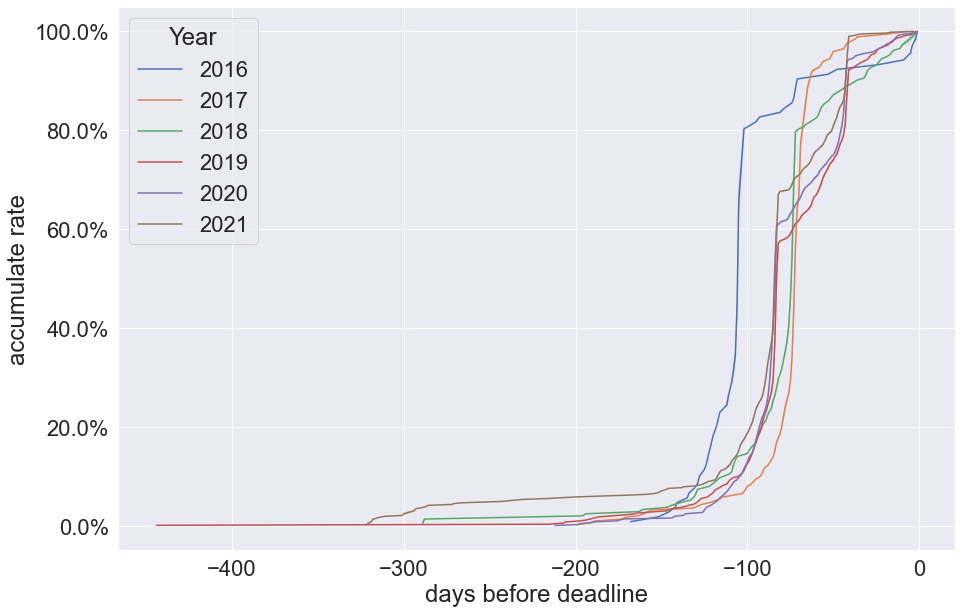

In [ ]:
sns.set(font_scale=2)
fig = plt.figure(figsize=(15,10))
data = dsFall_df[['Dur','Cnt_rate','Year']]
ax=sns.lineplot(data = data,x="Dur",y="Cnt_rate",hue='Year')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))
plt.xlabel("days before deadline")
plt.ylabel("accumulate rate")

Text(0, 0.5, 'accumulate rate')

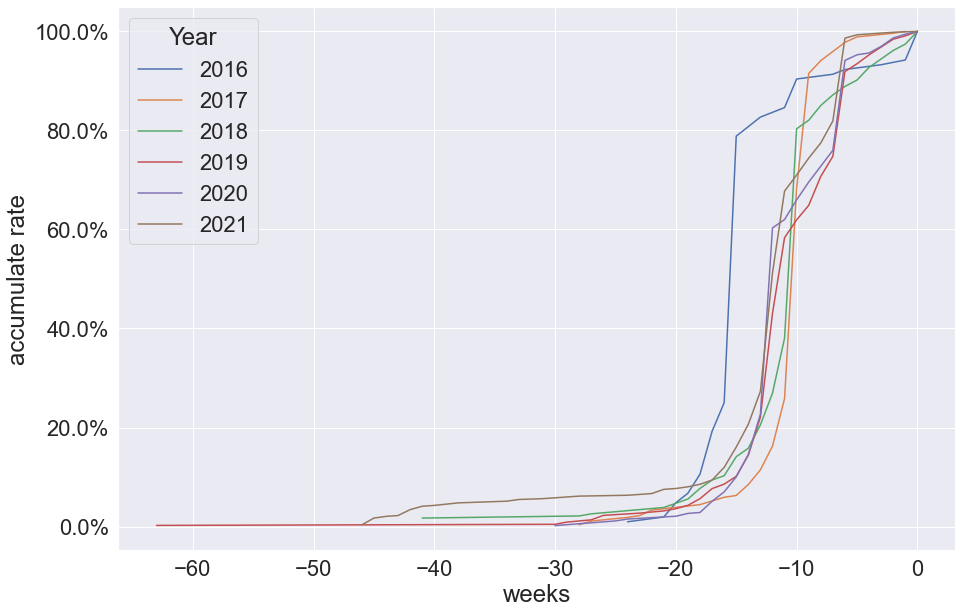

In [ ]:
dsFall_week_df = dsFall_df.groupby(['Year','Dur_week']).sum()['Cnt'].to_frame().reset_index()
dsFall_week_df['Cnt_all'] = dsFall_week_df.Year.apply(lambda a: cntDict[a])
dsFall_df_temp = dsFall_week_df.groupby(['Year'])
dsFall_week_df['Cnt_acu'] = dsFall_df_temp['Cnt'].cumsum()
dsFall_week_df['Cnt_rate'] =dsFall_week_df.apply(lambda a:(a['Cnt_acu']/a['Cnt_all']),axis=1)
fig = plt.figure(figsize=(15,10))
data = dsFall_week_df[['Dur_week','Cnt_rate','Year']]
ax=sns.lineplot(data = data,x="Dur_week",y="Cnt_rate",hue='Year')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=1))
plt.xlabel("weeks")
plt.ylabel("accumulate rate")

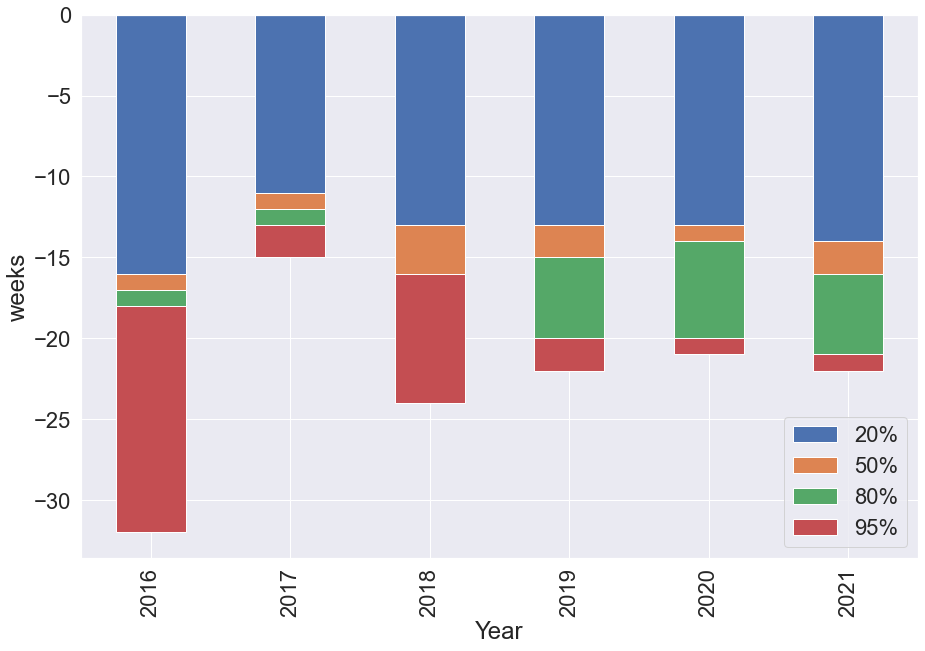

In [ ]:
p_20=dsFall_df[dsFall_df['Cnt_rate']>=0.2].groupby('Year').min()['Dur_week'].to_frame()
p_50=dsFall_df[dsFall_df['Cnt_rate']>=0.5].groupby('Year').min()['Dur_week'].to_frame()
p_80=dsFall_df[dsFall_df['Cnt_rate']>=0.8].groupby('Year').min()['Dur_week'].to_frame()
p_95=dsFall_df[dsFall_df['Cnt_rate']>=0.95].groupby('Year').min()['Dur_week'].to_frame()
data=pd.concat([p_20,p_50,p_80,p_95],axis=1) 
data.columns=['Dur_week_20', 'Dur_week_50', 'Dur_week_80', 'Dur_week_95']
data['Dur_week_95'] = data.apply(lambda a : a['Dur_week_80']-a['Dur_week_95'],axis=1)
data['Dur_week_80'] = data.apply(lambda a : a['Dur_week_50']-a['Dur_week_80'],axis=1)
data['Dur_week_50'] = data.apply(lambda a : a['Dur_week_20']-a['Dur_week_50'],axis=1)
data.columns=['20%', '50%', '80%','95%']
ax=data.plot(kind='bar', stacked= True,figsize=(15,10),ylabel = 'weeks',)

### When do applicants submit applications?

In [ ]:
df = pd.read_excel('./DATA/SLATE.xlsx')
# select full time + master
df = df[df['Degree']=='Master\'s']
df = df[df['Time Status']=='Full Time']
period = ['Fall 2022','Fall 2023','Spring 2022','Spring 2023', 'Summer 2022', 'Summer 2023']
df_temp = df[~df['Entry Term'].isin(period)]

In [ ]:
# create features of date time stamps-split into year, month, day of the month, hour
df['created_year'] = df['Created'].dt.year
#df
# create features of date time stamps-split into year, month, day of the month, hour
df['created_month'] = df['Created'].dt.month
#df

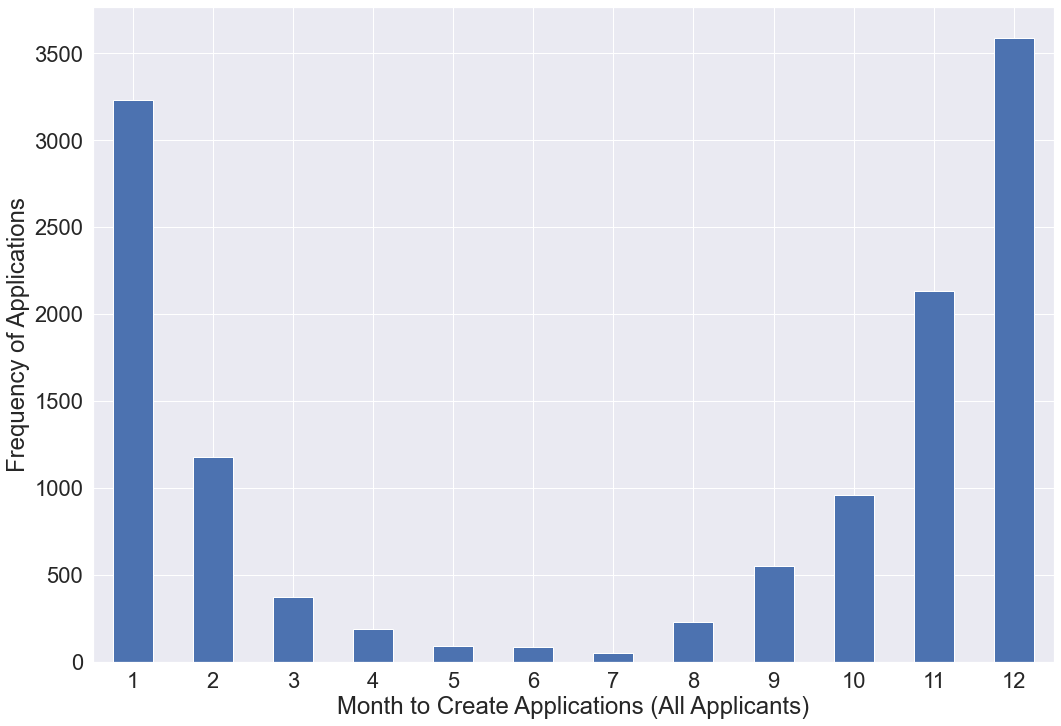

In [ ]:
# create month distribution for all applicants

fig, ax = plt.subplots(1, figsize=(15,10))
plt.sca(ax)
df['Created'].groupby(df['created_month']).count().plot(kind='bar')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Month to Create Applications (All Applicants)')
ax.set_ylabel('Frequency of Applications')
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)
# reference: https://sites.google.com/view/paztronomer/blog/advanced/dates-histogram

In [ ]:
# create features of date time stamps-split into year, month, day of the month, hour
df['created_day'] = df['Created'].dt.day
#df

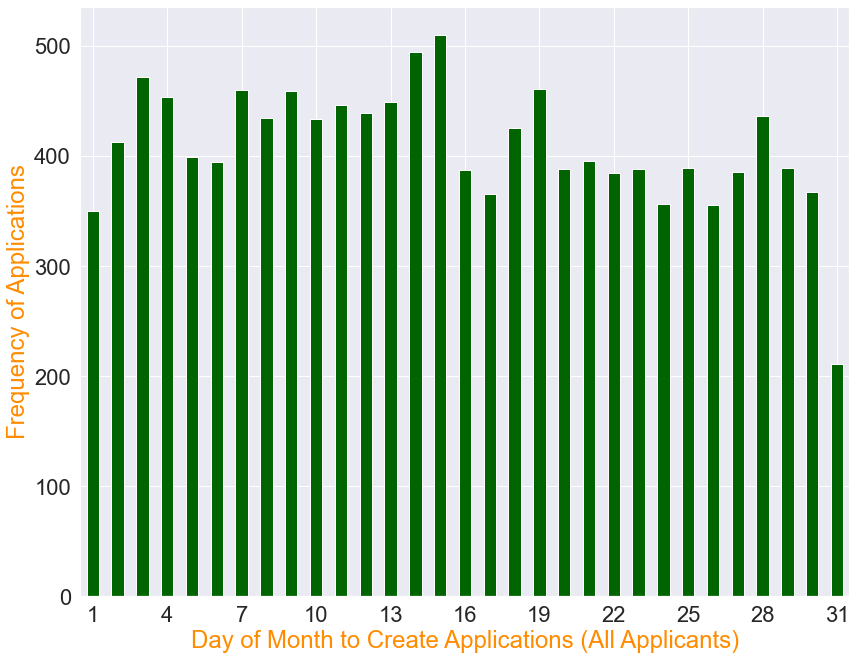

In [ ]:
# create day of month distribution for all applicants

fig, ax = plt.subplots(1, figsize=(12,9))
plt.sca(ax)
df['Created'].groupby(df['created_day']).count().plot(kind='bar', color='darkgreen')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Day of Month to Create Applications (All Applicants)', color='darkorange')
ax.set_ylabel('Frequency of Applications', color='darkorange')
x_major_locator=MultipleLocator(3)
ax.xaxis.set_major_locator(x_major_locator)
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)
# reference: https://sites.google.com/view/paztronomer/blog/advanced/dates-histogram

In [ ]:
# create features of date time stamps-split into year, month, day of the month, hour
df['created_hour'] = df['Created'].dt.hour
# create feature of week number of the year
df['created_week'] = df['Created'].dt.week

In [ ]:
# create feature: day of the week 
df['created_dayofweek'] = df['Created'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
#df
# add one to each variable 
df['created_dayofweek'] = df['created_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.
#df

Text(0, 0.5, 'Day of Week')

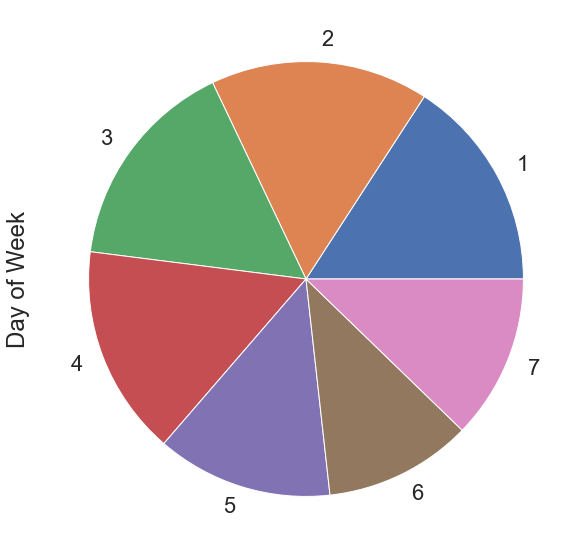

In [ ]:
# plot pie chart for day of week
fig, ax = plt.subplots(1,figsize=(10,10))
plt.sca(ax)
df['Created'].groupby(df['created_dayofweek']).count().plot(kind='pie')
ax.set_ylabel('Day of Week')

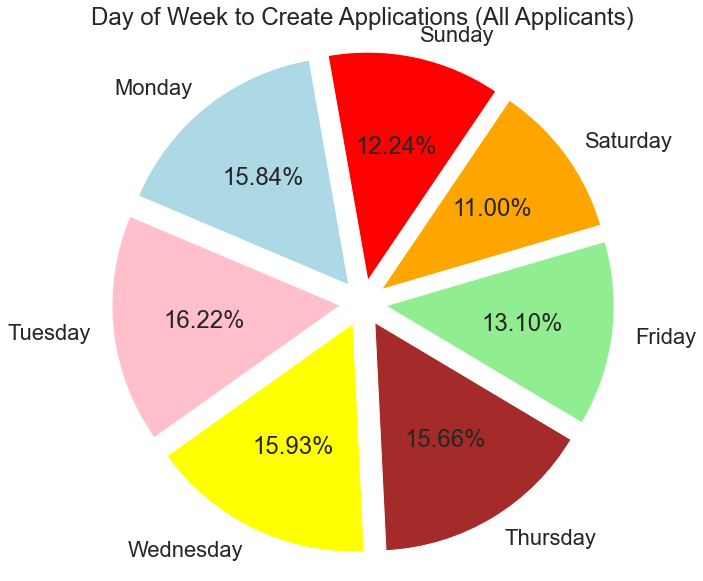

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']

sizes= [2010, 2058, 2021, 1987,1662,1395, 1553]
fig, ax = plt.subplots(1,figsize=(10,10))
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')

plt.title('Day of Week to Create Applications (All Applicants)')

plt.axis('equal')

plt.show()

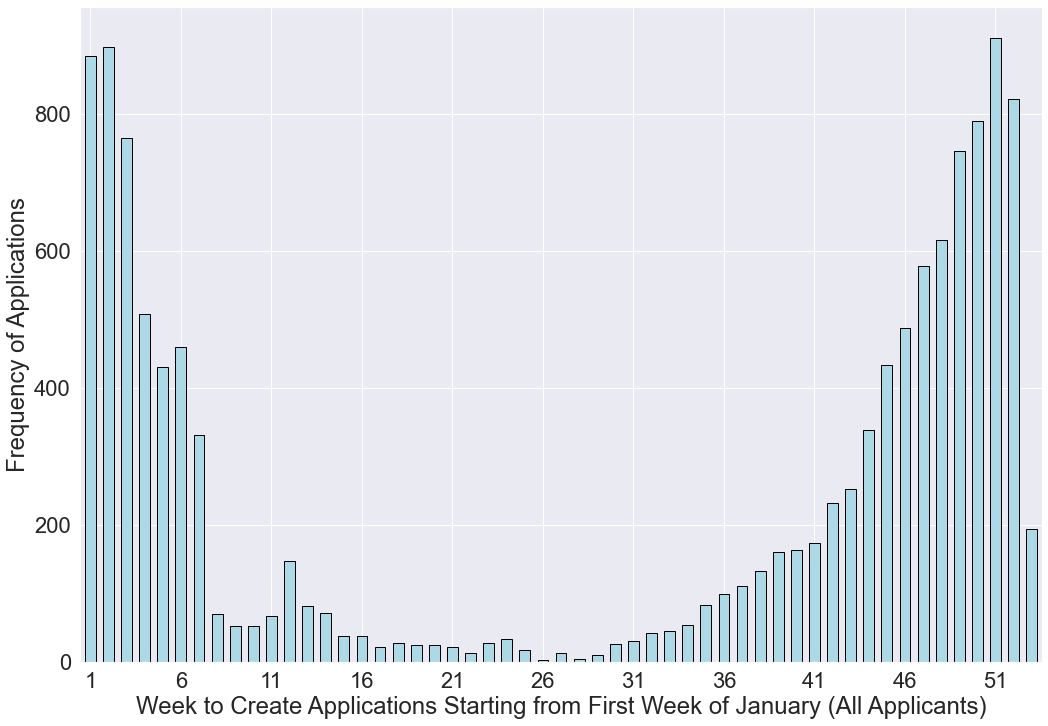

In [ ]:
# create week distribution for all applicants

fig, ax = plt.subplots(1,figsize=(15,10))

plt.sca(ax)
#df['academic_week'] = df['created_week'].apply(lambda a: ((a+21)%53)+1) # start from week 32
df['Created'].groupby(df['created_week']).count().plot(kind='bar', color='lightblue', width=0.6, edgecolor='black')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Week to Create Applications Starting from First Week of January (All Applicants)')
ax.set_ylabel('Frequency of Applications')
x_major_locator=MultipleLocator(5)
ax.xaxis.set_major_locator(x_major_locator)
plt.subplots_adjust(hspace=0.2, wspace=0.2, left=0.1, bottom=0.08, top=0.99, right=0.99)
# reference: https://sites.google.com/view/paztronomer/blog/advanced/dates-histogram

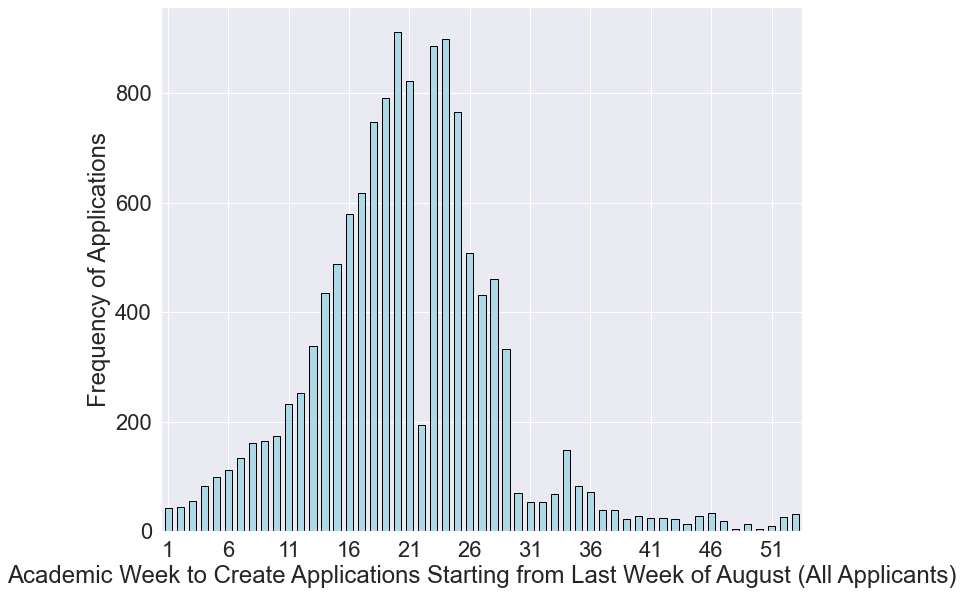

In [ ]:
# create week distribution for all applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(10, 8))
plt.sca(ax)
df['academic_week'] = df['created_week'].apply(lambda a: ((a+21)%53)+1) # start from week 32
df['Created'].groupby(df['academic_week']).count().plot(kind='bar', color='lightblue', width=0.6, edgecolor='black')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Academic Week to Create Applications Starting from Last Week of August (All Applicants)')
ax.set_ylabel('Frequency of Applications')
x_major_locator=MultipleLocator(5)
ax.xaxis.set_major_locator(x_major_locator)
plt.subplots_adjust(hspace=0.2, wspace=0.2, left=0.1, bottom=0.08, top=0.99, right=0.99)

# reference: https://sites.google.com/view/paztronomer/blog/advanced/dates-histogram

Text(0, 0.5, 'Frequency of Applications')

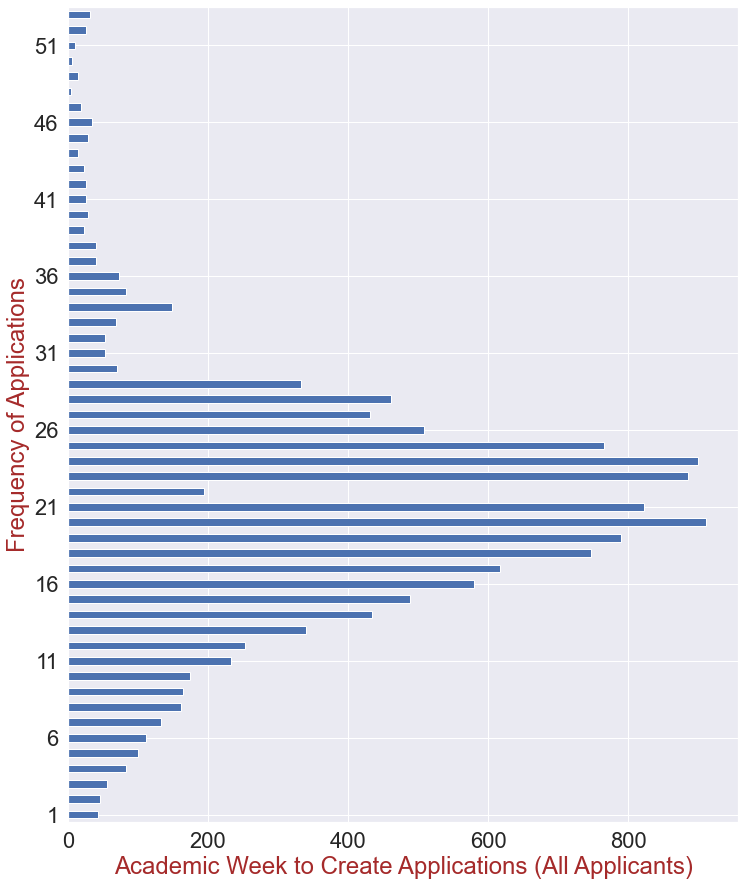

In [ ]:
# 3) By week of the month
fig,ax = plt.subplots(1, figsize=(12, 15))
plt.sca(ax)
df['Created'].groupby(df['academic_week']).count().plot(kind='barh')
y_major_locator=MultipleLocator(5)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Academic Week to Create Applications (All Applicants)', color='brown')
ax.set_ylabel('Frequency of Applications', color='brown')

In [ ]:
# Comparision across three top countries: create dataframe for each country
#print(df['Birth Country'])
df_china = df[df['Birth Country']=='China']
#print(df_china)
df_india = df[df['Birth Country']=='India']
#print(df_eceprogram)
df_us = df[df['Birth Country']=='United States']
#print(df_us)

In [ ]:
# create feature: day of the week 
df_china['created_dayofweek'] = df_china['Created'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
#df_china
# add one to each variable 
df_china['created_dayofweek'] = df_china['created_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.
#df_china

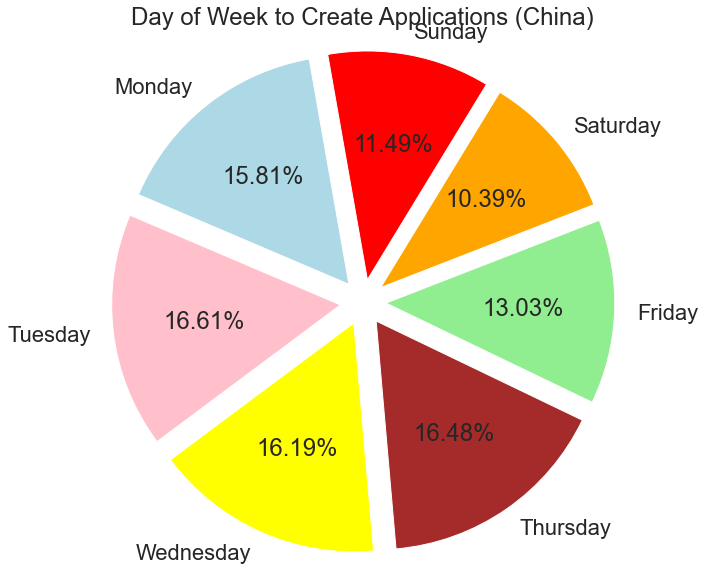

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [1128, 1185, 1155, 1176,930,741,820]
fig, ax = plt.subplots(1,figsize=(10,10))
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Day of Week to Create Applications (China)')
plt.axis('equal')
plt.show()

In [ ]:
# create feature: day of the week 
df_india['created_dayofweek'] = df_india['Created'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
df_india
# add one to each variable 
df_india['created_dayofweek'] = df_india['created_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

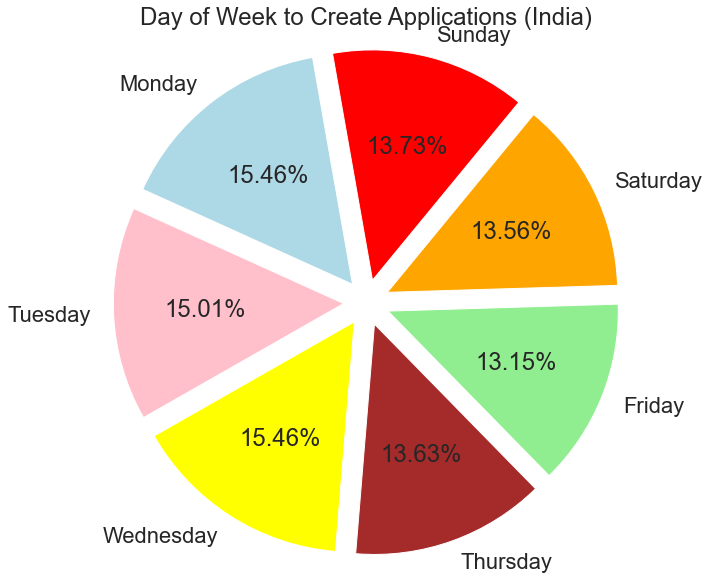

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [449, 436, 449, 396,382,394,399]
fig, ax = plt.subplots(1,figsize=(10,10))
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Day of Week to Create Applications (India)')
plt.axis('equal')
plt.show()

In [ ]:
# create feature: day of the week 
df_us['created_dayofweek'] = df_us['Created'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
df_us
# add one to each variable 
df_us['created_dayofweek'] = df_us['created_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

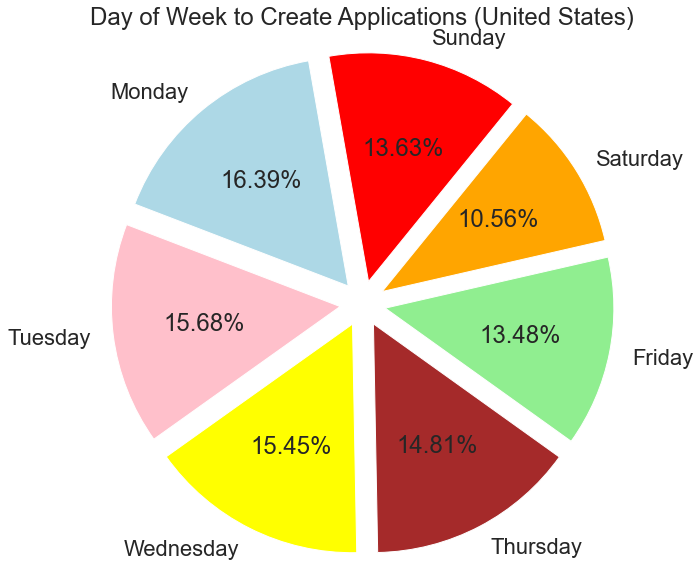

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [208, 199, 196, 188,171,134,173]
fig, ax = plt.subplots(1,figsize=(10,10))
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Day of Week to Create Applications (United States)')
plt.axis('equal')
plt.show()

In [ ]:
# Comparision between two genders in the variable of Sex
df_male = df[df['Sex']=='M']
df_female = df[df['Sex']=='F']

In [ ]:
# gender difference
## for male
df_male['created_month'] = df_male['Created'].dt.month

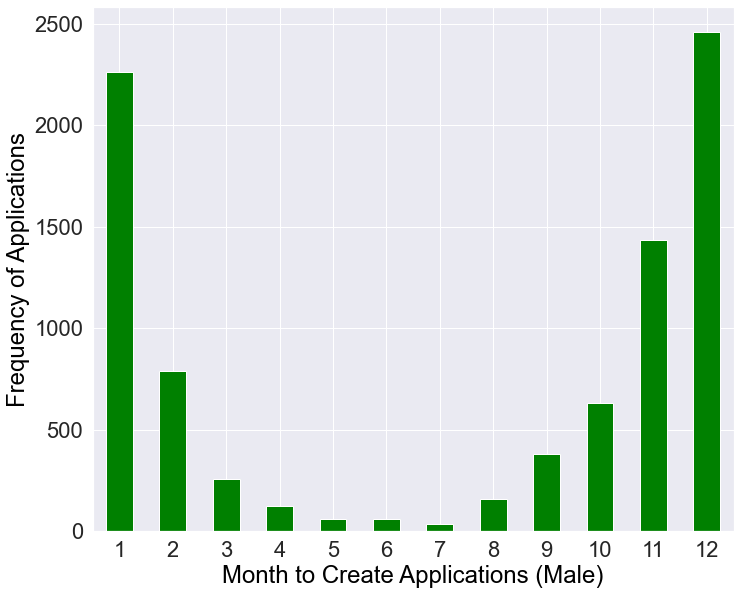

In [ ]:
# create month distribution for male applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.sca(ax)
df_male['Created'].groupby(df_male['created_month']).count().plot(kind='bar',color='green')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Month to Create Applications (Male)', color='black')
ax.set_ylabel('Frequency of Applications', color='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
# gender difference
## for female
df_female['created_month'] = df_female['Created'].dt.month

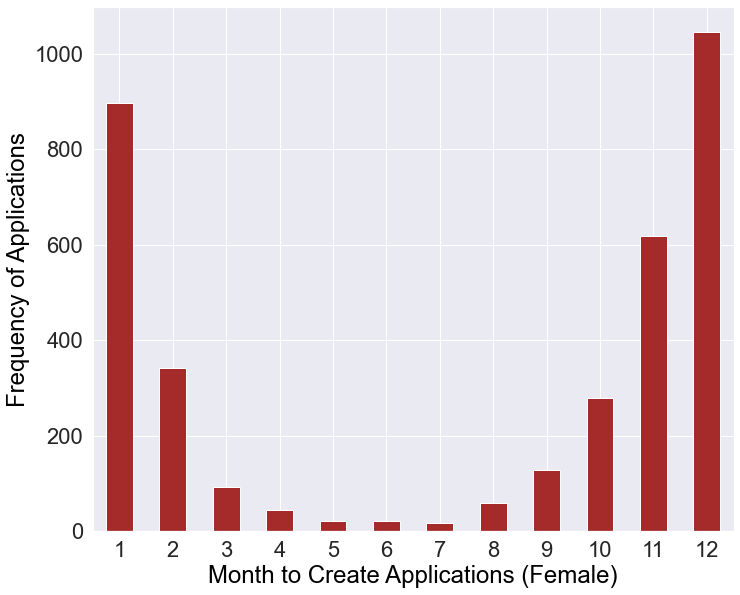

In [ ]:
# create month distribution for female applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.sca(ax)
df_female['Created'].groupby(df_female['created_month']).count().plot(kind='bar',color='brown')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Month to Create Applications (Female)', color='black')
ax.set_ylabel('Frequency of Applications', color='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
# Comparision across three age groups: [0~25),[25~30),[30, 65)
df['Age at App Submission'].describe()
bins= [0,25,30,65]
labels = ['Age under 25','Age between 25 and 29','Age above or equal to 30']
df['Agegroup'] = pd.cut(df['Age at App Submission'], bins=bins, labels=labels, right=False)
df_ageunder25 = df[df['Agegroup']=='Age under 25']
df_age25to29 = df[df['Agegroup']=='Age between 25 and 29']
df_ageabove30 = df[df['Agegroup']=='Age above or equal to 30']

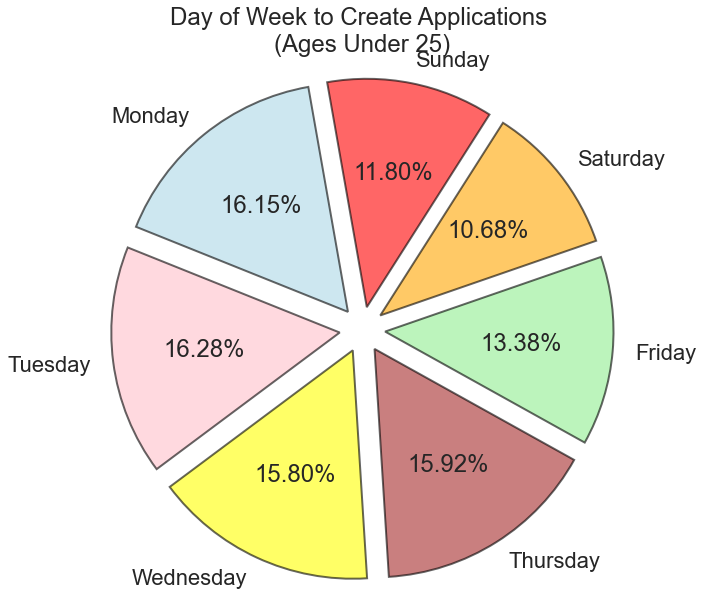

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
#colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [1375, 1386, 1345, 1356,1139,909,1005]
fig, ax = plt.subplots(1,figsize=(10,10))
n = plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
    n[0][i].set_alpha(alpha)
    
plt.title('Day of Week to Create Applications \n(Ages Under 25)')
plt.axis('equal')
plt.show()

<Figure size 600x400 with 0 Axes>

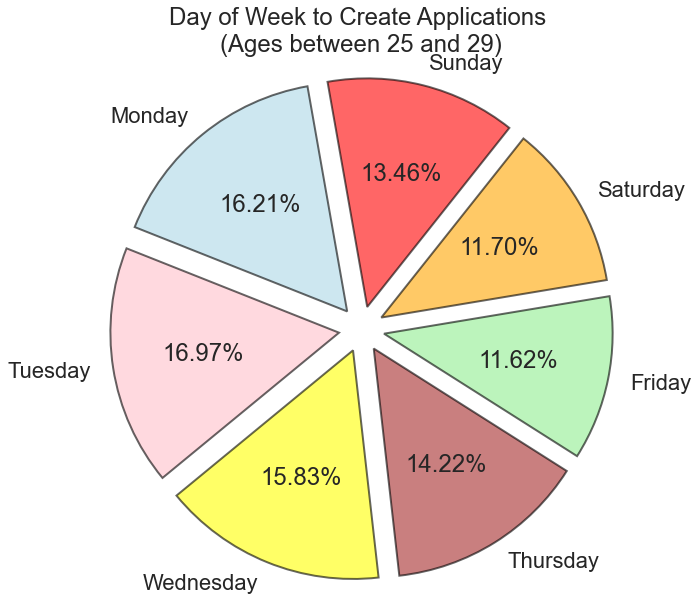

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
plt.figure(dpi=100)
sizes= [212, 222, 207, 186,152,153,176]
fig, ax = plt.subplots(1,figsize=(10,10))
n = plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
    n[0][i].set_alpha(alpha)
plt.title('Day of Week to Create Applications \n(Ages between 25 and 29)')
plt.axis('equal')
plt.show()

<Figure size 600x400 with 0 Axes>

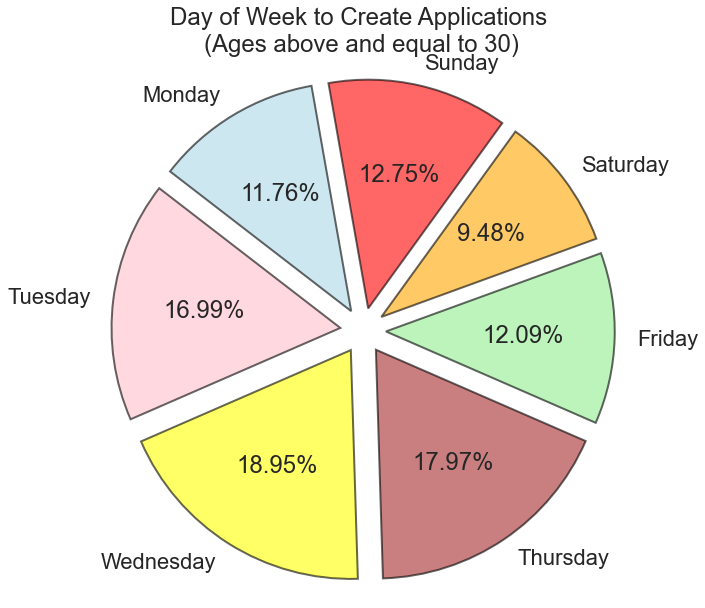

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
plt.figure(dpi=100)
sizes= [36, 52, 58, 55,37,29,39]
fig, ax = plt.subplots(1,figsize=(10,10))
n = plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
  n[0][i].set_alpha(alpha)
plt.title('Day of Week to Create Applications \n(Ages above and equal to 30)')
plt.axis('equal')
plt.show()

In [ ]:
from datetime import datetime
df = df_temp
year = [datetime.strptime(term[-4:], '%Y') for term in df["Entry Term"]]
df["Year"] = year
season = [term[:-5] for term in df["Entry Term"]]
df["Season"] = season
relative_created = df.Created - df.Year
day = [time.days for time in relative_created]
df["relative_created"] = day
year = [term[-4:] for term in df["Entry Term"]]
df["Year"] = year

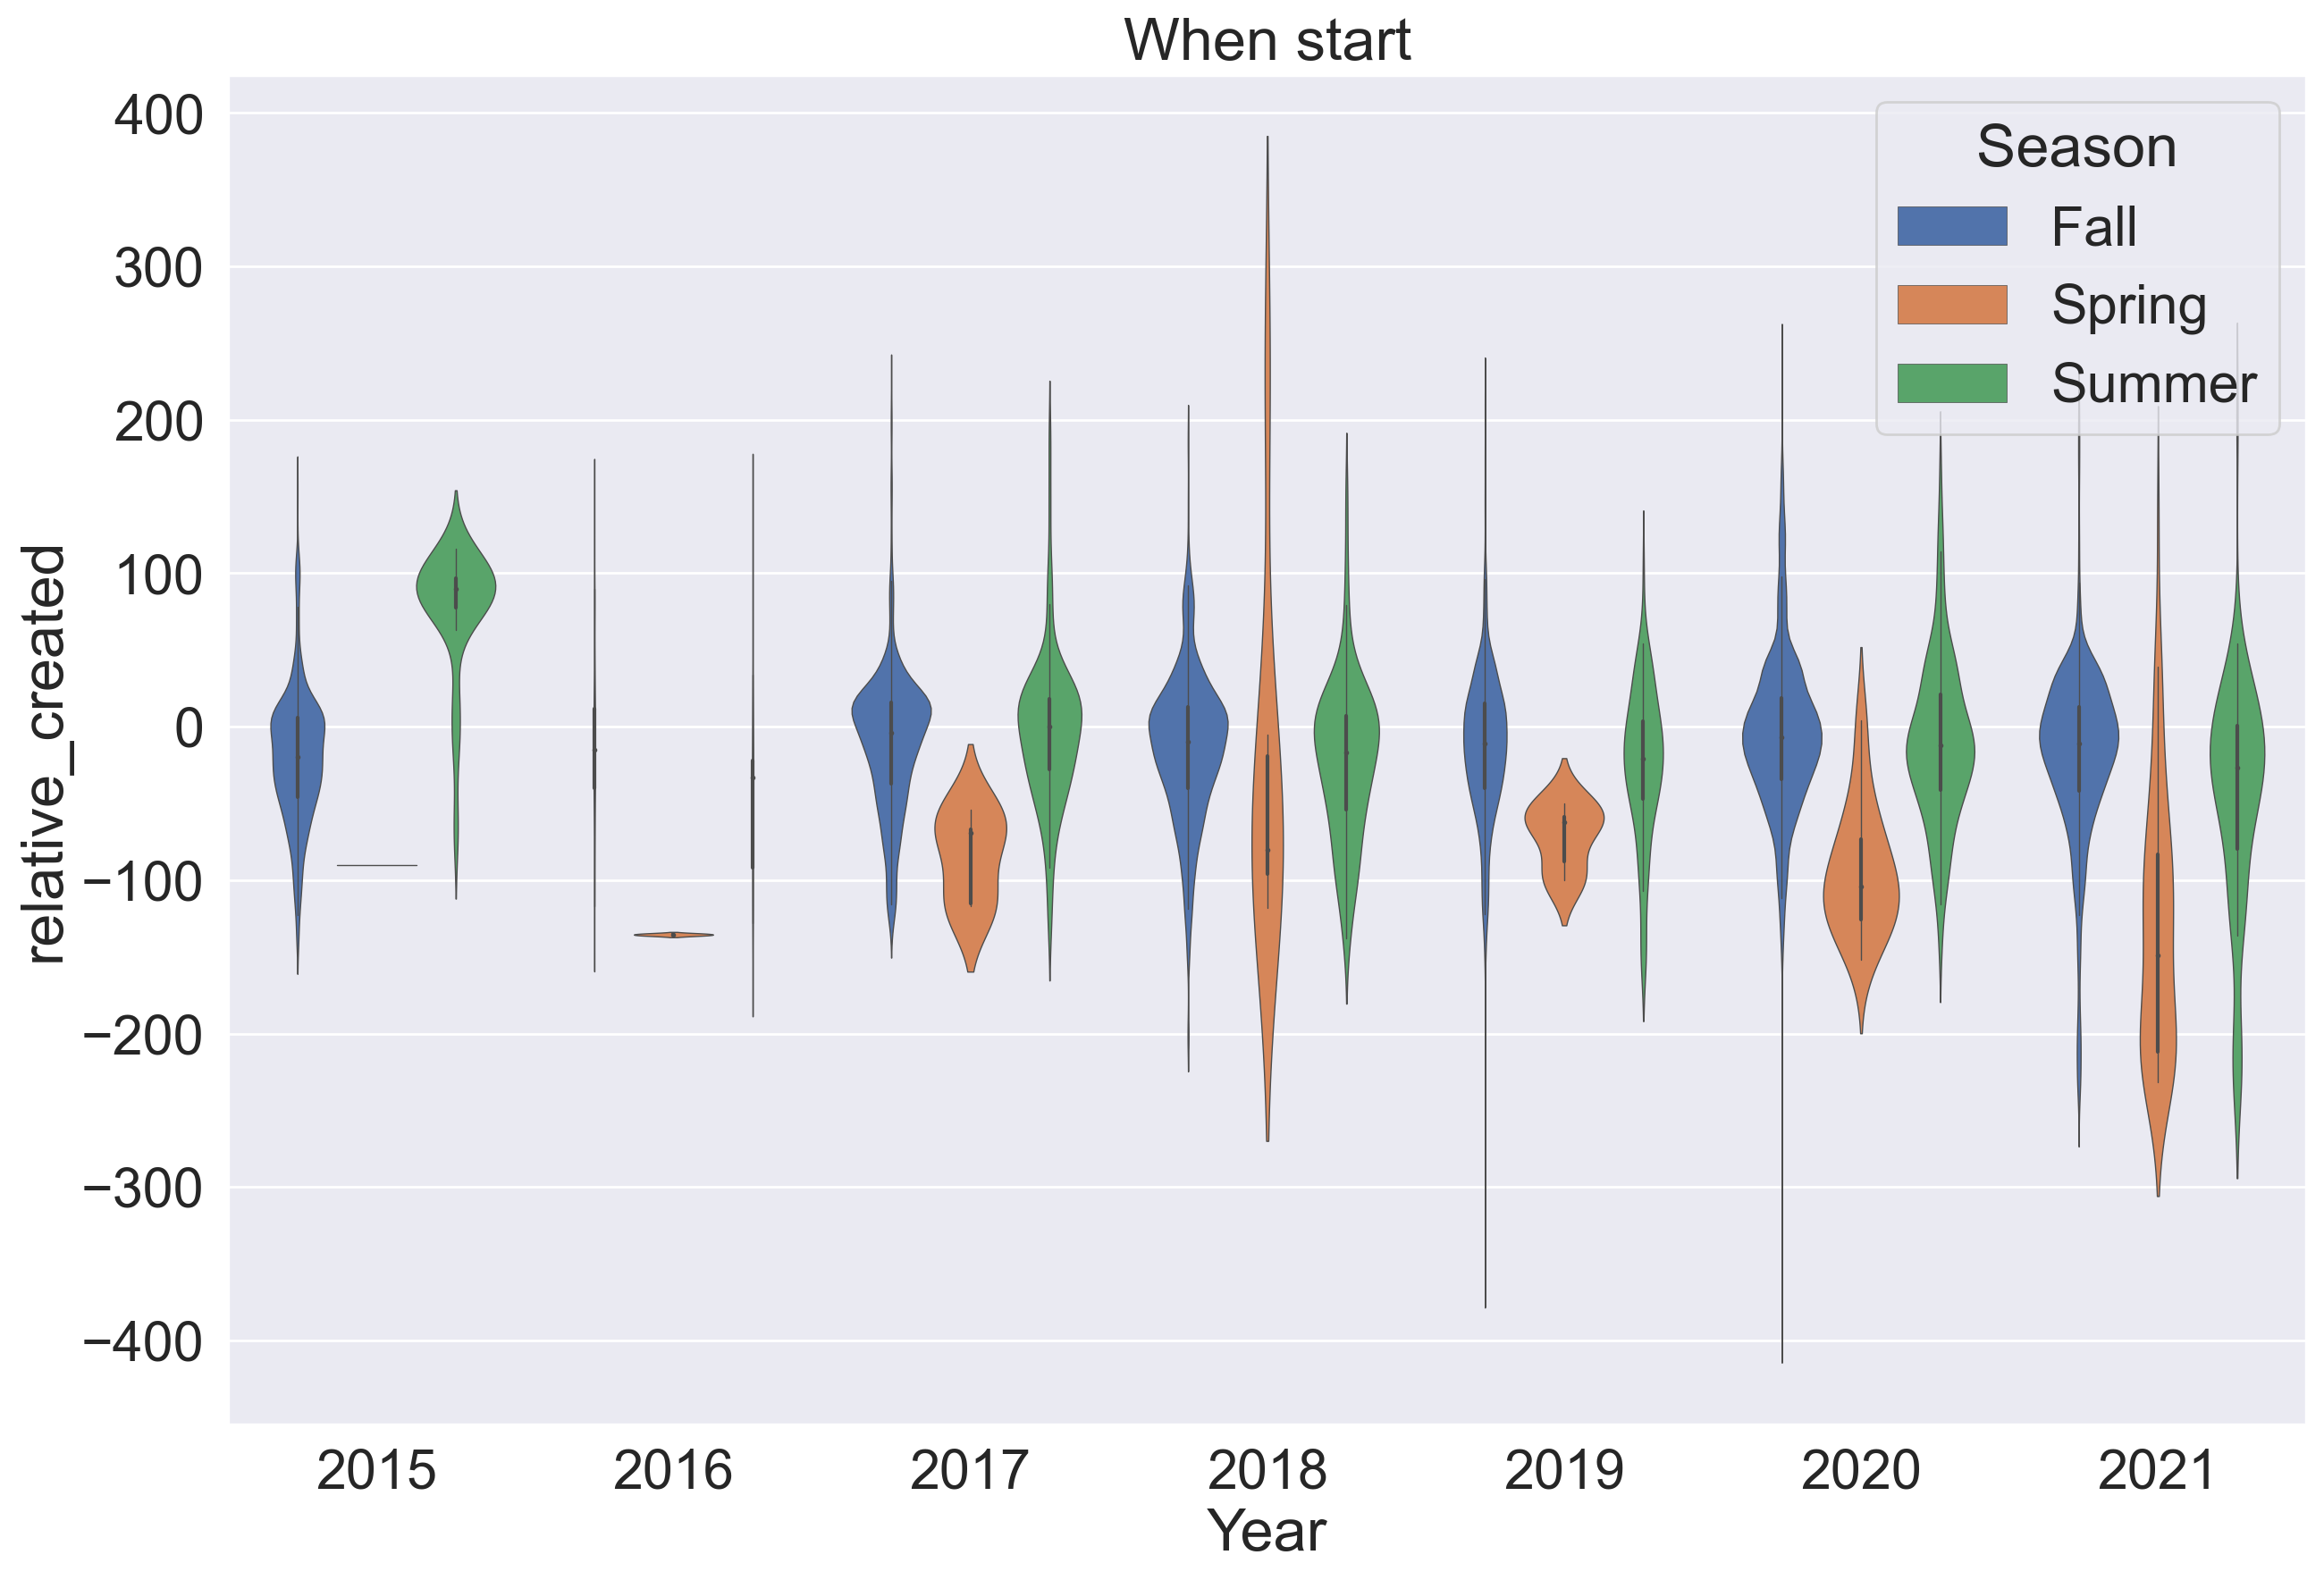

In [ ]:


fig = plt.figure(dpi=200, figsize=(15,10))

# Create an axes instance
#ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = sns.violinplot(data=df, y="relative_created", x="Year", hue="Season", saturation=0.9, linewidth=0.5)
plt.title('When start')

#fig = px.violin(df, y="relative_created", x="Year", color="Season", box=False, points="outliers",
#          hover_data=df.columns)
fig.show()
#for term in set(df['Entry Term']):

  #df[term].create

### When do applicants finish their applications?

In [ ]:
# create features of date time stamps-split into year, month, day of the month, hour
df['submitted_year'] = df['Submitted'].dt.year
#df
# create features of date time stamps-split into year, month, day of the month, hour
df['submitted_month'] = df['Submitted'].dt.month
#df

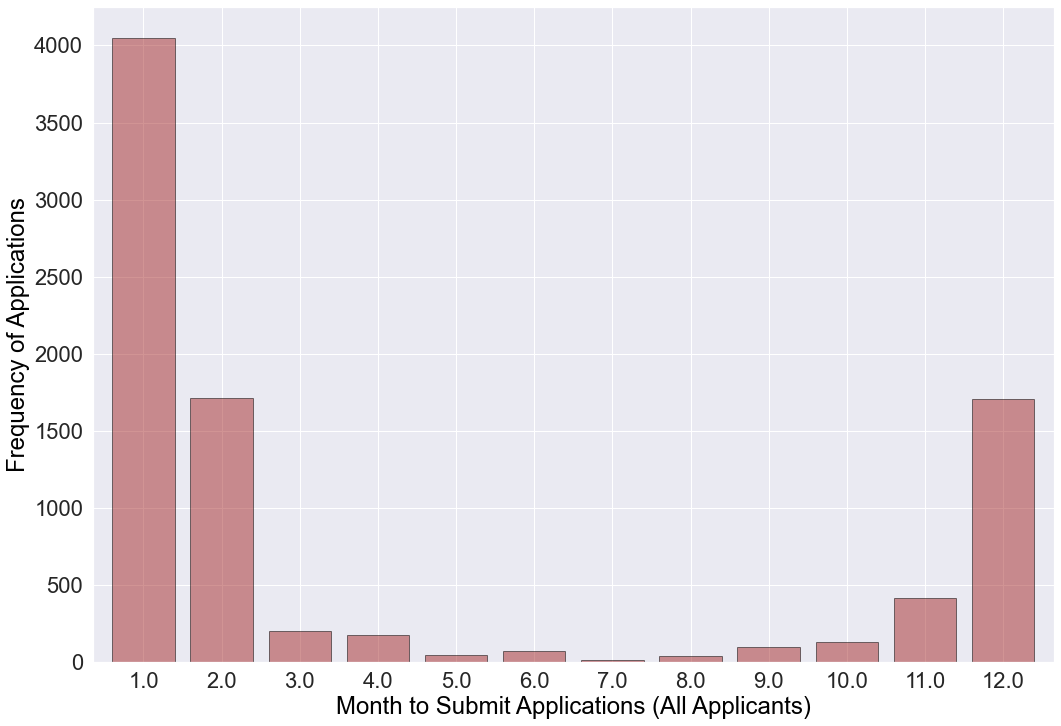

In [ ]:
# create month distribution for all applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(15,10))
plt.sca(ax)
df['Submitted'].groupby(df['submitted_month']).count().plot(kind='bar',color='brown', alpha=0.5, width=0.8, edgecolor='black')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Month to Submit Applications (All Applicants)', color='black')
ax.set_ylabel('Frequency of Applications', color='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
# create features of date time stamps-split into year, month, day of the month, hour
df['submitted_day'] = df['Submitted'].dt.day

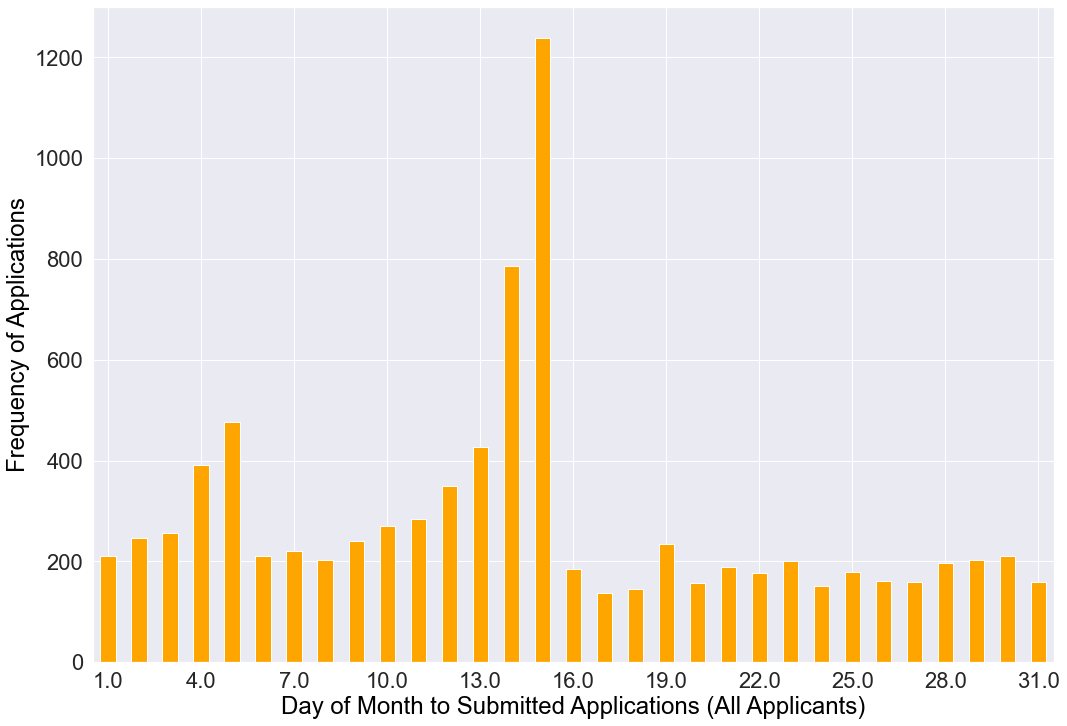

In [ ]:
# create day of month distribution for all applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(15,10))
plt.sca(ax)
df['Submitted'].groupby(df['submitted_day']).count().plot(kind='bar', color='orange')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Day of Month to Submitted Applications (All Applicants)', color='black')
ax.set_ylabel('Frequency of Applications', color='black')
x_major_locator=MultipleLocator(3)
ax.xaxis.set_major_locator(x_major_locator)
plt.subplots_adjust(hspace=0.1, wspace=0.1, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
# create features of date time stamps-split into year, month, day of the month, hour
df['submitted_hour'] = df['Submitted'].dt.hour
# create feature of week number of the year
df['submitted_week'] = df['Submitted'].dt.week

In [ ]:
# create feature: day of the week 
df['submitted_dayofweek'] = df['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.

# add one to each variable 
df['submitted_dayofweek'] = df['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

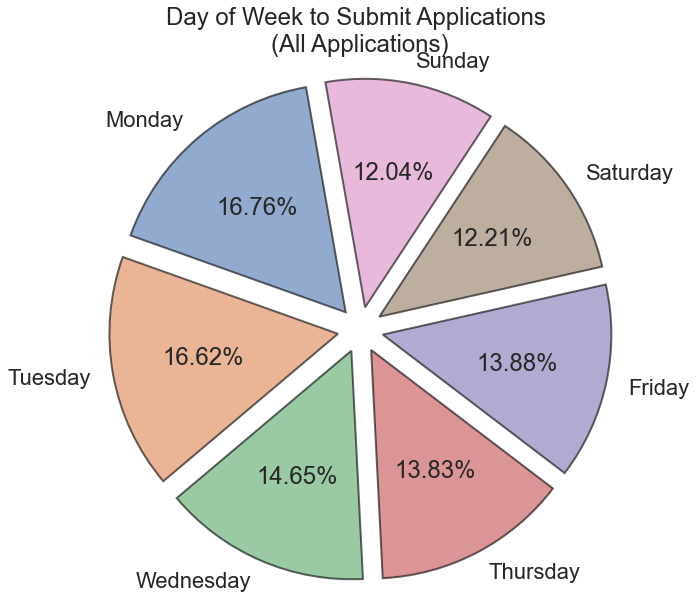

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
fig, ax = plt.subplots(1,figsize=(10,10))
sizes= [1698, 1683, 1484, 1401, 1406,1237,1220]

n=plt.pie(sizes,labels=labels, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
    n[0][i].set_alpha(alpha)

plt.title('Day of Week to Submit Applications \n(All Applications)')

plt.axis('equal')

plt.show()

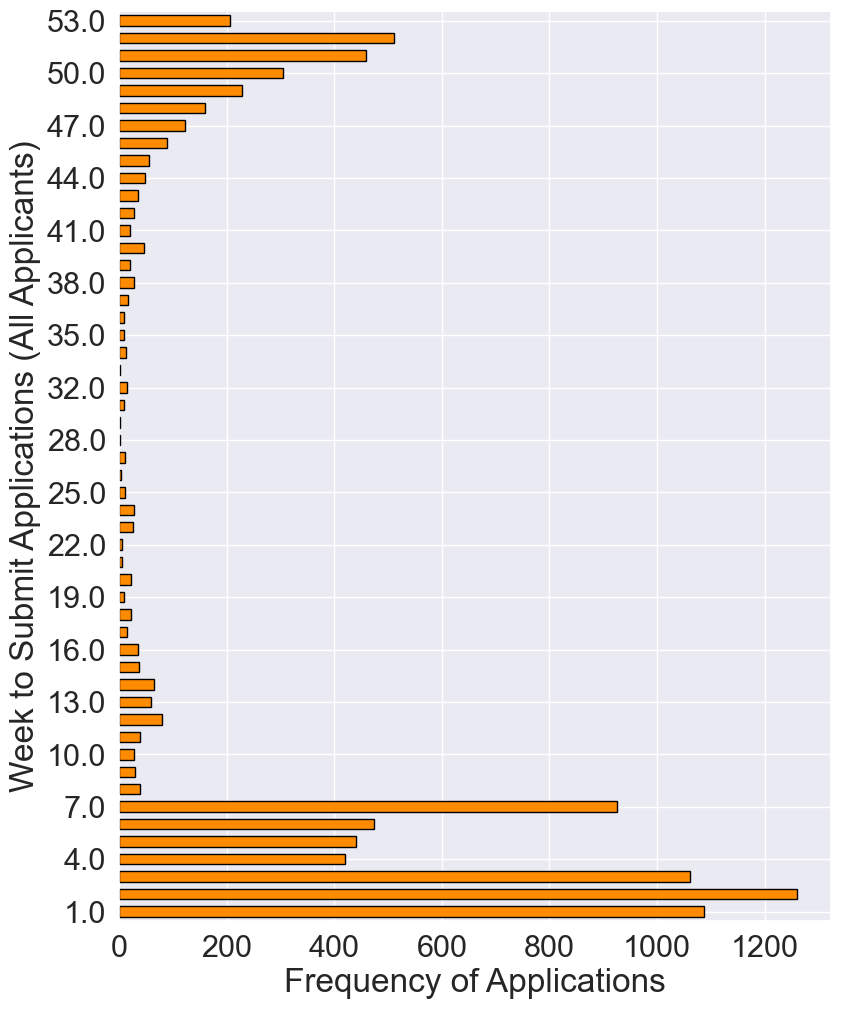

In [ ]:
# create day of month distribution for all applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(8,10), dpi=100)
plt.sca(ax)
df['Submitted'].groupby(df['submitted_week']).count().plot(kind='barh', color='darkorange', width=0.6, edgecolor='black')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Frequency of Applications')
ax.set_ylabel('Week to Submit Applications (All Applicants)')
y_major_locator=MultipleLocator(3)
ax.yaxis.set_major_locator(y_major_locator)
plt.subplots_adjust(hspace=0.1, wspace=0.1, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
# create feature: day of the week 
df_china['submitted_dayofweek'] = df_china['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.

# add one to each variable 
df_china['submitted_dayofweek'] = df_china['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

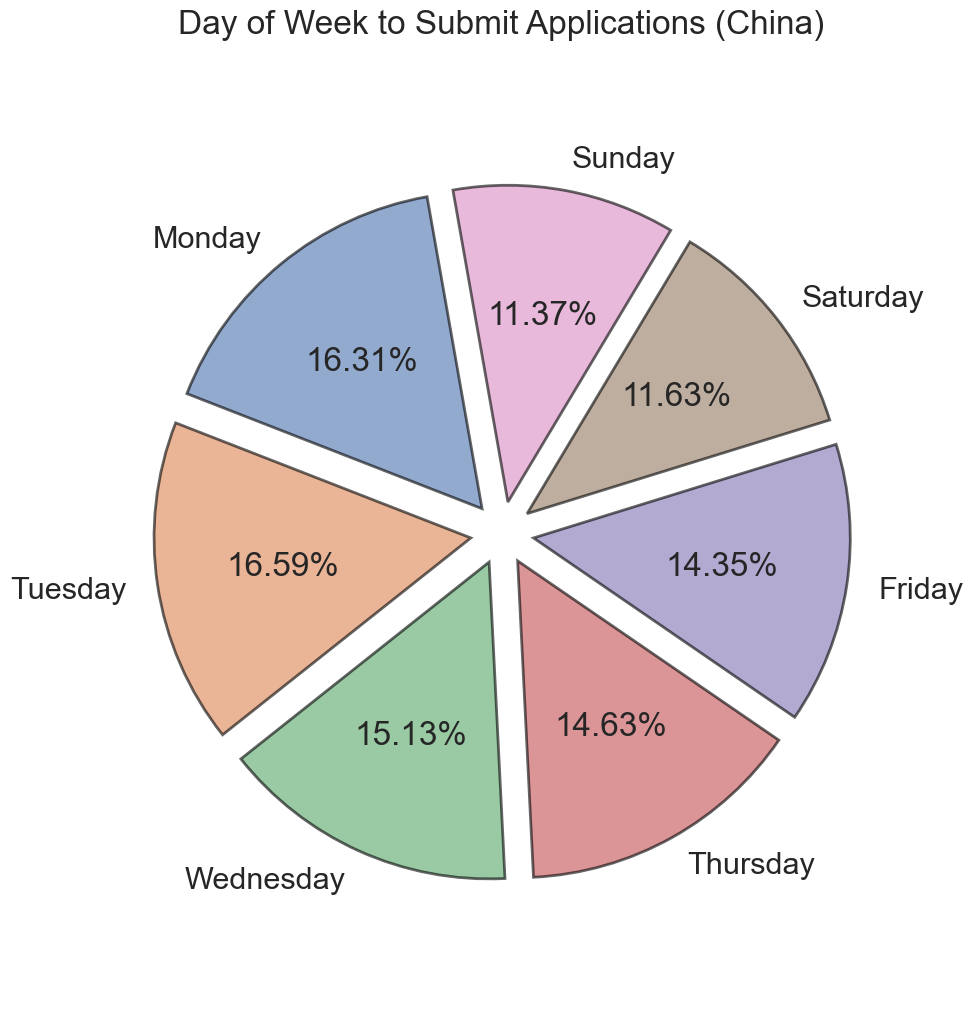

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
#colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [1050, 1068, 974, 942, 924, 749,732]
plt.figure(figsize=(10,13), dpi=100)
n=plt.pie(sizes,labels=labels,startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
    n[0][i].set_alpha(alpha)
plt.title('Day of Week to Submit Applications (China)')
plt.axis('equal')
plt.show()

In [ ]:
# create feature: day of the week 
df_india['submitted_dayofweek'] = df_india['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
# add one to each variable 
df_india['submitted_dayofweek'] = df_india['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

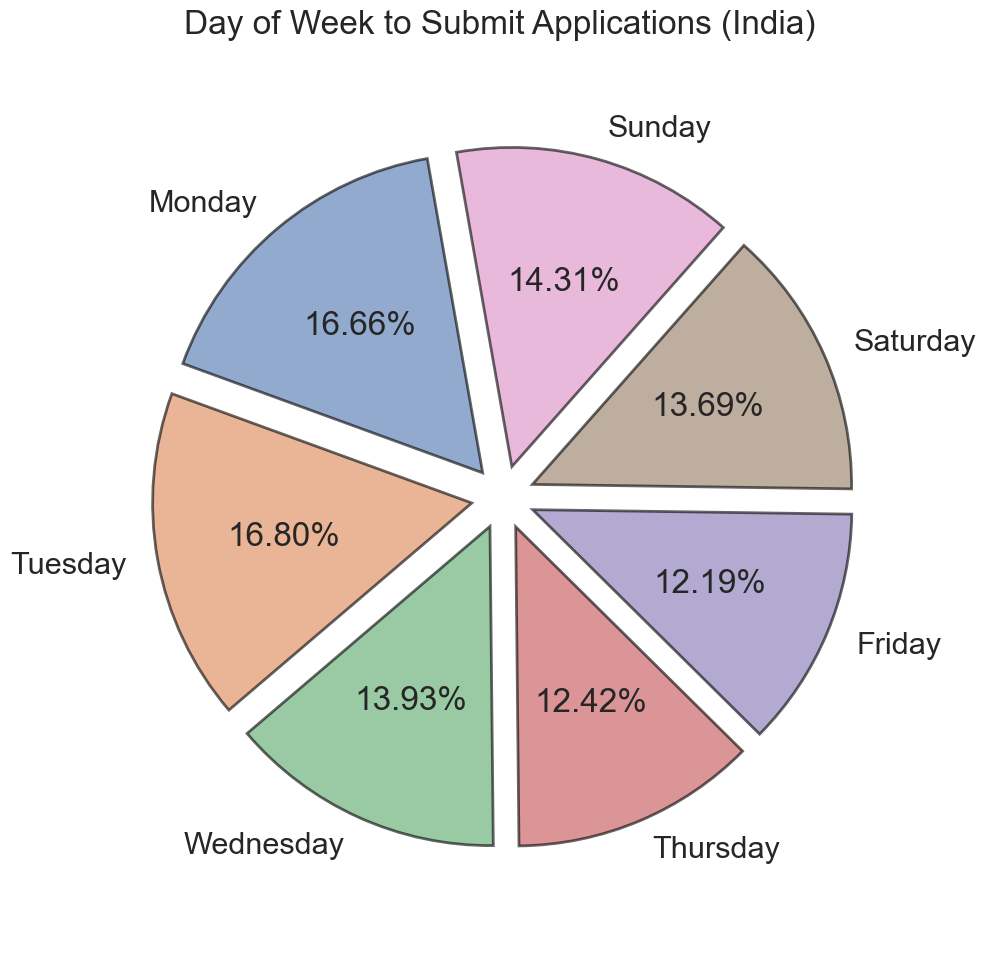

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
#colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
plt.figure(figsize=(10,12), dpi=100)
sizes= [354, 357, 296, 264, 259, 291, 304]
n=plt.pie(sizes,labels=labels, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
    n[0][i].set_alpha(alpha)
plt.title('Day of Week to Submit Applications (India)')
plt.axis('equal')
plt.show()

In [ ]:
# create feature: day of the week 
df_us['submitted_dayofweek'] = df_us['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
# add one to each variable 
df_us['submitted_dayofweek'] = df_us['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

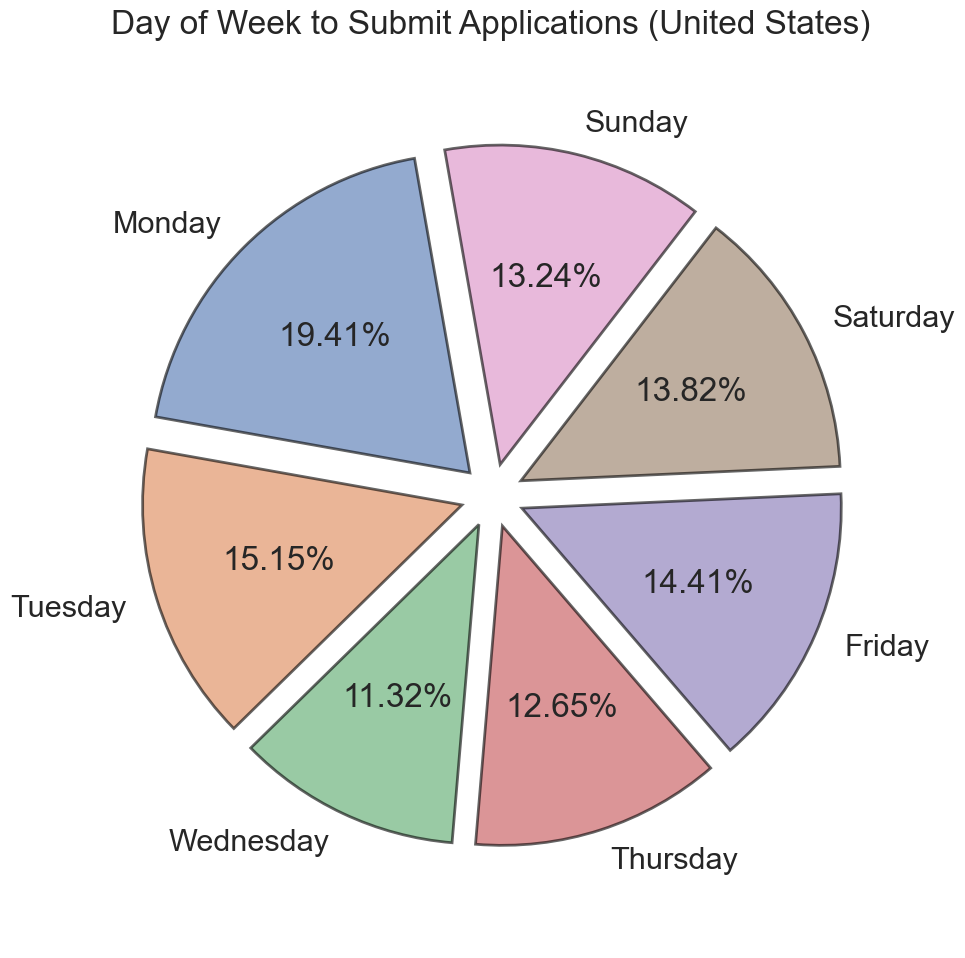

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
#colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [132, 103, 77, 86, 98, 94, 90]
plt.figure(figsize=(10,12), dpi=100)
n=plt.pie(sizes,labels=labels,  startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 2,
                      'antialiased': True})
alpha=0.6
for i in range(7):
    n[0][i].set_alpha(alpha)
plt.title('Day of Week to Submit Applications (United States)')
plt.axis('equal')
plt.show()

In [ ]:
# gender difference
## for male
df_male['submitted_month'] = df_male['Submitted'].dt.month

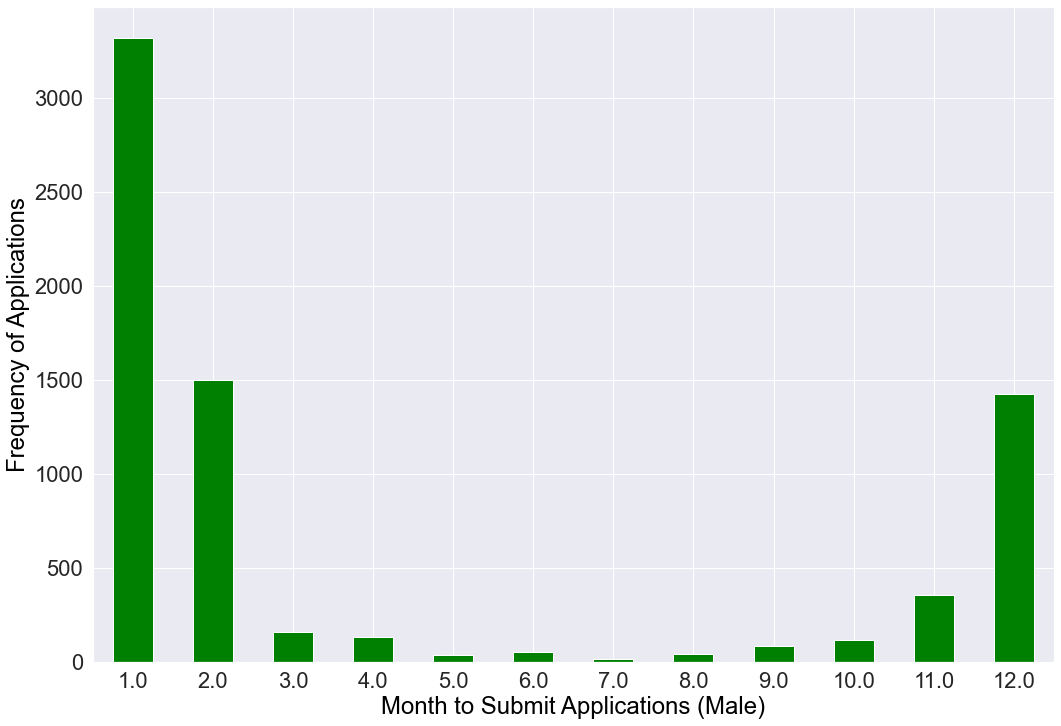

In [ ]:
# create month distribution for male applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(15,10))
plt.sca(ax)
df_male['Submitted'].groupby(df_male['submitted_month']).count().plot(kind='bar',color='green')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Month to Submit Applications (Male)', color='black')
ax.set_ylabel('Frequency of Applications', color='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
## for female
df_female['submitted_month'] = df_female['Submitted'].dt.month

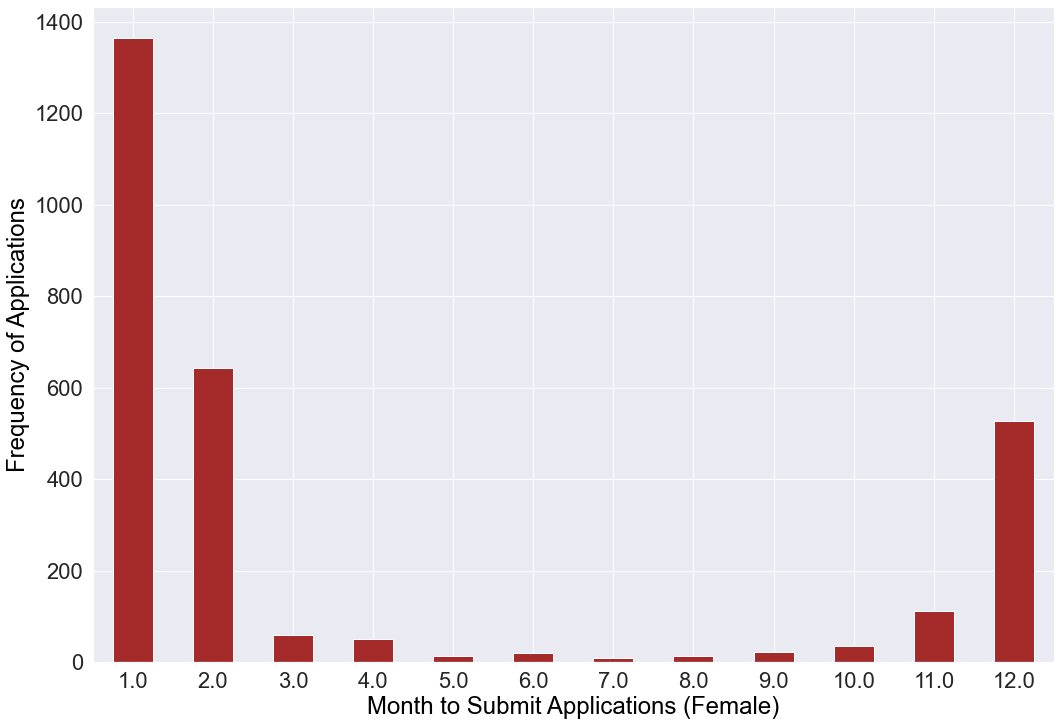

In [ ]:
# create month distribution for female applicants
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,10))
plt.sca(ax)
df_female['Submitted'].groupby(df_female['submitted_month']).count().plot(kind='bar',color='brown')
ax.tick_params(labelrotation=0)
ax.set_xlabel('Month to Submit Applications (Female)', color='black')
ax.set_ylabel('Frequency of Applications', color='black')
plt.subplots_adjust(hspace=0.5, wspace=0.5, left=0.1, bottom=0.08, top=0.99, right=0.99)

In [ ]:
# age difference:
# create feature: day of the week 
df_ageunder25['submitted_dayofweek'] = df_ageunder25['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
# add one to each variable 
df_ageunder25['submitted_dayofweek'] = df_ageunder25['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

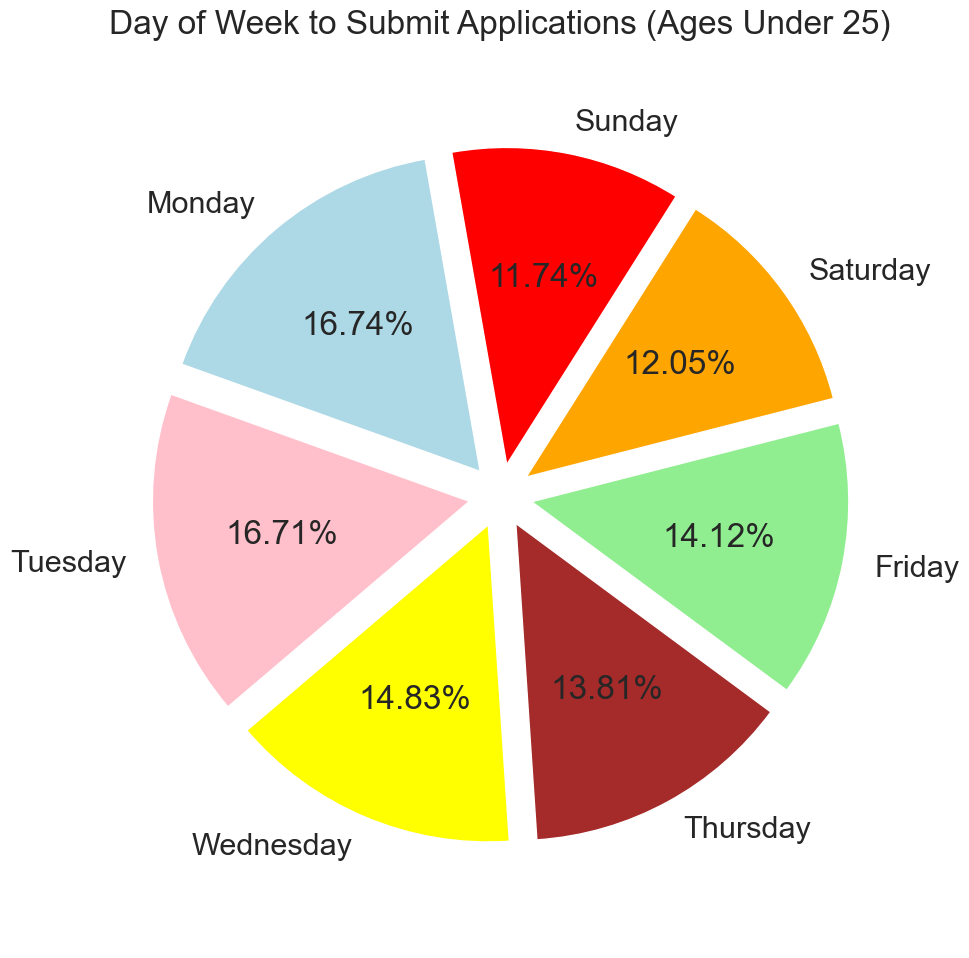

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [1425, 1423, 1263, 1176,1202,1026,1000]
plt.figure(figsize=(10,12), dpi=100)
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Day of Week to Submit Applications (Ages Under 25)')
plt.axis('equal')
plt.show()

In [ ]:
# age difference:
# create feature: day of the week 
df_age25to29['submitted_dayofweek'] = df_age25to29['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
# add one to each variable 
df_age25to29['submitted_dayofweek'] = df_age25to29['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

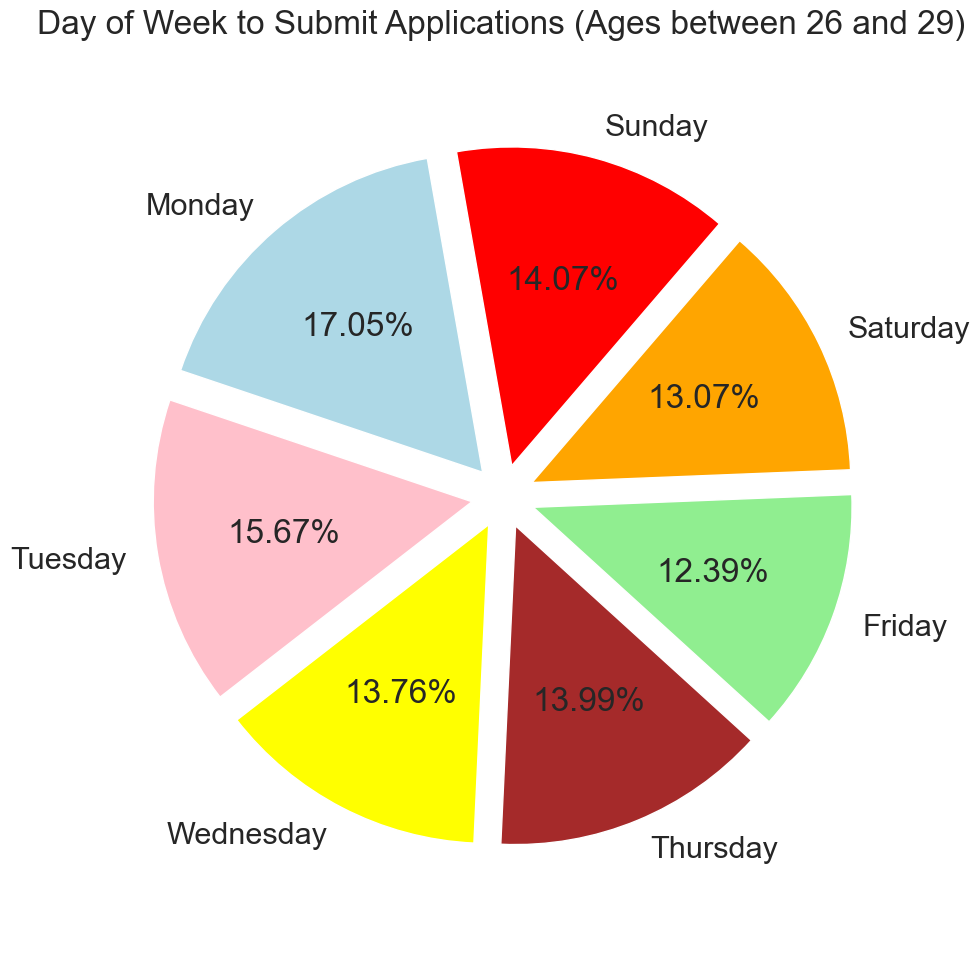

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [223, 205, 180,183,162,171,184]
plt.figure(figsize=(10,12), dpi=100)
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Day of Week to Submit Applications (Ages between 26 and 29)')
plt.axis('equal')
plt.show()

In [ ]:
# age difference:
# create feature: day of the week 
df_ageabove30['submitted_dayofweek'] = df_ageabove30['Submitted'].dt.dayofweek #  Monday  is denoted by 0 and  Sunday is denoted by 6.
# add one to each variable 
df_ageabove30['submitted_dayofweek'] = df_ageabove30['submitted_dayofweek']+1 # now monday is 1, and sunday is 7, more intuitive.

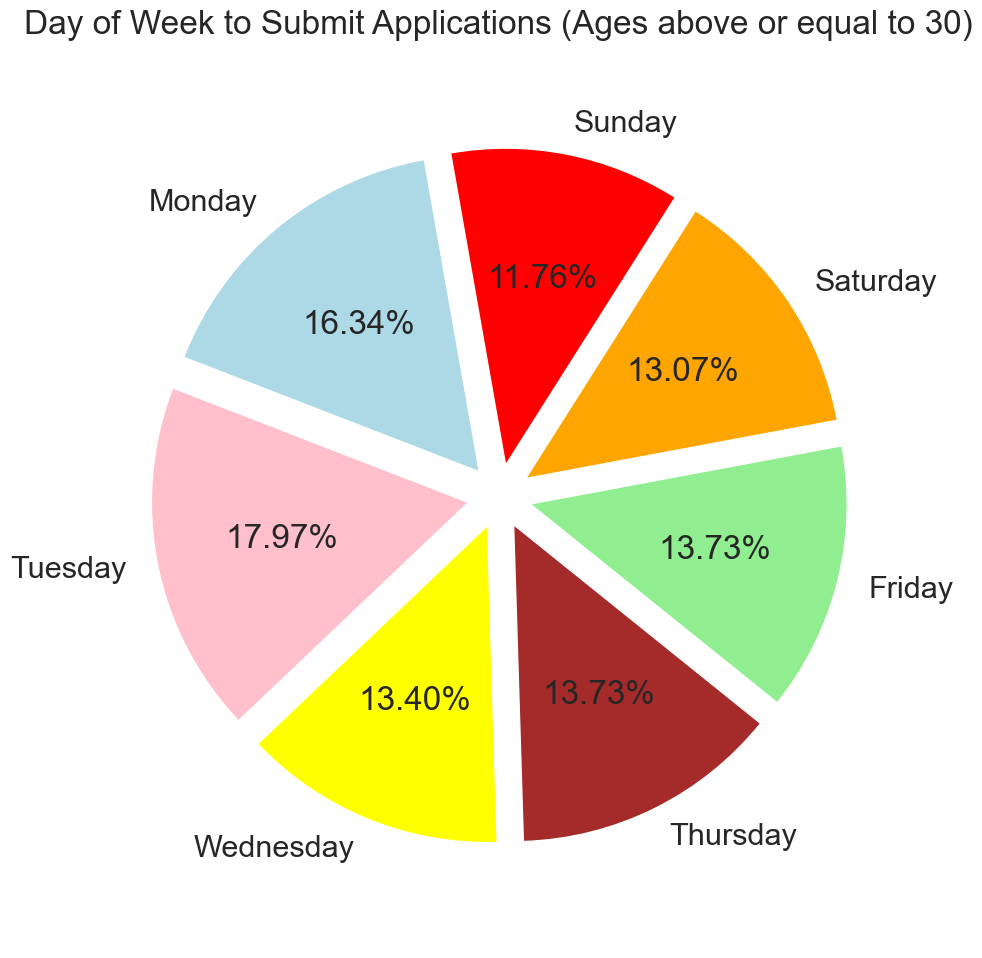

In [ ]:
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
colors=['lightblue','pink', 'yellow','brown', 'lightgreen', 'orange','red']
sizes= [50, 55, 41,42,42,40,36]
plt.figure(figsize=(10,12), dpi=100)
plt.pie(sizes,labels=labels, colors=colors, startangle=100, shadow=False,explode=(0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1), autopct='%1.2f%%')
plt.title('Day of Week to Submit Applications (Ages above or equal to 30)')
plt.axis('equal')
plt.show()

In [ ]:
# compare across programs:
df_dsprogram = df[df['Program (ASE)']=='Data Science']

df_eceprogram = df[df['Program (ASE)']=='Electrical and Computer Engineering']

df_csprogram = df[df['Program (ASE)']=='Computer Science']

In [ ]:
df_dsprogram['submitted_week'] = df_dsprogram['Submitted'].dt.week
df_eceprogram['submitted_week'] = df_eceprogram['Submitted'].dt.week
df_csprogram['submitted_week'] = df_csprogram['Submitted'].dt.week

Text(0, 0.5, 'Week to Submit Applications (Data Science)')

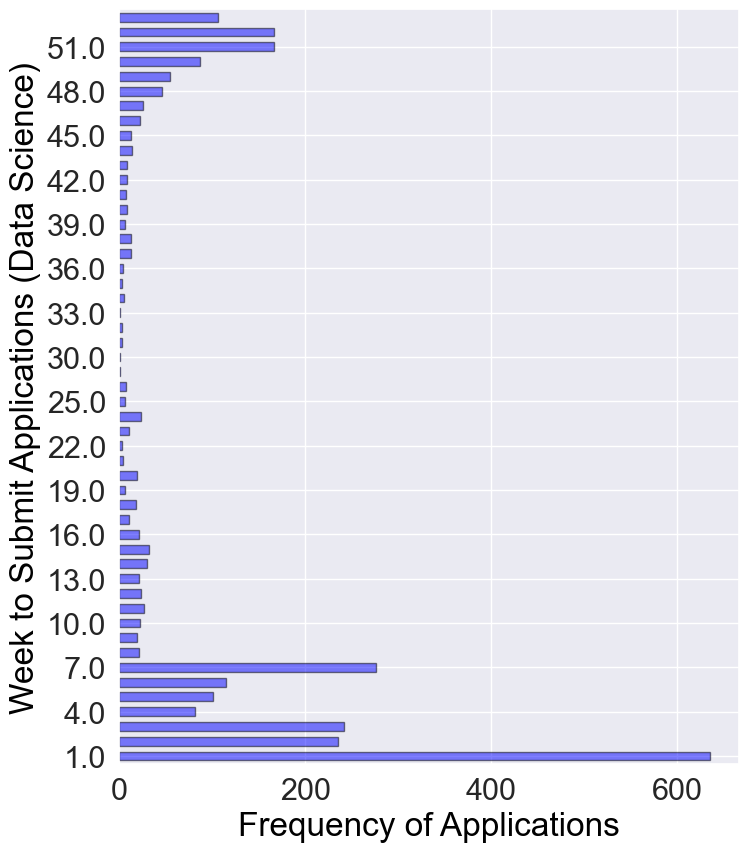

In [ ]:
# 3) By week
fig,ax = plt.subplots(1, figsize=(8,10),dpi=100)
plt.sca(ax)
df_dsprogram['Submitted'].groupby(df_dsprogram['submitted_week']).count().plot(kind='barh', color='blue', alpha=0.5, width=0.6, edgecolor='black')
ax.set_xlabel('Frequency of Applications', color='black')
y_major_locator=MultipleLocator(3)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_ylabel('Week to Submit Applications (Data Science)', color='black')

Text(0, 0.5, 'Week to Submit Applications (Electrical and Computer Engineering)')

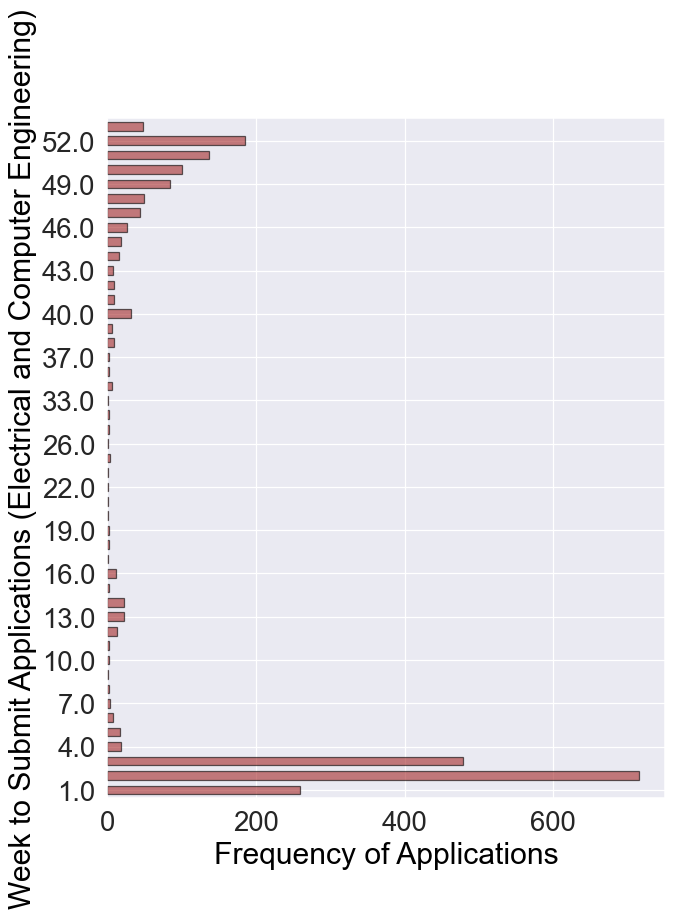

In [ ]:
# 3)  By week
fig,ax = plt.subplots(1,figsize=(8,10),dpi=90)
plt.sca(ax)
df_eceprogram['Submitted'].groupby(df_eceprogram['submitted_week']).count().plot(kind='barh', color='brown', alpha=0.6, width=0.6, edgecolor='black')
ax.set_xlabel('Frequency of Applications', color='black')
y_major_locator=MultipleLocator(3)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_ylabel('Week to Submit Applications (Electrical and Computer Engineering)', color='black')

Text(0, 0.5, 'Week to Submit Applications (Computer Science)')

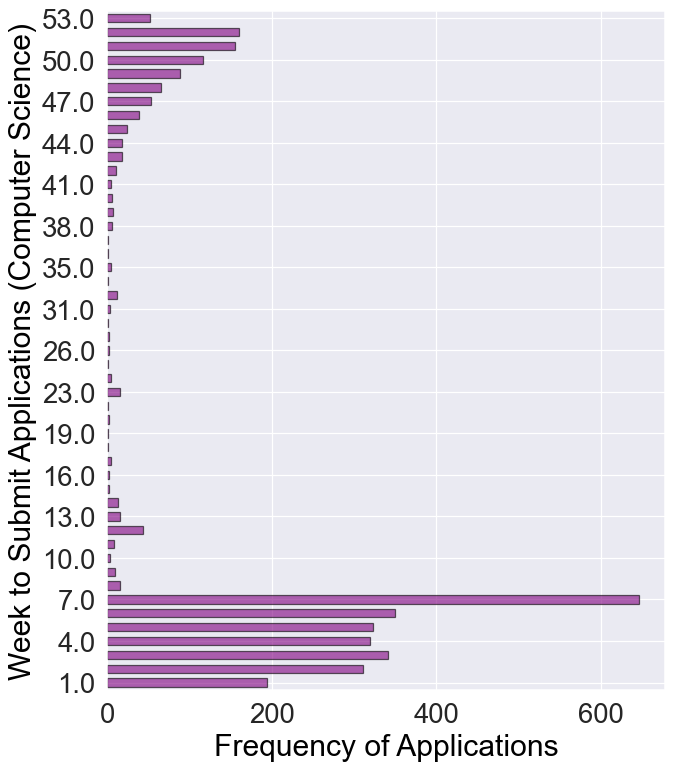

In [ ]:
# 3)  By week
fig,ax = plt.subplots(1,figsize=(8, 10),dpi=90)
plt.sca(ax)
df_csprogram['Submitted'].groupby(df_csprogram['submitted_week']).count().plot(kind='barh', color='purple', alpha=0.6, width=0.6, edgecolor='black')
ax.set_xlabel('Frequency of Applications', color='black')
y_major_locator=MultipleLocator(3)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_ylabel('Week to Submit Applications (Computer Science)', color='black')

In [ ]:
df['Submitted']
df["date"] = df['Submitted'].dt.date
count = df['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')
count.index = pd.to_datetime(count.index)

In [ ]:
# heatmap for 2015
df_s2015 = df[df['submitted_year']==2015.0]
df_s2015["date"] = df_s2015['Submitted'].dt.date
count = df_s2015['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<AxesSubplot:title={'center':'Calendar Heatmap for Submission'}>

<Figure size 1500x800 with 0 Axes>

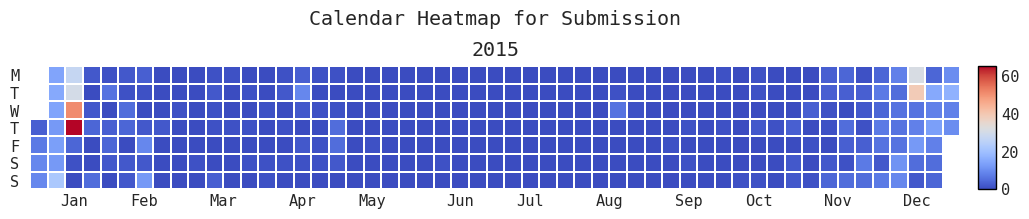

In [ ]:
sns.set(font_scale=1)
count.index = pd.to_datetime(count.index)
plt.figure(figsize=(15,8), dpi=100)
july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)

In [ ]:
# heatmap for 2016
df_s2016 = df[df['submitted_year']==2016.0]
df_s2016["date"] = df_s2016['Submitted'].dt.date
count = df_s2016['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<AxesSubplot:title={'center':'Calendar Heatmap for Submission'}>

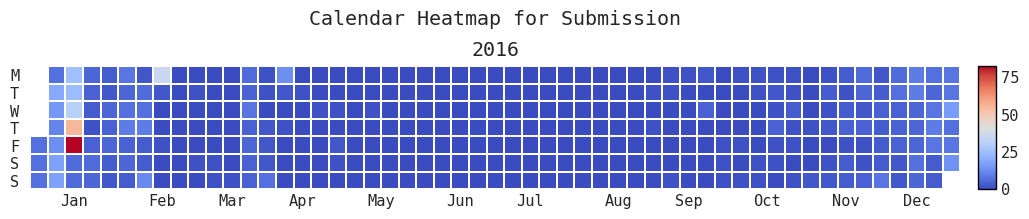

In [ ]:
count.index = pd.to_datetime(count.index)
july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)

In [ ]:
# heatmap for 2017
df_s2017 = df[df['submitted_year']==2017.0]
df_s2017["date"] = df_s2017['Submitted'].dt.date
count = df_s2017['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<AxesSubplot:title={'center':'Calendar Heatmap for Submission'}>

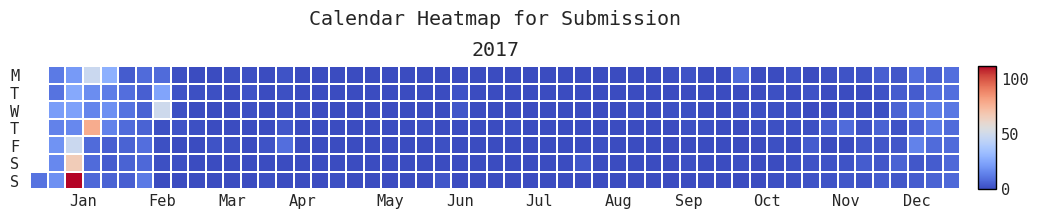

In [ ]:
count.index = pd.to_datetime(count.index)
july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)

In [ ]:
# heatmap for 2018
df_s2018 = df[df['submitted_year']==2018.0]
df_s2018["date"] = df_s2018['Submitted'].dt.date
count = df_s2018['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<AxesSubplot:title={'center':'Calendar Heatmap for Submission'}>

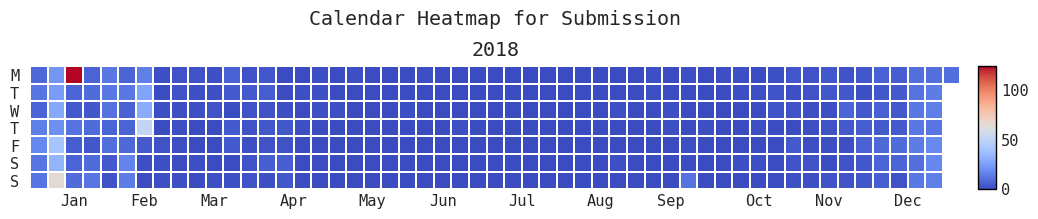

In [ ]:
count.index = pd.to_datetime(count.index)
july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)

In [ ]:
# heatmap for 2019
df_s2019 = df[df['submitted_year']==2019.0]
df_s2019["date"] = df_s2019['Submitted'].dt.date
count = df_s2019['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<AxesSubplot:title={'center':'Calendar Heatmap for Submission'}>

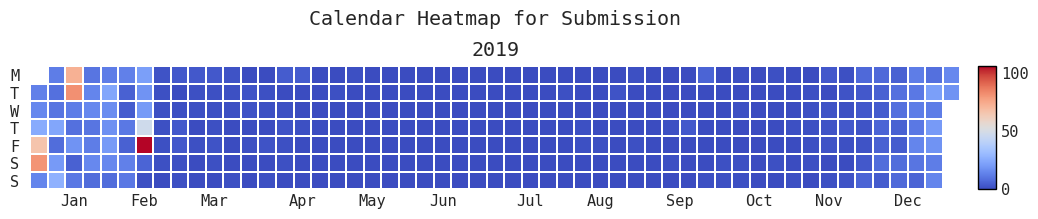

In [ ]:
count.index = pd.to_datetime(count.index)
july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)

In [ ]:
# heatmap for 2020
df_s2020 = df[df['submitted_year']==2020.0]
df_s2020["date"] = df_s2020['Submitted'].dt.date
count = df_s2020['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<AxesSubplot:title={'center':'Calendar Heatmap for Submission'}>

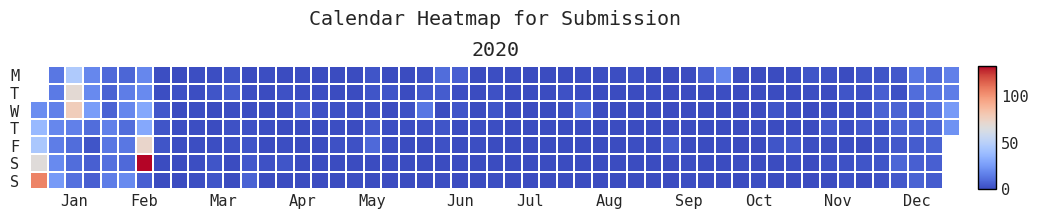

In [ ]:
count.index = pd.to_datetime(count.index)
july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)

In [ ]:
# heatmap for 2021
df_s2021 = df[df['submitted_year']==2021.0]
df_s2021["date"] = df_s2021['Submitted'].dt.date
count = df_s2021['date'].value_counts().rename_axis('unique_values').reset_index(name='counts')

<Figure size 1500x800 with 0 Axes>

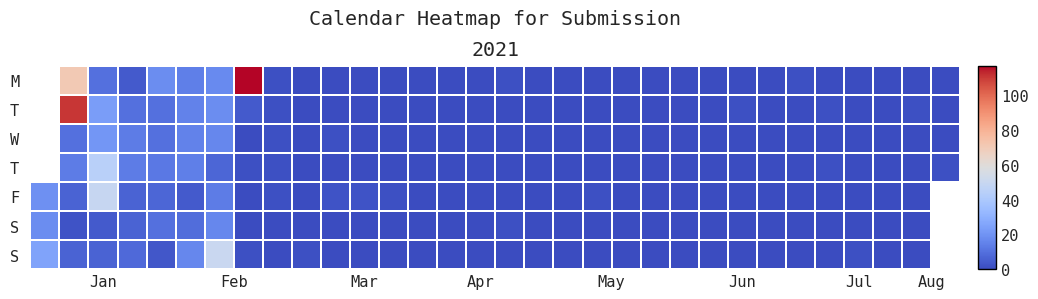

<Figure size 1500x800 with 0 Axes>

In [ ]:
count.index = pd.to_datetime(count.index)

july.heatmap(count['unique_values'], count['counts'], title='Calendar Heatmap for Submission', cmap="coolwarm",colorbar=True)
plt.figure(figsize=(15,8), dpi=100)
# reference: https://github.com/e-hulten/july

In [ ]:
from datetime import datetime
year = [datetime.strptime(term[-4:], '%Y') for term in df["Entry Term"]]
df["Year"] = year
relative_submit = df.Submitted - df.Year

day = [time.days for time in relative_submit]
df["relative_submit"] = day

year = [term[-4:] for term in df["Entry Term"]]
df["Year"] = year

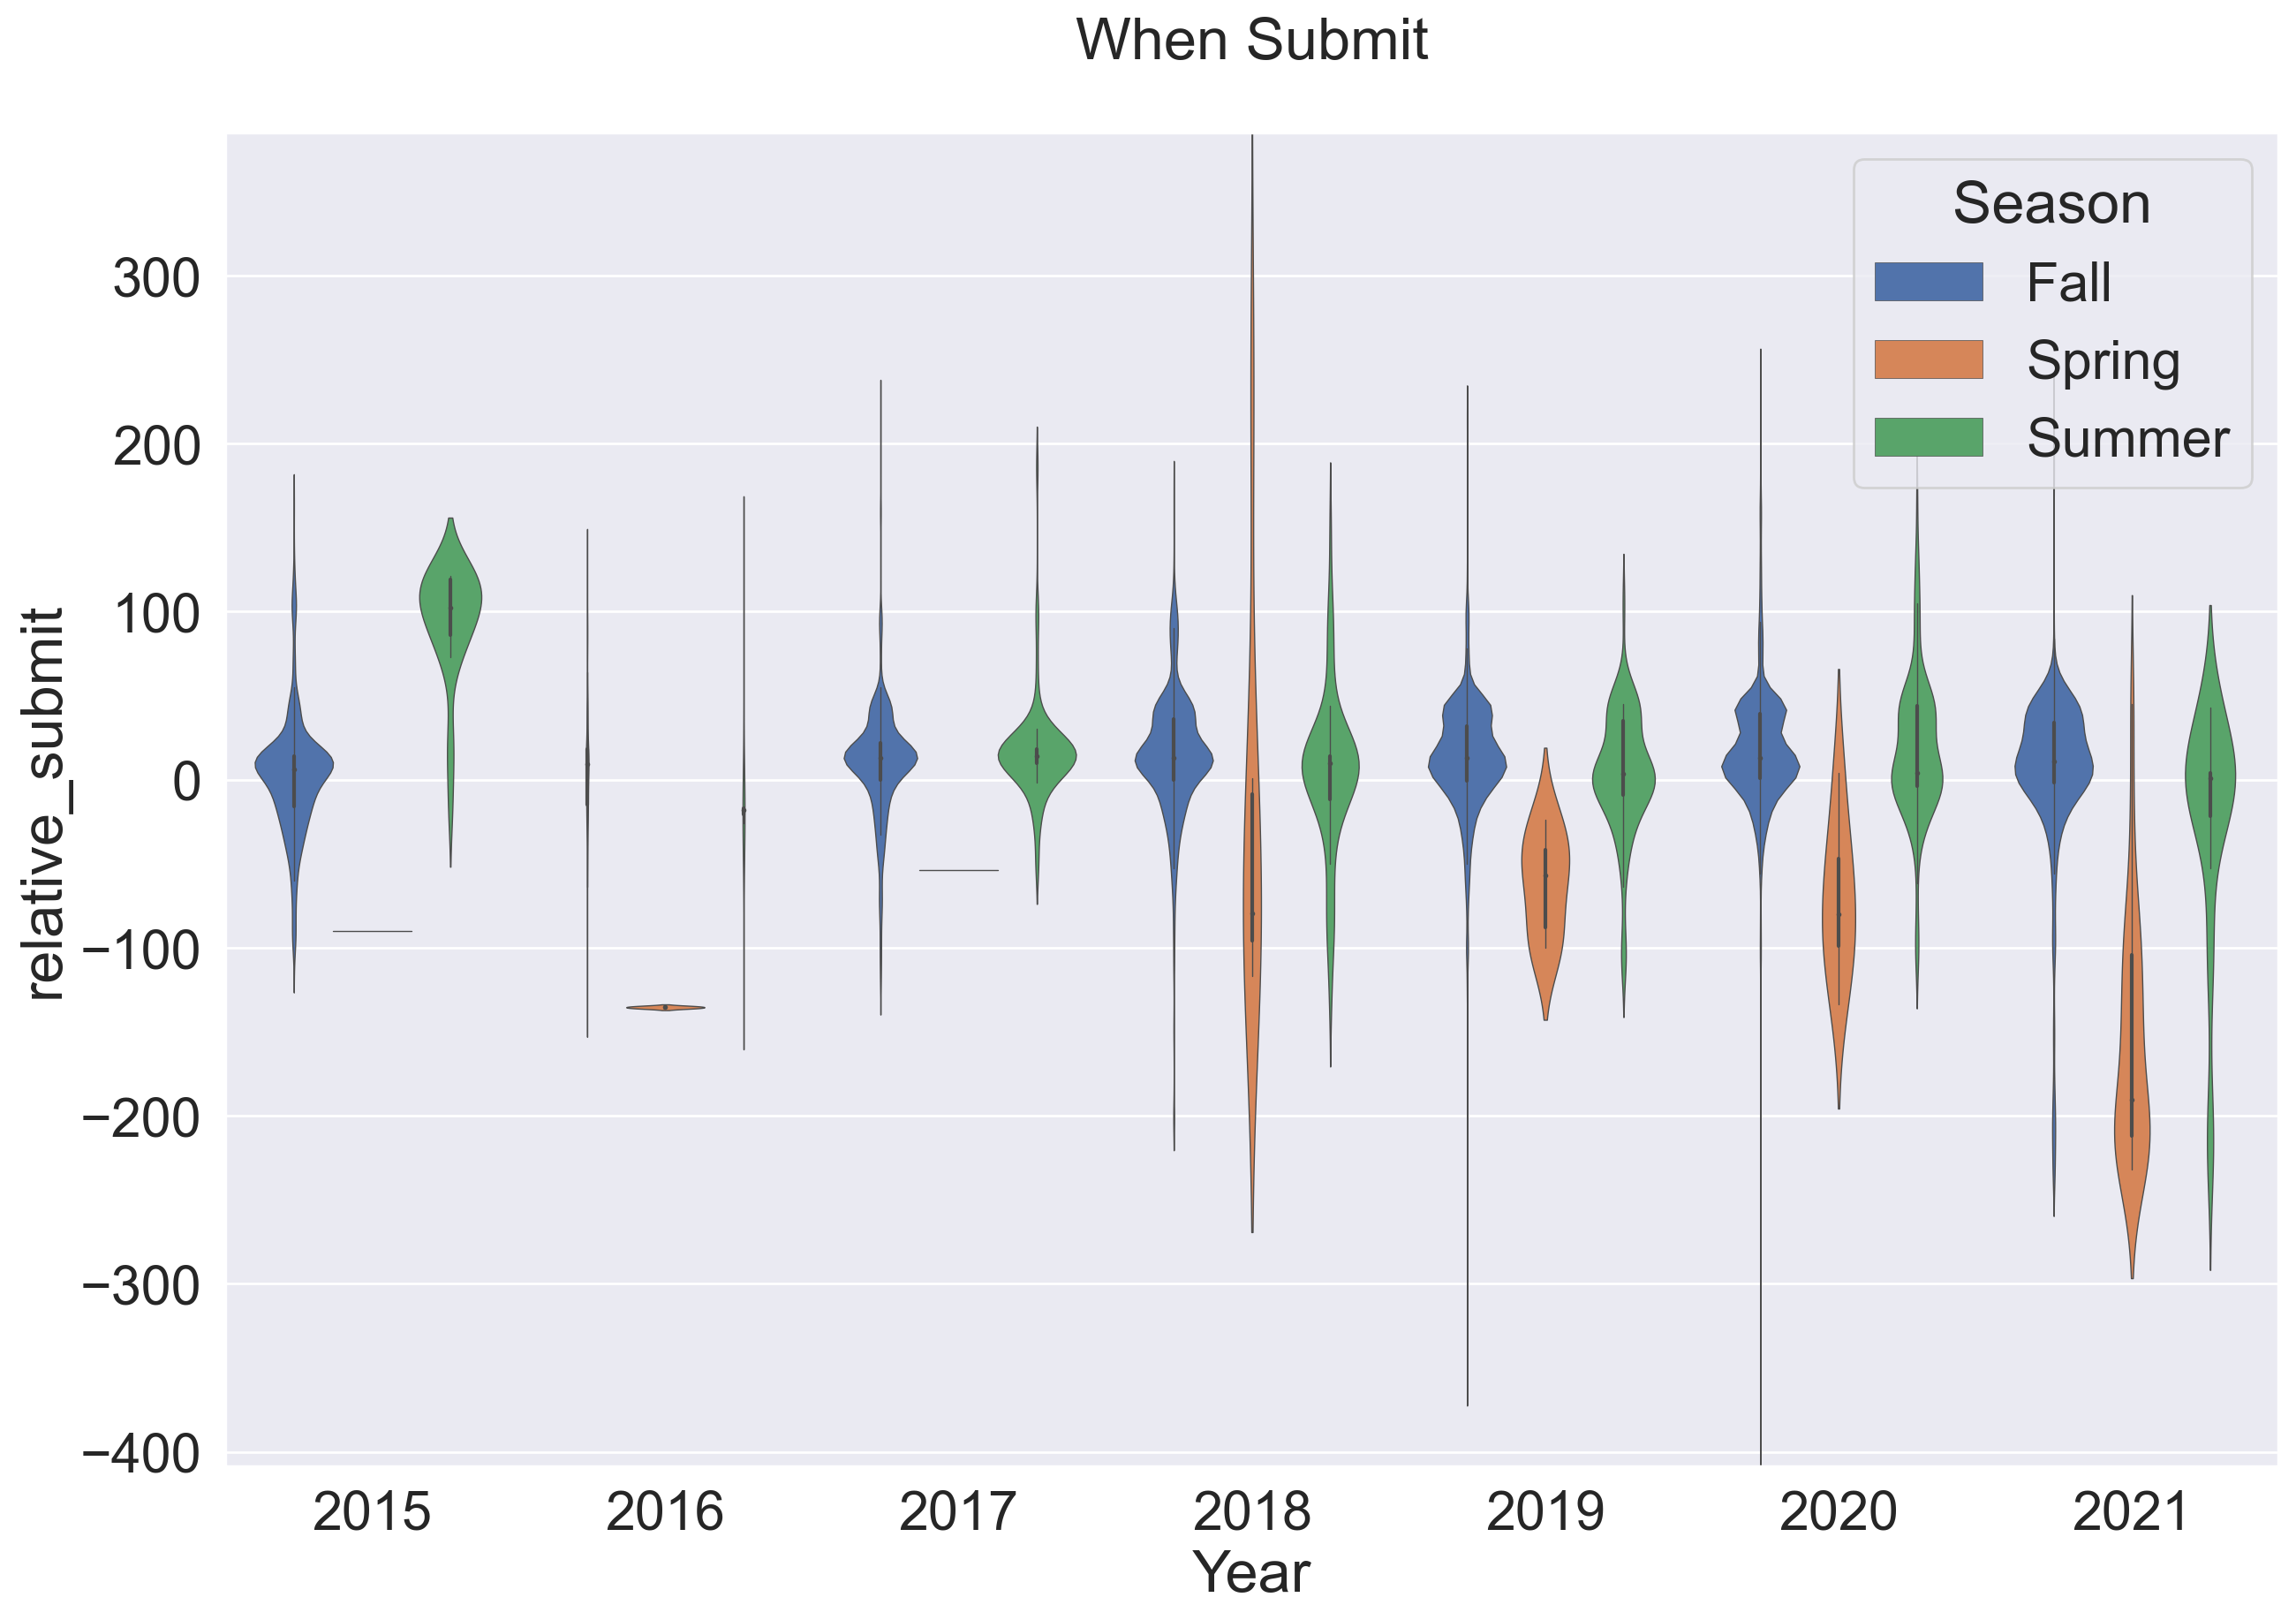

In [ ]:
sns.set(font_scale=2)
fig = plt.figure(dpi=200, figsize=(15,10))
bp = sns.violinplot(data=df, y="relative_submit", x="Year", hue="Season", saturation=0.9, linewidth=0.5)
plt.title('When Submit')

#fig = px.violin(df, y="relative_created", x="Year", color="Season", box=False, points="outliers",
#          hover_data=df.columns)
fig.show()

### How quickly do applicants submit applications?

In [ ]:

df = df[df['Degree']=='Master\'s']
df = df[df['Time Status']=='Full Time']

In [ ]:
df_submit = df[(~df['Created'].isnull())&(~df['Submitted'].isnull())]

In [ ]:
def submit_period(time1,time2):
    days = (time2.date()-time1.date()).days
    return days

In [ ]:
def submit_hour(time):
    hour = time.hour
    return hour

In [ ]:
# time spent on application
df_submit['submit_period'] = df_submit.apply(lambda a:submit_period(a.Created, a.Submitted), axis=1)

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'How soon do applicants submit \ntheir applications (days)')

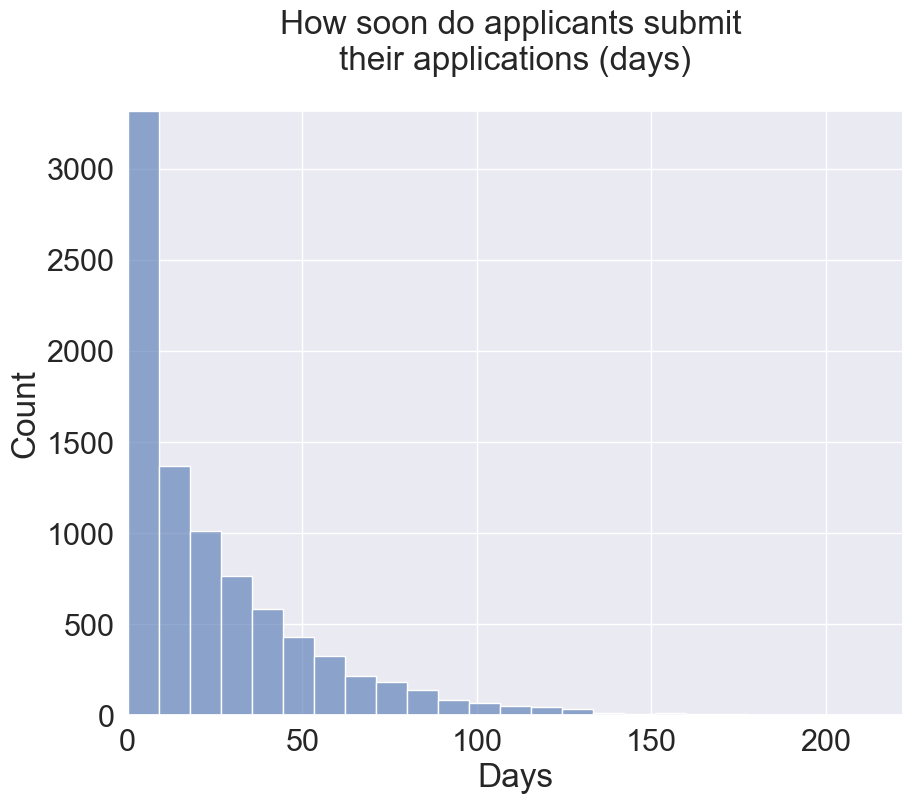

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.histplot(df_submit['submit_period'],bins=25, alpha=0.6)
ax.set_xlabel("Days")
ax.set_title("How soon do applicants submit \ntheir applications (days)")
#plt.savefig("./submit_period(days)")

In [ ]:
# filter those submit within one days
df_oneday = df_submit[df_submit['submit_period']==0]
df_oneday['submit_hour'] = df_oneday.apply(lambda a:submit_hour(a.Submitted), axis=1)

([<matplotlib.axis.XTick at 0x2963c9e41f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

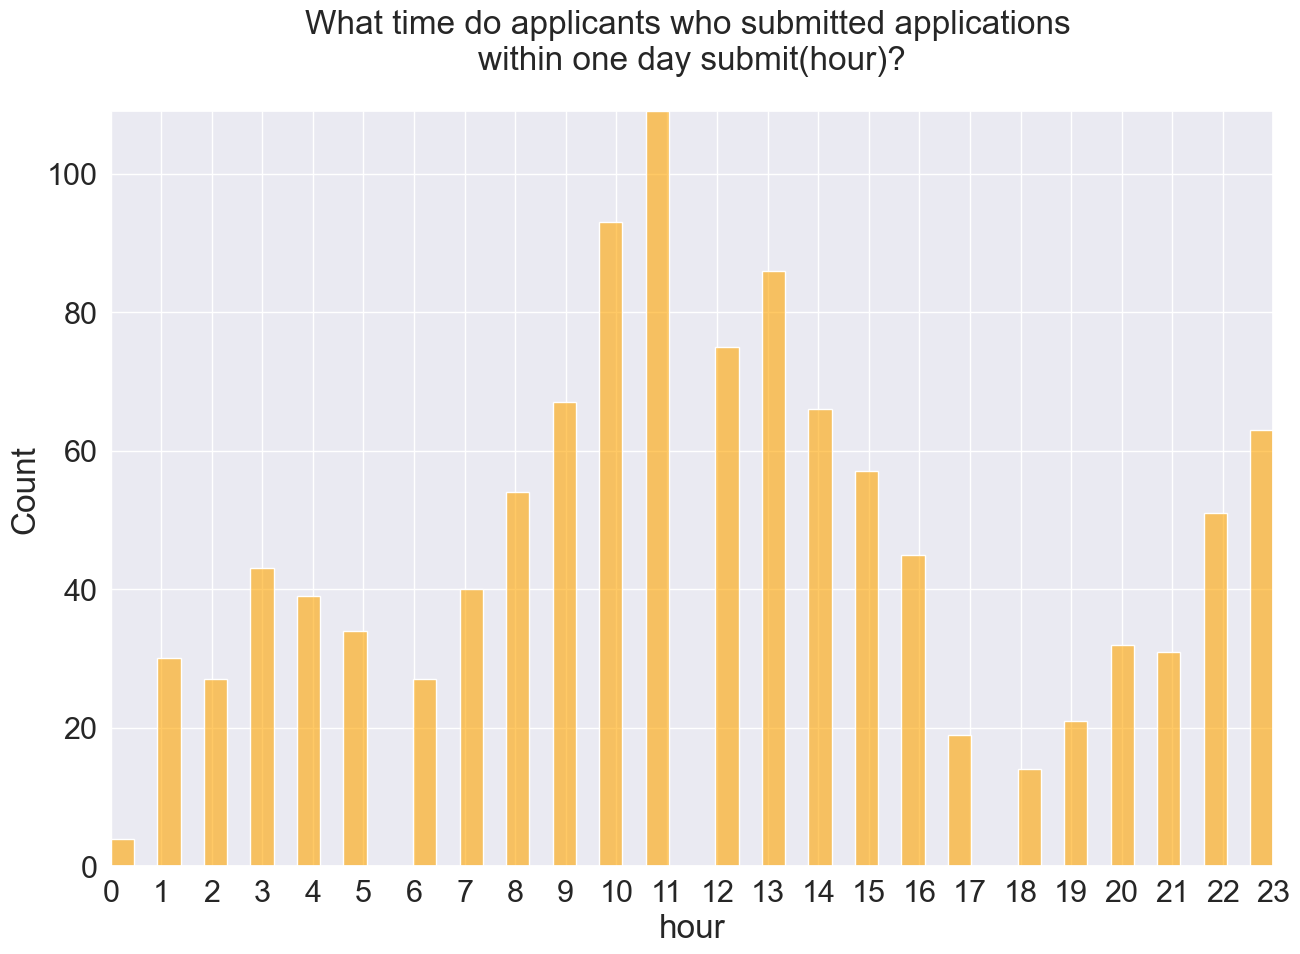

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.histplot(df_oneday['submit_hour'],bins=50,color="orange",alpha=0.6)
ax.set_xlabel("hour")
ax.set_title("What time do applicants who submitted applications \nwithin one day submit(hour)?")
plt.xticks([i for i in range(24)])
#plt.savefig("./submit_period(hour)")

In [ ]:
def urdecision(d1):
    if 'Admit' in d1:
        return 'Admit'
    elif 'Withdraw' in d1:
        return ''
    else:
        return 'Reject'

In [ ]:
def applicant_decision(d1,d2,d4):
    if d4=='':
        return 'Withdraw'
    elif d4=='Reject':
        return ''
    else:
        if d1=='Admit/Accept Offer' and d2=='Admit':
            return 'Accept'
        elif d1=='Admit/Defer':
            return 'Defer'
        elif d1=='Admit/Accept/Melt':
            return 'Melt'
        else:
            return 'Decline'

In [ ]:
df_decision = df_submit[~(df['Decision 1'].isnull())]
df_decision['UR_Decision'] = df_decision.apply(lambda x:urdecision(x['Decision 1']),axis=1)
df_decision['Applicant_Decision'] = df_decision.apply(lambda x: applicant_decision(x['Decision 1'],x['Decision 2'],x['UR_Decision'])
                                    ,axis=1)

Text(0.5, 1.0, 'How quickly do admitted and rejected \napplicants submit their applications')

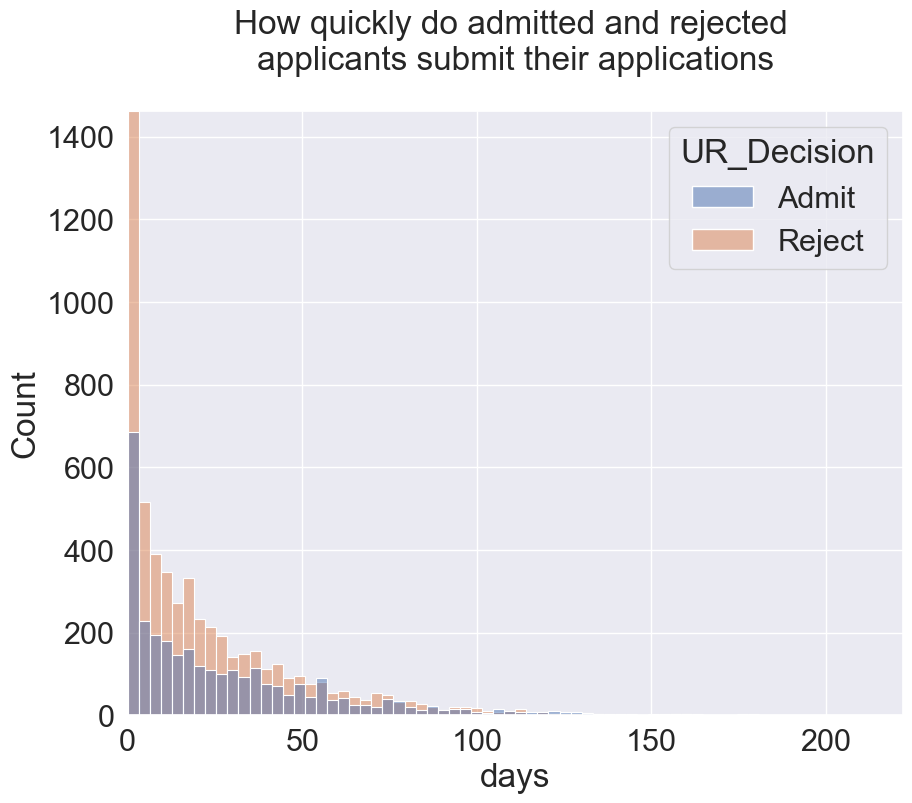

In [ ]:
plt.figure(figsize=(10,8), dpi=100)
ax = sns.histplot(df_decision[df_decision['UR_Decision']!=""],x='submit_period', hue='UR_Decision',bins=70)
ax.set_xlabel("days")
ax.set_title("How quickly do admitted and rejected \napplicants submit their applications")

In [ ]:
period_interval = ['<=15 days','15-30 days','30-45 days','45-60 days','>60 days']
china_period = [0]*5
for i in df_submit[df_submit['Citizenship1']=='China']['submit_period']:
    if i<=15:
        china_period[0] += 1
    elif 15<i<=30:
        china_period[1] += 1
    elif 30<i<=45:
        china_period[2] += 1
    elif 45<i<=60:
        china_period[3] += 1
    else:
        china_period[4] += 1


Text(0.5, 1.0, 'How quickly did Chinese applicants \nsubmit their applications')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


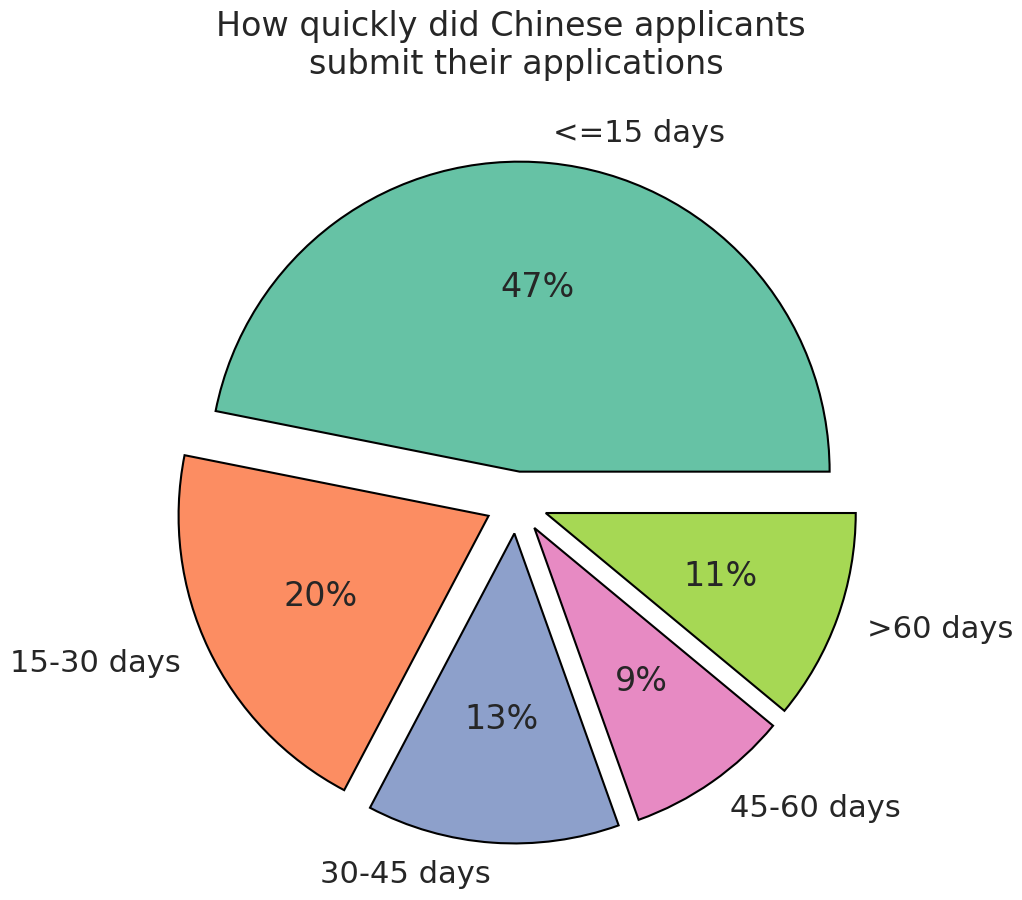

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.figure(figsize=(10,12), dpi=100)
palette_color = sns.color_palette('Set2')
plt.pie(china_period, labels=period_interval, colors=palette_color, autopct='%.0f%%',explode=(0.1, 0.1, 0.1, 0.1,0.1),wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.5,
                      'antialiased': True})
plt.title("How quickly did Chinese applicants \nsubmit their applications")
#plt.savefig("./submit_period_china")

In [ ]:
us_period = [0]*5
for i in df_submit[df_submit['Citizenship1']=='United States']['submit_period']:
    if i<=15:
        us_period[0] += 1
    elif 15<i<=30:
        us_period[1] += 1
    elif 30<i<=45:
        us_period[2] += 1
    elif 45<i<=60:
        us_period[3] += 1
    else:
        us_period[4] += 1

Text(0.5, 1.0, 'How quickly did American applicants \nsubmit their applications')

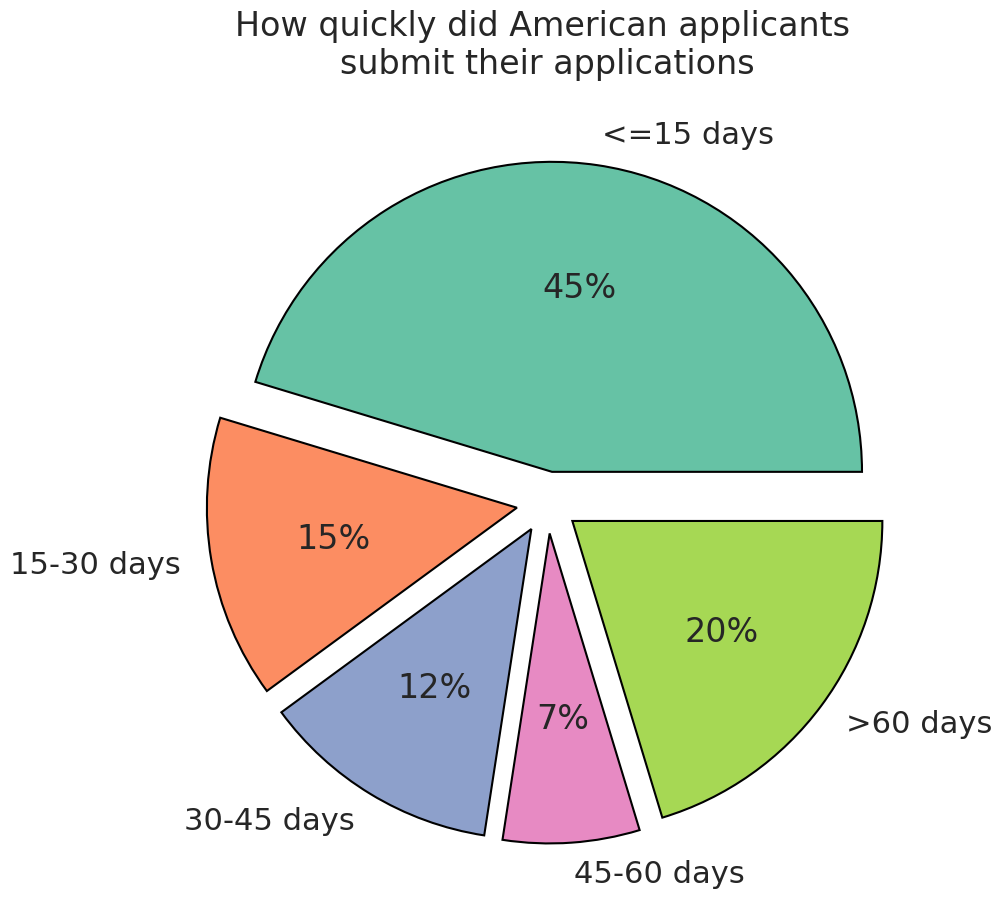

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.figure(figsize=(10,12), dpi=100)
palette_color = sns.color_palette('Set2')
plt.pie(us_period, labels=period_interval, colors=palette_color, autopct='%.0f%%',explode=(0.1, 0.1, 0.1, 0.1,0.1),wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.5,
                      'antialiased': True})
plt.title("How quickly did American applicants \nsubmit their applications")
#plt.savefig("./submit_period_us")

In [ ]:
india_period = [0]*5
for i in df_submit[df_submit['Citizenship1']=='India']['submit_period']:
    if i<=15:
        india_period[0] += 1
    elif 15<i<=30:
        india_period[1] += 1
    elif 30<i<=45:
        india_period[2] += 1
    elif 45<i<=60:
        india_period[3] += 1
    else:
        india_period[4] += 1

Text(0.5, 1.0, 'How quickly did Indian applicants \nsubmit their applications')

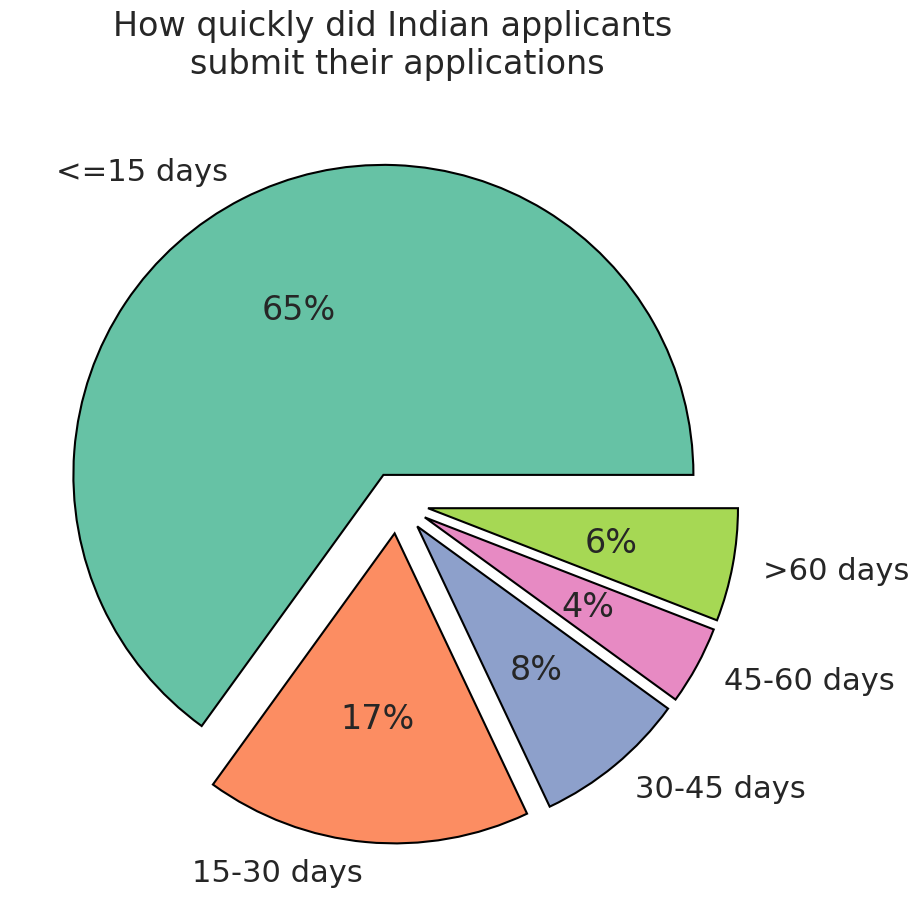

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
palette_color = sns.color_palette('Set2')
plt.figure(figsize=(10,12), dpi=100)
plt.pie(india_period, labels=period_interval, colors=palette_color, autopct='%.0f%%',explode=(0.1, 0.1, 0.1, 0.1,0.1),wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.5,
                      'antialiased': True})
plt.title("How quickly did Indian applicants \nsubmit their applications")
#plt.savefig("./submit_period_india")

In [ ]:
# the time spent on application for admitted applicants
ad_period = [0]*5
for i in df_decision[df_decision['UR_Decision']=='Admit']['submit_period']:
    if i<=15:
        ad_period[0] += 1
    elif 15<i<=30:
        ad_period[1] += 1
    elif 30<i<=45:
        ad_period[2] += 1
    elif 45<i<=60:
        ad_period[3] += 1
    else:
        ad_period[4] += 1

total = sum(ad_period)
for i in range(5):
    ad_period[i]/=total

In [ ]:
# time spent on application for rejected applicants
re_period = [0]*5
for i in df_decision[df_decision['UR_Decision']=='Reject']['submit_period']:
    if i<=15:
        re_period[0] += 1
    elif 15<i<=30:
        re_period[1] += 1
    elif 30<i<=45:
        re_period[2] += 1
    elif 45<i<=60:
        re_period[3] += 1
    else:
        re_period[4] += 1

total = sum(re_period)
for i in range(5):
    re_period[i]/=total

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


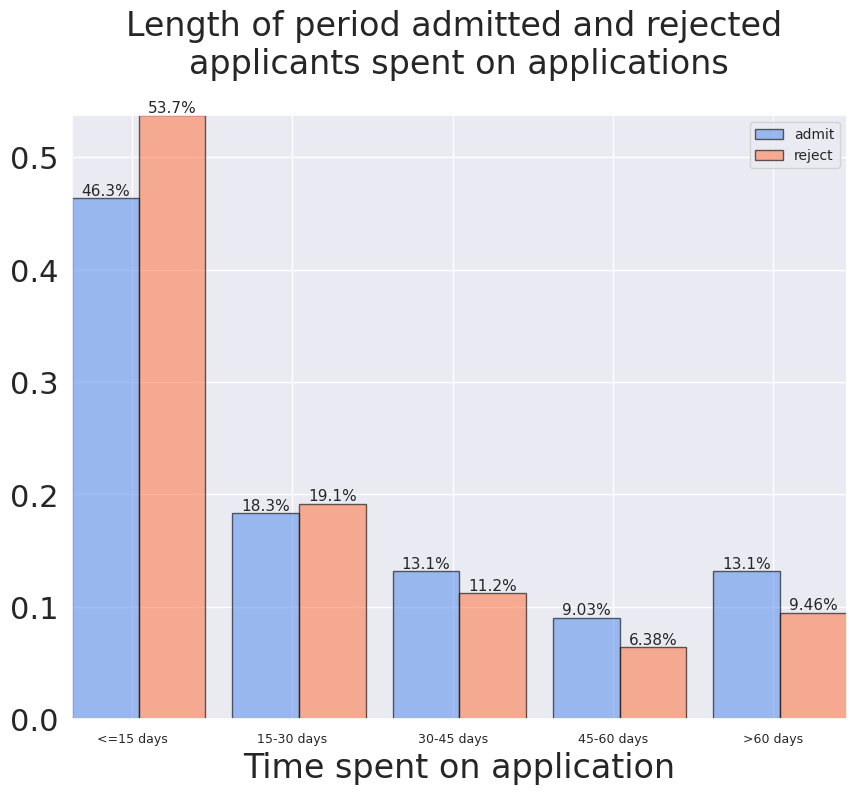

In [ ]:
x1 = [i*1.2 for i in range(5)]
x2 = [i+0.5 for i in x1]
plt.figure(figsize=(10,8), dpi=100)
for i in range(5):
    plt.bar(i*1.2,ad_period[i],width=0.5,color='cornflowerblue',label='admit', alpha=0.6, edgecolor='black')
    plt.bar(0.5+i*1.2,re_period[i],width=0.5,color='coral',label='reject', alpha=0.6, edgecolor='black')
for a,b in zip(x1, ad_period):
    plt.text(a,b,
             str(b*100)[:4]+'%',
             ha='center', 
             va='bottom',
            fontsize=11)
for a,b in zip(x1, re_period):
    plt.text(a+0.5,b,
             str(b*100)[:4]+'%',
             ha='center', 
             va='bottom',
            fontsize=11)
mid = [0.2,1.4,2.6,3.8,5]
plt.xticks(mid,period_interval,fontsize=9)
plt.xlabel("Time spent on application")
plt.title("Length of period admitted and rejected \napplicants spent on applications")
plt.legend(['admit','reject'],fontsize=10,loc='upper right')
#plt.savefig("./submit_period_decision")

### Are applications complete with references when they are submitted?

In [ ]:
df_reference = df_submit[(~df_submit['Recommender 1 Date/Time'].isnull())&(~df_submit['Recommender 2 Date/Time'].isnull())
&(~df_submit['Recommender 3 Date/Time'].isnull())]

In [ ]:
# number of references before submission
def reference(f1,f2,f3,submit):
    l = sorted([f1,f2,f3])
    if l[2]<=submit:
        return 3
    elif l[1]<=submit:
        return 2
    elif l[0]<=submit:
        return 1
    else:
        return 0

In [ ]:
df_reference['reference_num'] = df_reference.apply(lambda x:reference(x['Recommender 1 Date/Time'],x['Recommender 2 Date/Time'],
                                                                      x['Recommender 3 Date/Time'],x['Submitted']),axis=1)

Text(0.5, 1.0, 'The number of references completed before submission')

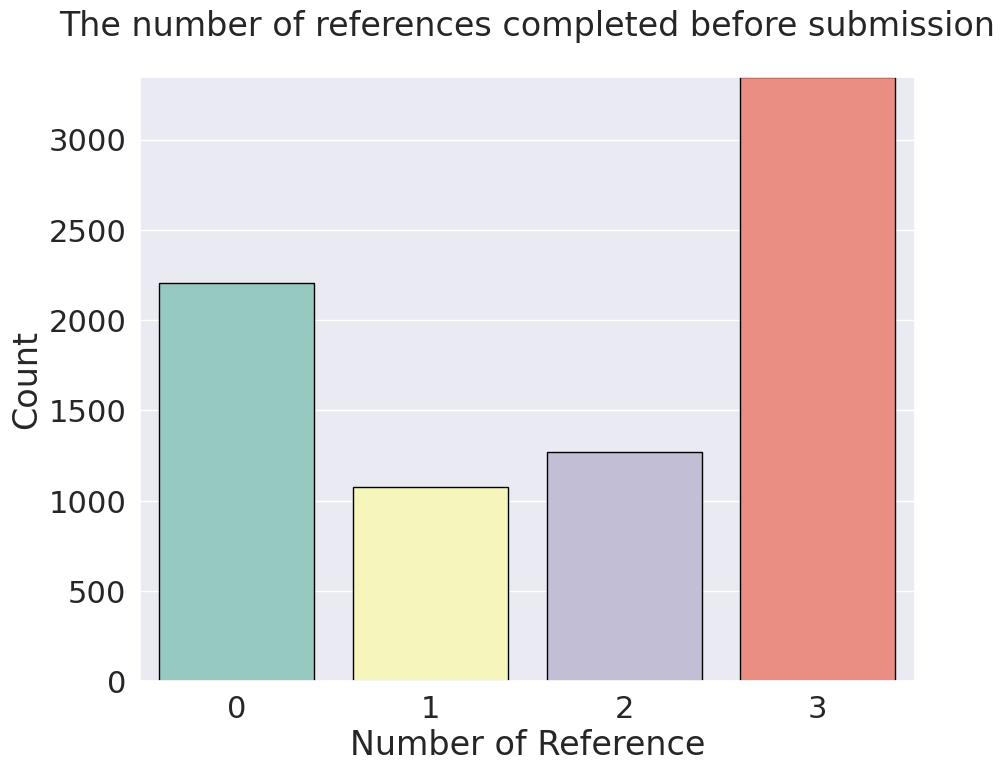

In [ ]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.figure(figsize=(10,8))
palette_color = sns.color_palette('Set3')
sns.countplot(x='reference_num',data=df_reference, palette='Set3', edgecolor='black')
plt.xlabel('Number of Reference')
plt.ylabel('Count')
plt.title("The number of references completed before submission")
#plt.savefig("./completed_references")

In [ ]:
df_decision2 = df_decision[(~df_decision['Recommender 1 Date/Time'].isnull())&(~df_decision['Recommender 2 Date/Time'].isnull())
&(~df_decision['Recommender 3 Date/Time'].isnull())]

In [ ]:
df_decision2 = df_decision2[df_decision2['UR_Decision']!=""]

In [ ]:
df_decision2['reference_num'] = df_decision2.apply(lambda x:reference(x['Recommender 1 Date/Time'],x['Recommender 2 Date/Time'],
                                                                      x['Recommender 3 Date/Time'],x['Submitted']),axis=1)

In [ ]:
# number of completed references before submission for admitted ones
ad_reference = [0]*4
for i in df_decision2[df_decision2['UR_Decision']=='Admit']['reference_num']:
    if i==0:
        ad_reference[0] += 1
    elif i==1:
        ad_reference[1] += 1
    elif i==2:
        ad_reference[2] += 1
    else:
        ad_reference[3] += 1
a = sum(ad_reference)
for i in range(4):
    ad_reference[i] /= a

In [ ]:
# number of completed references before submission for rejected ones
re_reference = [0]*4
for i in df_decision2[df_decision2['UR_Decision']=='Reject']['reference_num']:
    if i==0:
        re_reference[0] += 1
    elif i==1:
        re_reference[1] += 1
    elif i==2:
        re_reference[2] += 1
    else:
        re_reference[3] += 1
r = sum(re_reference)
for i in range(4):
    re_reference[i] /= r

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


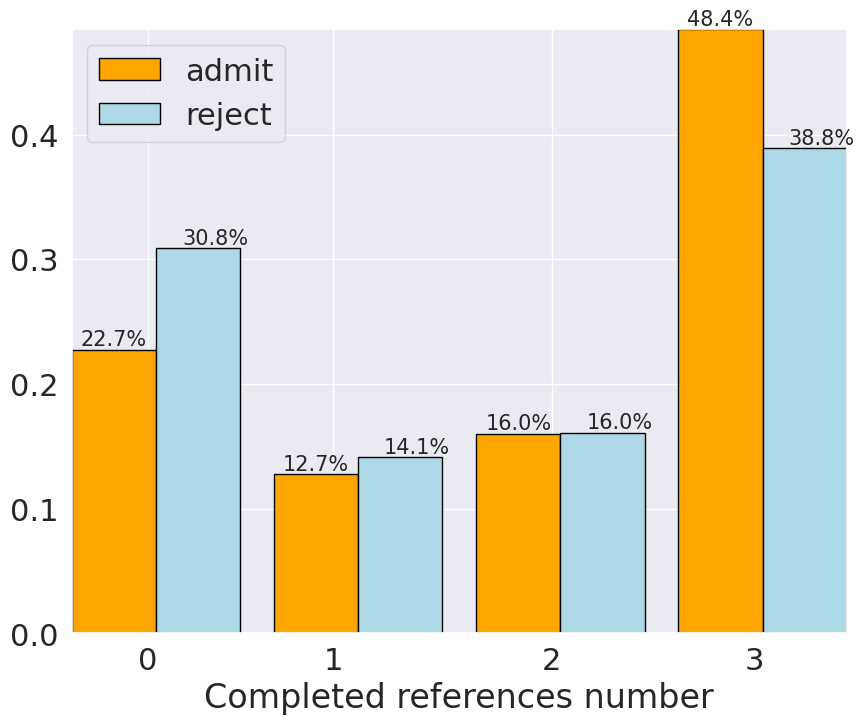

In [ ]:
x1 = [i*1.2 for i in range(4)]
x2 = [i+0.5 for i in x1]
plt.figure(figsize=(10,8))
plt.bar(x1,ad_reference,width=0.5,color='orange',label='admit', edgecolor='black')
plt.bar(x2,re_reference,width=0.5,color='lightblue',label='reject', edgecolor='black')
for a,b in zip(x1, ad_reference):
    plt.text(a,b,
             str(b*100)[:4]+'%',
             ha='center', 
             va='bottom',
            fontsize=15)
for a,b in zip(x2, re_reference):
    plt.text(a+0.1,b,
             str(b*100)[:4]+'%',
             ha='center', 
             va='bottom',
            fontsize=15)
mid = [0.2,1.3,2.6,3.8]
plt.xticks(mid,[str(i) for i in range(4)])
plt.xlabel("Completed references number")
#plt.title("The number of completed references before \nsubmission for admitted and rejected students")
plt.legend()
plt.savefig("./Fig/ref_decision.png")

In [ ]:
ece_reference = df_reference[df_reference['Program (ASE)']=='Electrical and Computer Engineering']['reference_num'].value_counts()
total = sum(ece_reference)
ece_ref = []
for i in range(len(ece_reference)):
    ece_ref.append(ece_reference[i]/total)

In [ ]:
cs_reference = df_reference[df_reference['Program (ASE)']=='Computer Science']['reference_num'].value_counts()
total = sum(cs_reference)
cs_ref = []
for i in range(len(cs_reference)):
    cs_ref.append(cs_reference[i]/total)

In [ ]:
ds_reference = df_reference[df_reference['Program (ASE)']=='Data Science']['reference_num'].value_counts()
total = sum(ds_reference)
ds_ref = []
for i in range(len(ds_reference)):
    ds_ref.append(ds_reference[i]/total)

In [ ]:
table = pd.DataFrame()
table['percent'] = ece_ref+cs_ref+ds_ref
table['ref_num'] = [i for i in range(4)]+[i for i in range(4)]+[i for i in range(4)]
table['program'] = ['ece']*4+['cs']*4+['ds']*4

In [ ]:
def show_values(axs, orient="v", space=.1):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.03)
                value = str(p.get_height()*100)[:4]+'%'
                ax.text(_x, _y, value, ha="center",fontsize=6) 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = str(p.get_width()*100)[:4]+'%'
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

Text(0, 0.5, 'Percent')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


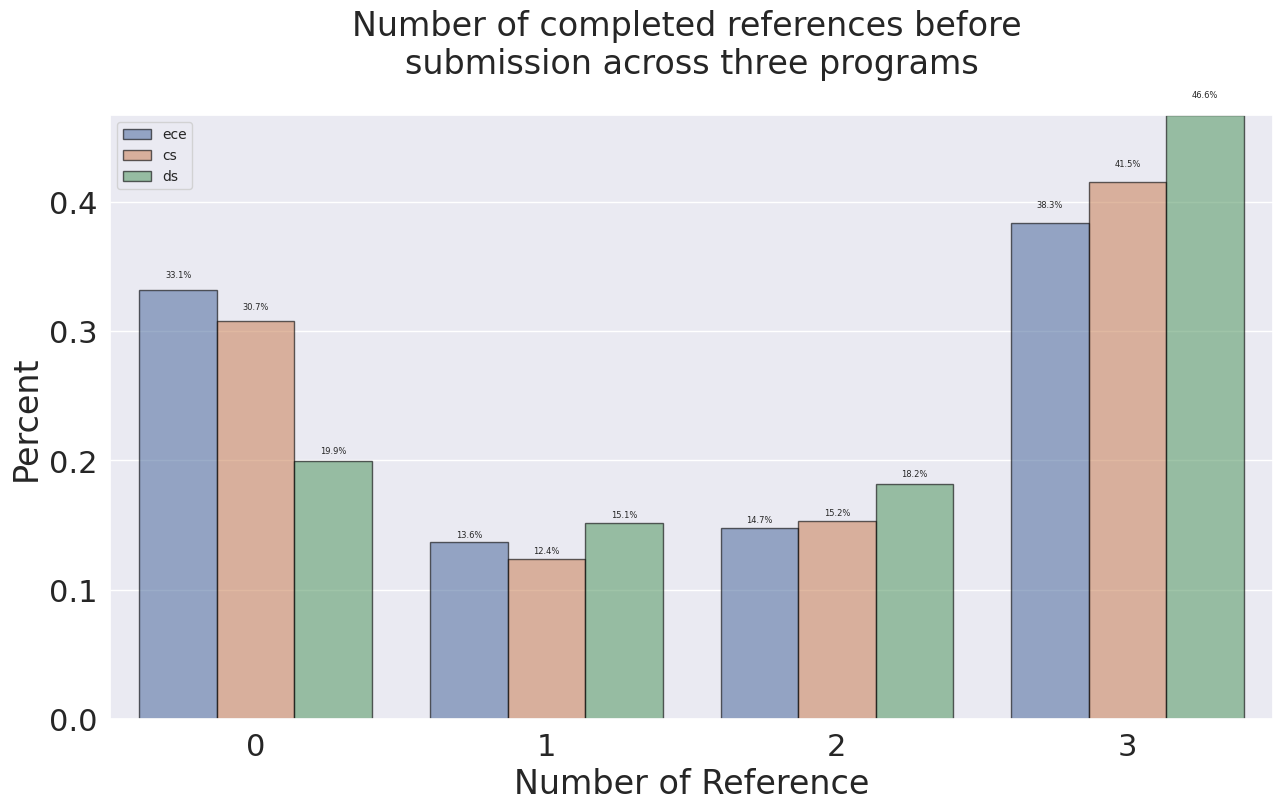

In [ ]:

plt.figure(figsize=(15,8))
graph = sns.barplot(x='ref_num', y='percent', data=table, hue='program', edgecolor='black', alpha=0.6)
show_values(graph,'v',space=0.8)
plt.title("Number of completed references before \nsubmission across three programs")
plt.legend(fontsize=10)
plt.xlabel('Number of Reference')
plt.ylabel('Percent')
#plt.savefig("./reference_program")

### What can you tell me about people who procrastinate submitting vs those who complete quickly? Those who start early vs those who start close to the deadline?

In [ ]:
df = df[df['Degree']=='Master\'s']
df = df[df['Time Status']=='Full Time']

In [ ]:
df_submit['submit_period'] = df_submit.apply(lambda a:submit_period(a.Created, a.Submitted), axis=1)

In [ ]:
frames = [df, df_submit]
df = pd.concat(frames)

In [ ]:
df["submit_period"].describe()

count    8665.000000
mean       24.499019
std        28.111509
min         0.000000
25%         4.000000
50%        15.000000
75%        36.000000
max       222.000000
Name: submit_period, dtype: float64

In [ ]:
slow_apply = df[(df['submit_period'] > 36)]
quick_apply = df[(df['submit_period'] < 4)]

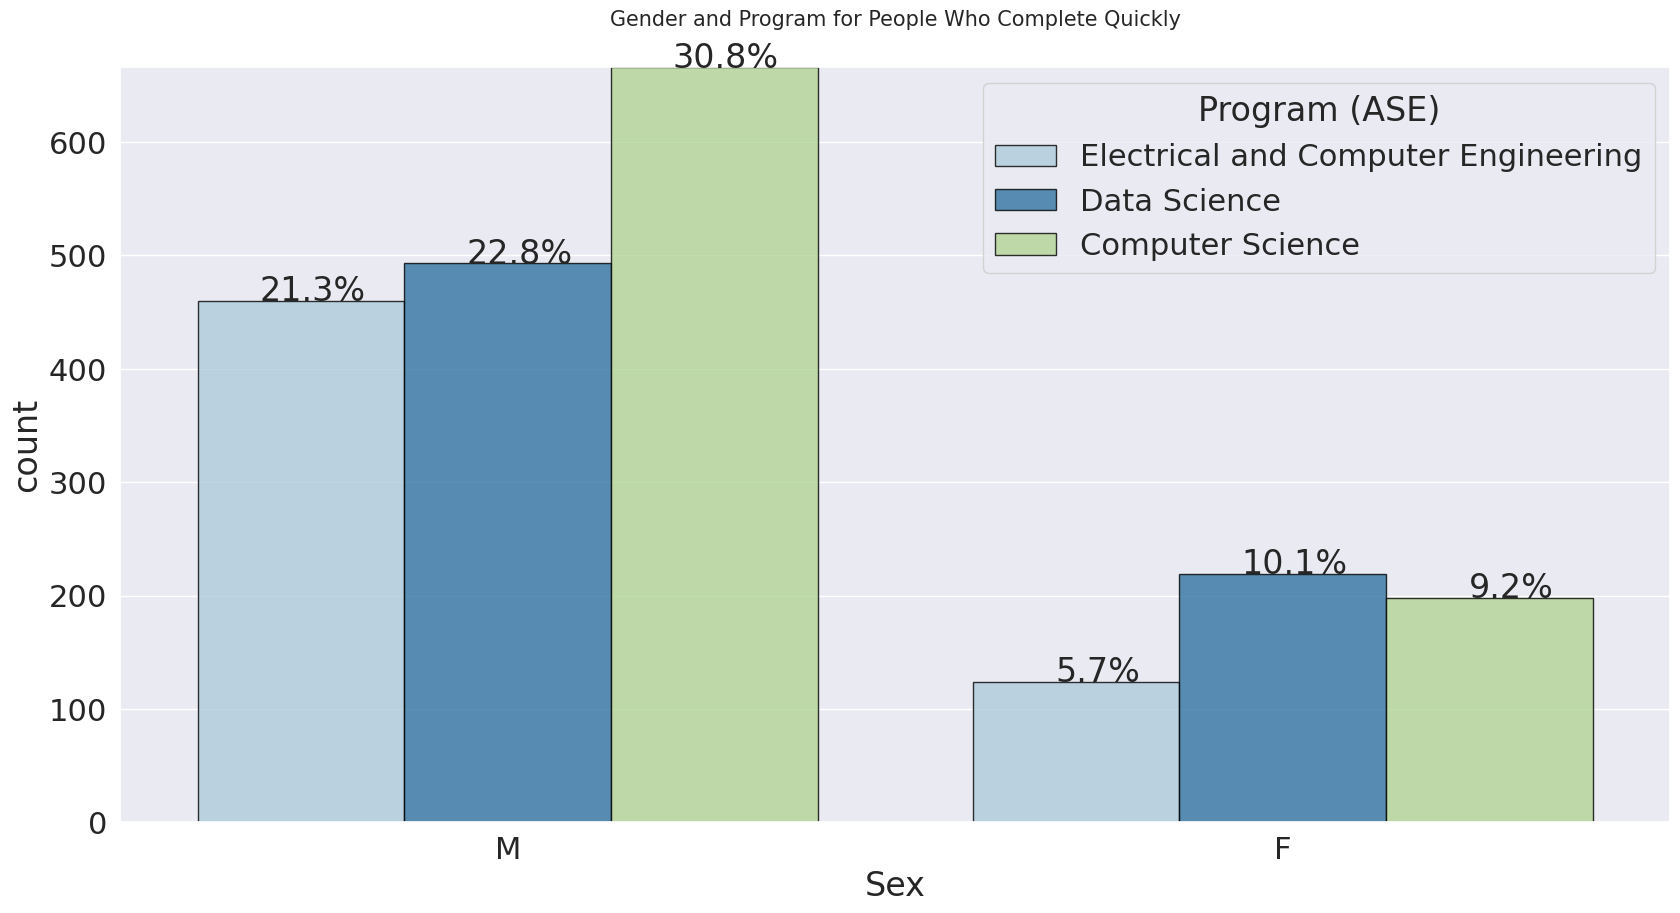

In [ ]:
#sns.set(style="whitegrid")

sns.set_palette("Paired")
plt.figure(figsize=(20,10))
total = float(len(quick_apply))
ax = sns.countplot(x="Sex", hue="Program (ASE)", data=quick_apply, edgecolor='black', alpha=0.8)
plt.title('Gender and Program for People Who Complete Quickly', fontsize=15)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() -0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

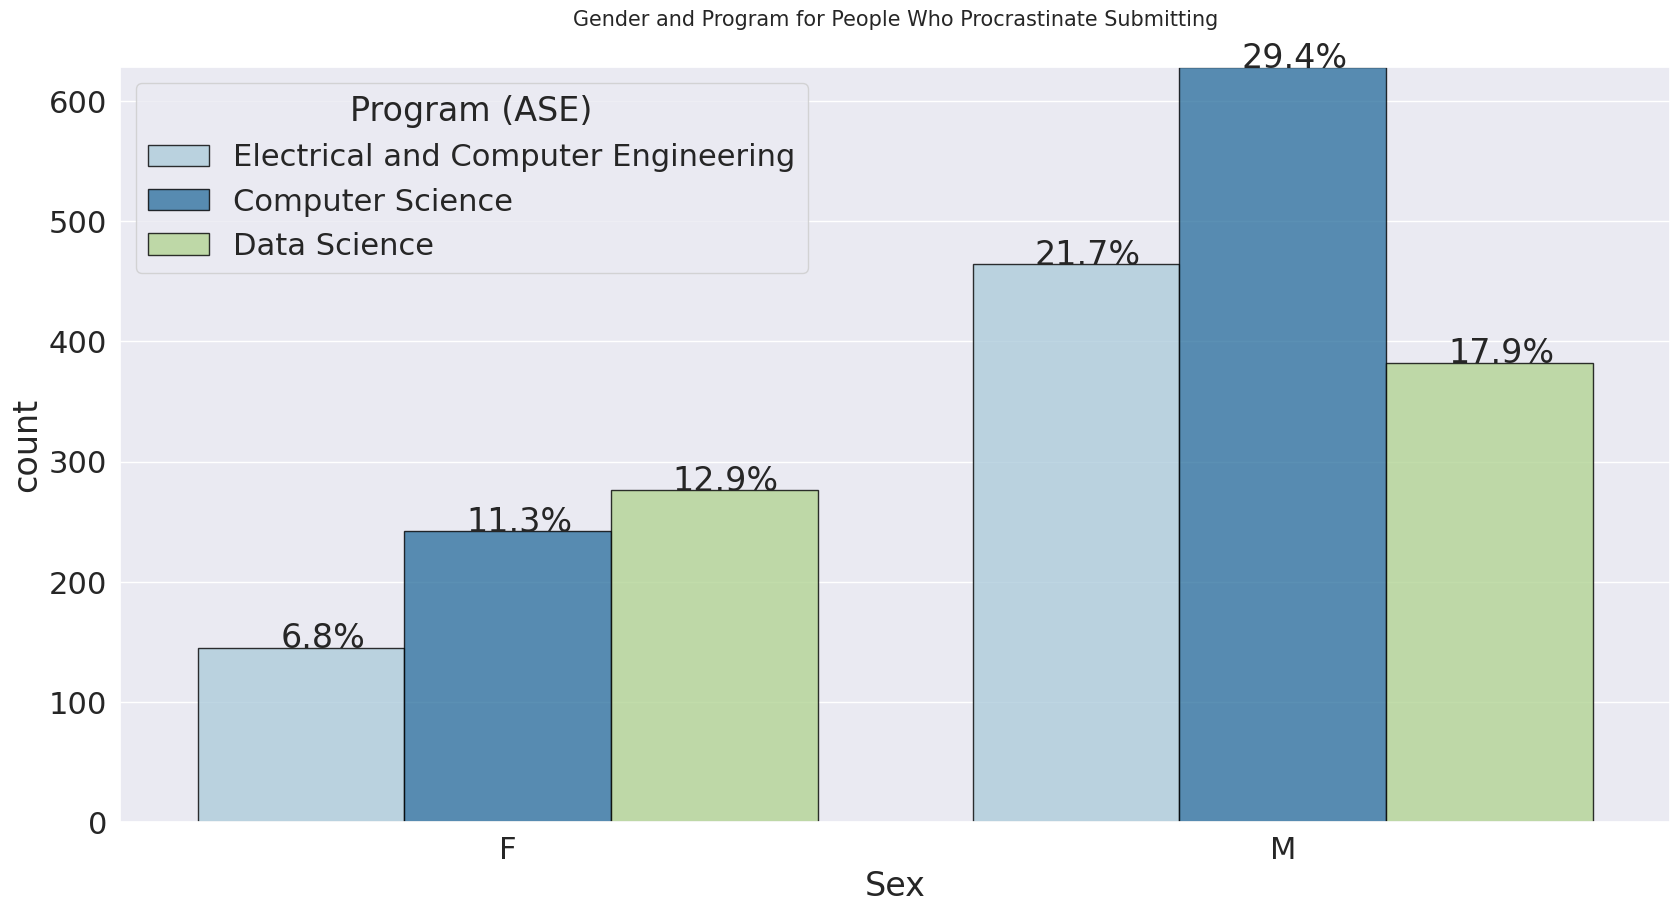

In [ ]:
sns.set_palette("Paired")
plt.figure(figsize=(20,10))
total = float(len(slow_apply))
ax = sns.countplot(x="Sex", hue="Program (ASE)", data=slow_apply, edgecolor='black', alpha=0.8)
plt.title('Gender and Program for People Who Procrastinate Submitting', fontsize=15)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

In [ ]:
df['created_month'] = df['Created'].dt.month
sns.set_palette("Paired")
early_create = df.loc[df['created_month'].isin([3, 4, 5, 6,7])]
late_create = df.loc[df['created_month'].isin([2])]

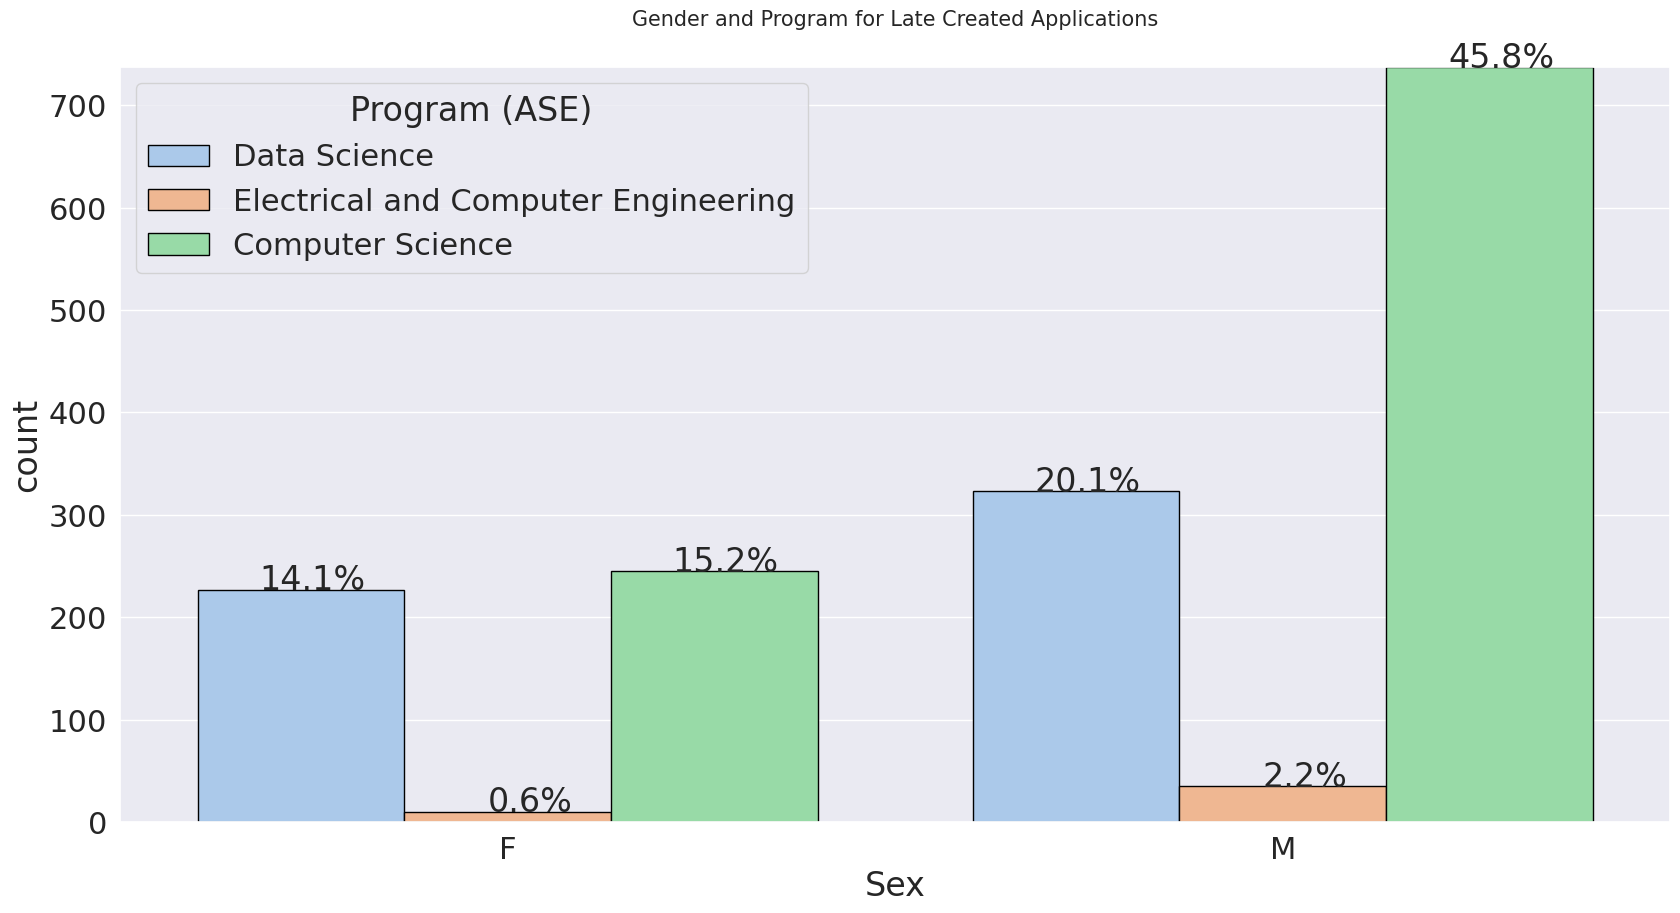

In [ ]:
#sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(20,10))
total = float(len(late_create))
ax = sns.countplot(x="Sex", hue="Program (ASE)", data=late_create, edgecolor='black')
plt.title('Gender and Program for Late Created Applications', fontsize=15)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() -0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

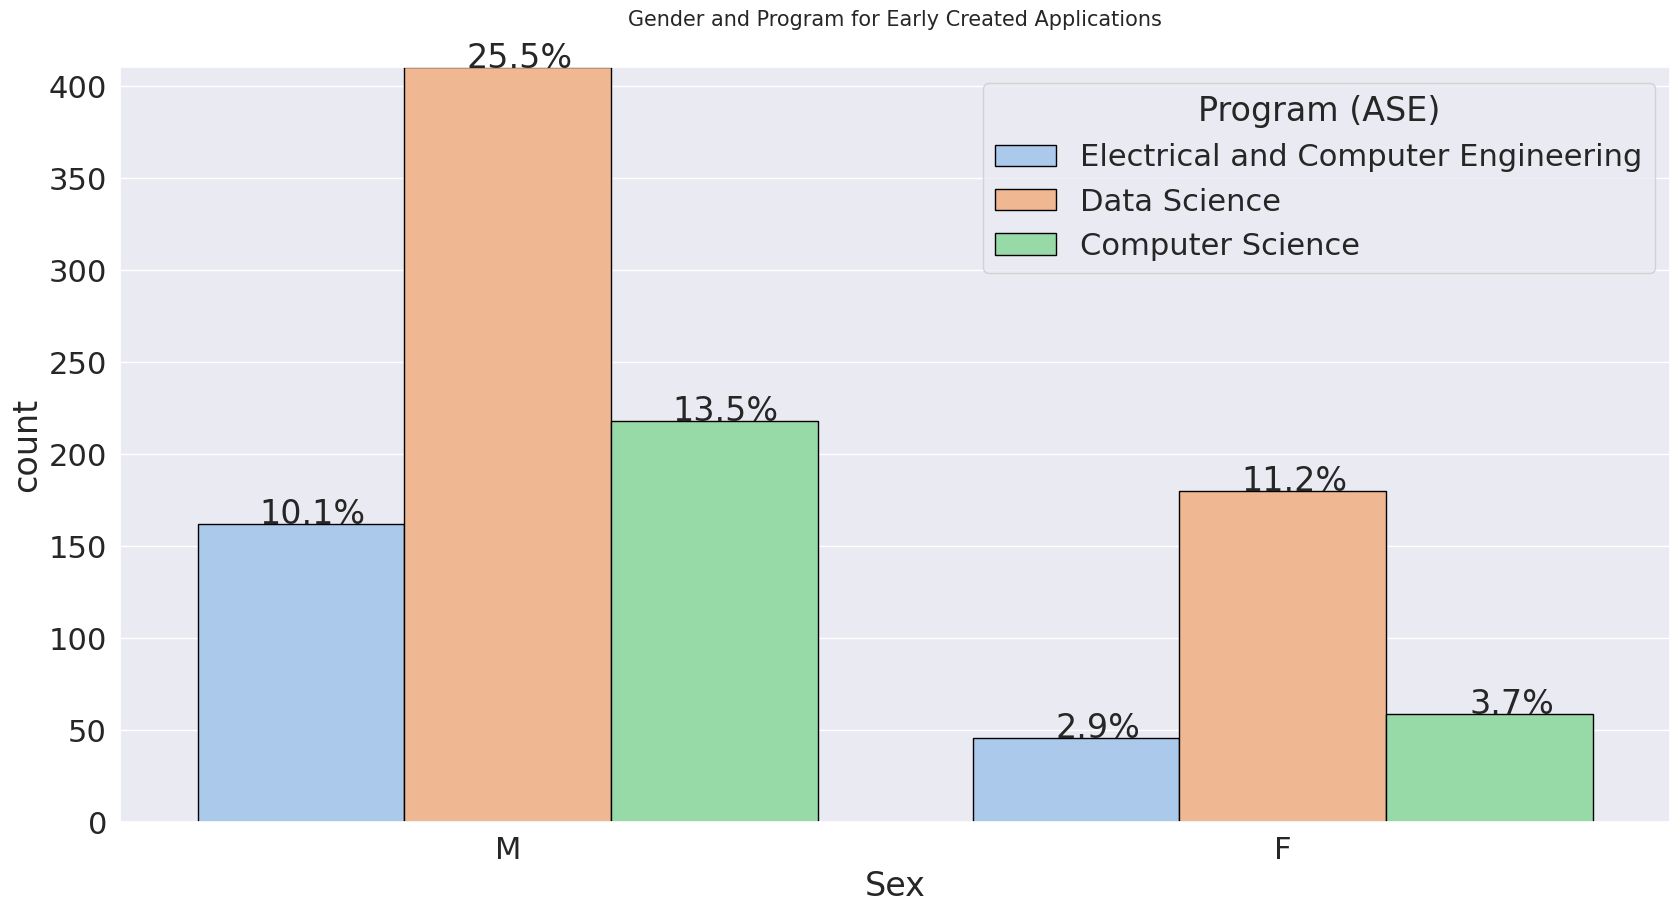

In [ ]:
#sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(20,10))
total = float(len(late_create))
ax = sns.countplot(x="Sex", hue="Program (ASE)", data=early_create, edgecolor='black')
plt.title('Gender and Program for Early Created Applications', fontsize=15)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() -0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


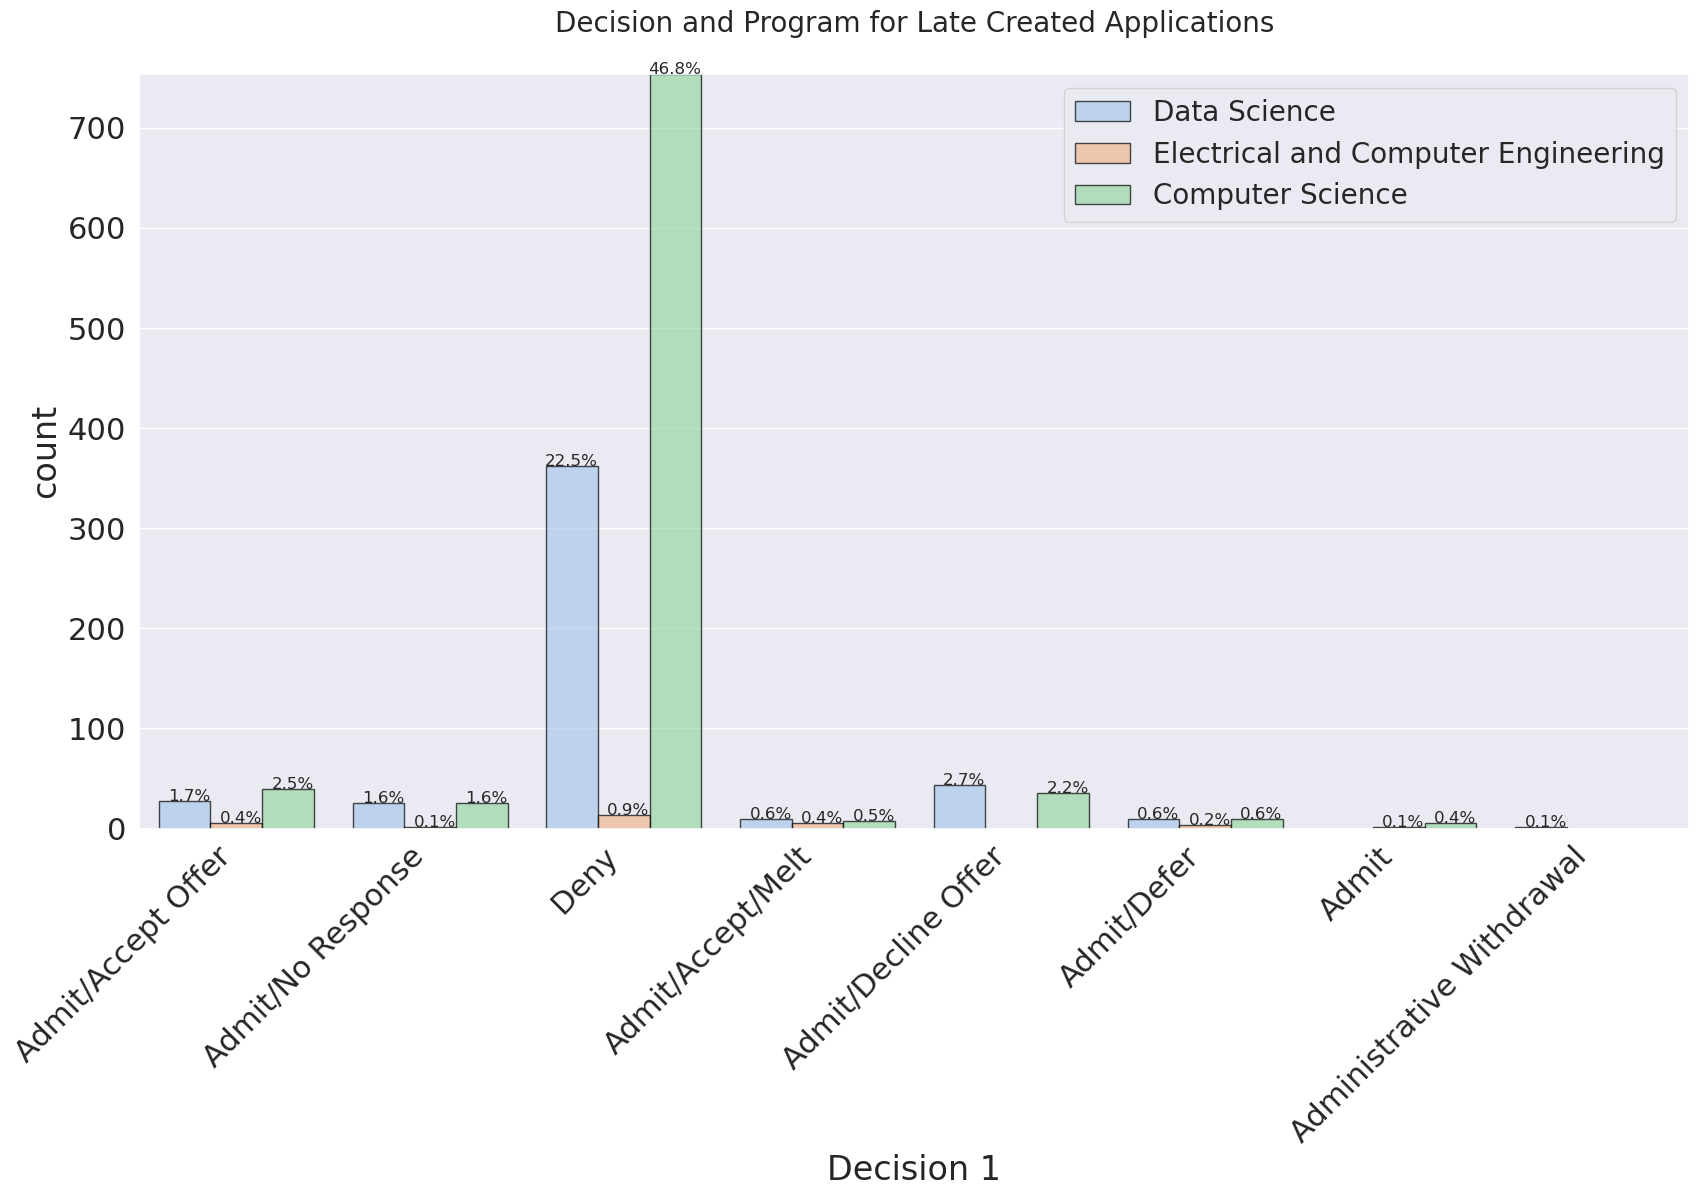

In [ ]:
#sns.set(style="whitegrid")
#sns.set_palette("pastel")
plt.figure(figsize=(20,10), dpi=100)
total = float(len(late_create))
ax = sns.countplot(x="Decision 1", hue="Program (ASE)", data=late_create, alpha=0.7, edgecolor='black')
plt.title('Decision and Program for Late Created Applications', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right',fontsize=12)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-small'
    )
plt.legend(fontsize=20,loc='upper right')
plt.show()

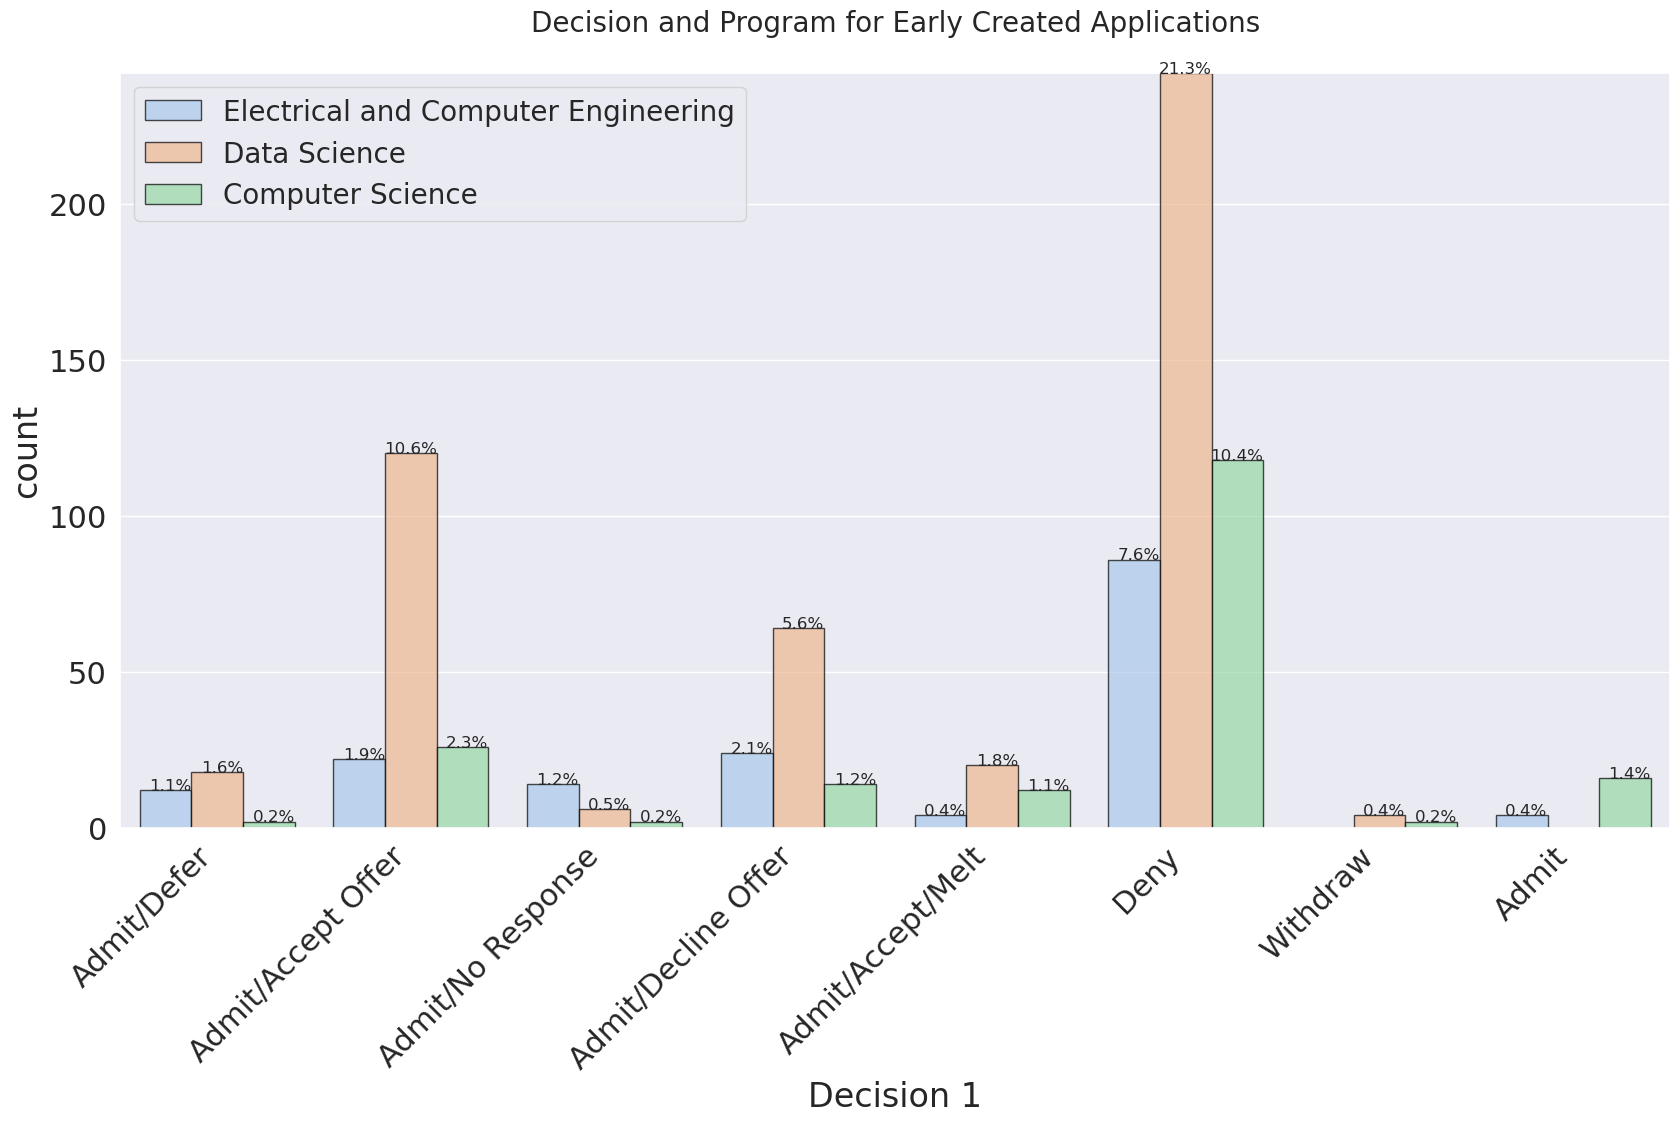

In [ ]:
#sns.set(style="whitegrid")
#sns.set_palette("pastel")
plt.figure(figsize=(20,10),dpi=100)
total = float(len(early_create))
ax = sns.countplot(x="Decision 1", hue="Program (ASE)", data=early_create, alpha=0.7, edgecolor='black')
plt.title('Decision and Program for Early Created Applications', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right',fontsize=12)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-small'
    )
plt.legend(fontsize=20,loc='upper left')
plt.show()

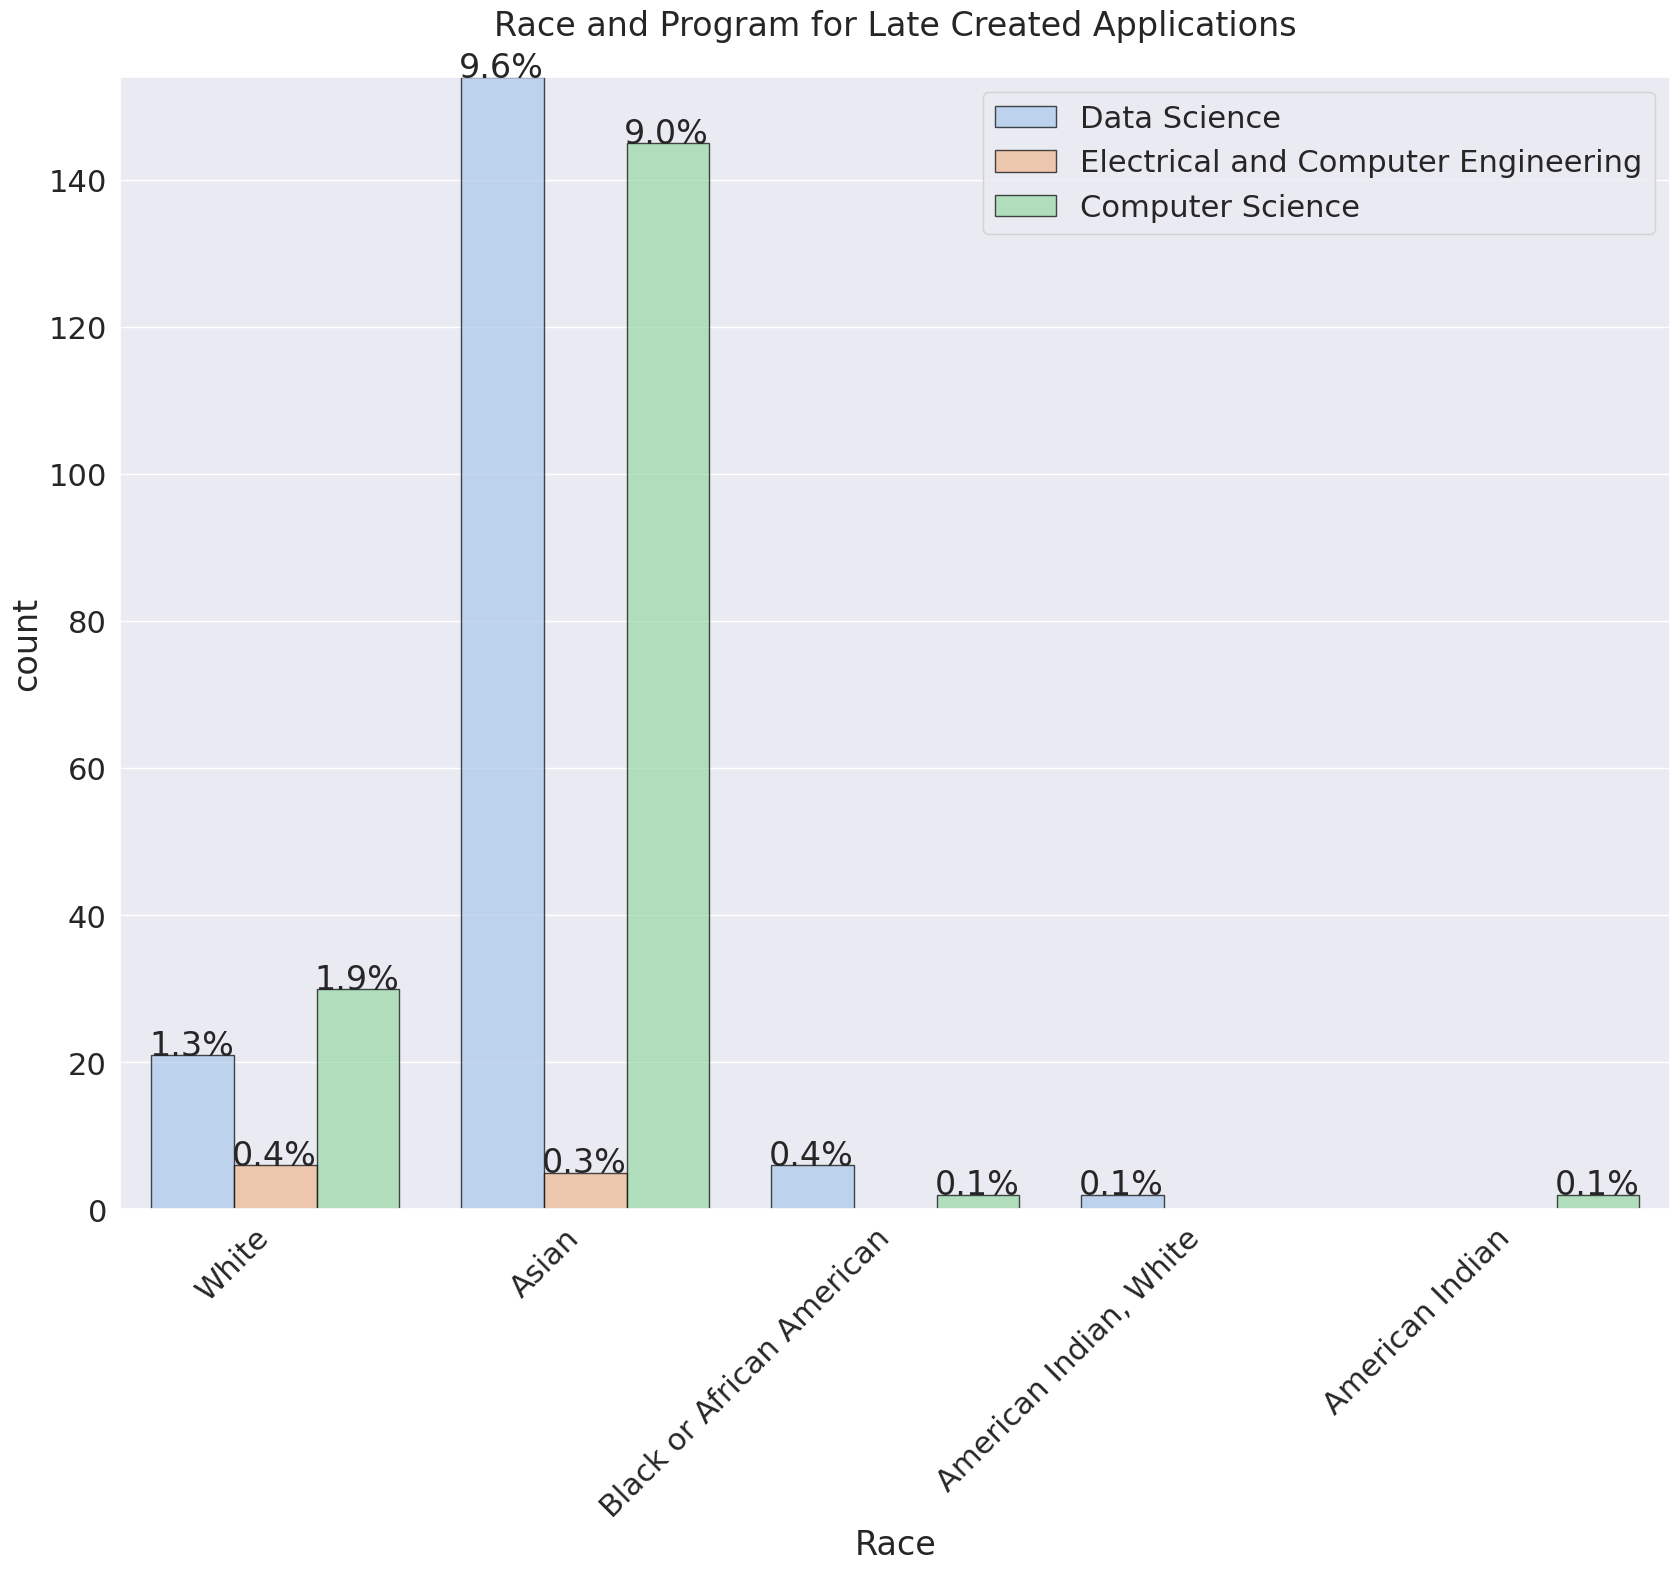

In [ ]:
#sns.set(style="whitegrid")
#sns.set_palette("pastel")
plt.figure(figsize=(20,15),dpi=100)
total = float(len(late_create))
ax = sns.countplot(x="Race", hue="Program (ASE)", data=late_create, alpha=0.7, edgecolor='black')
plt.title('Race and Program for Late Created Applications')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-small'
    )
plt.legend(loc='upper right')
plt.show()

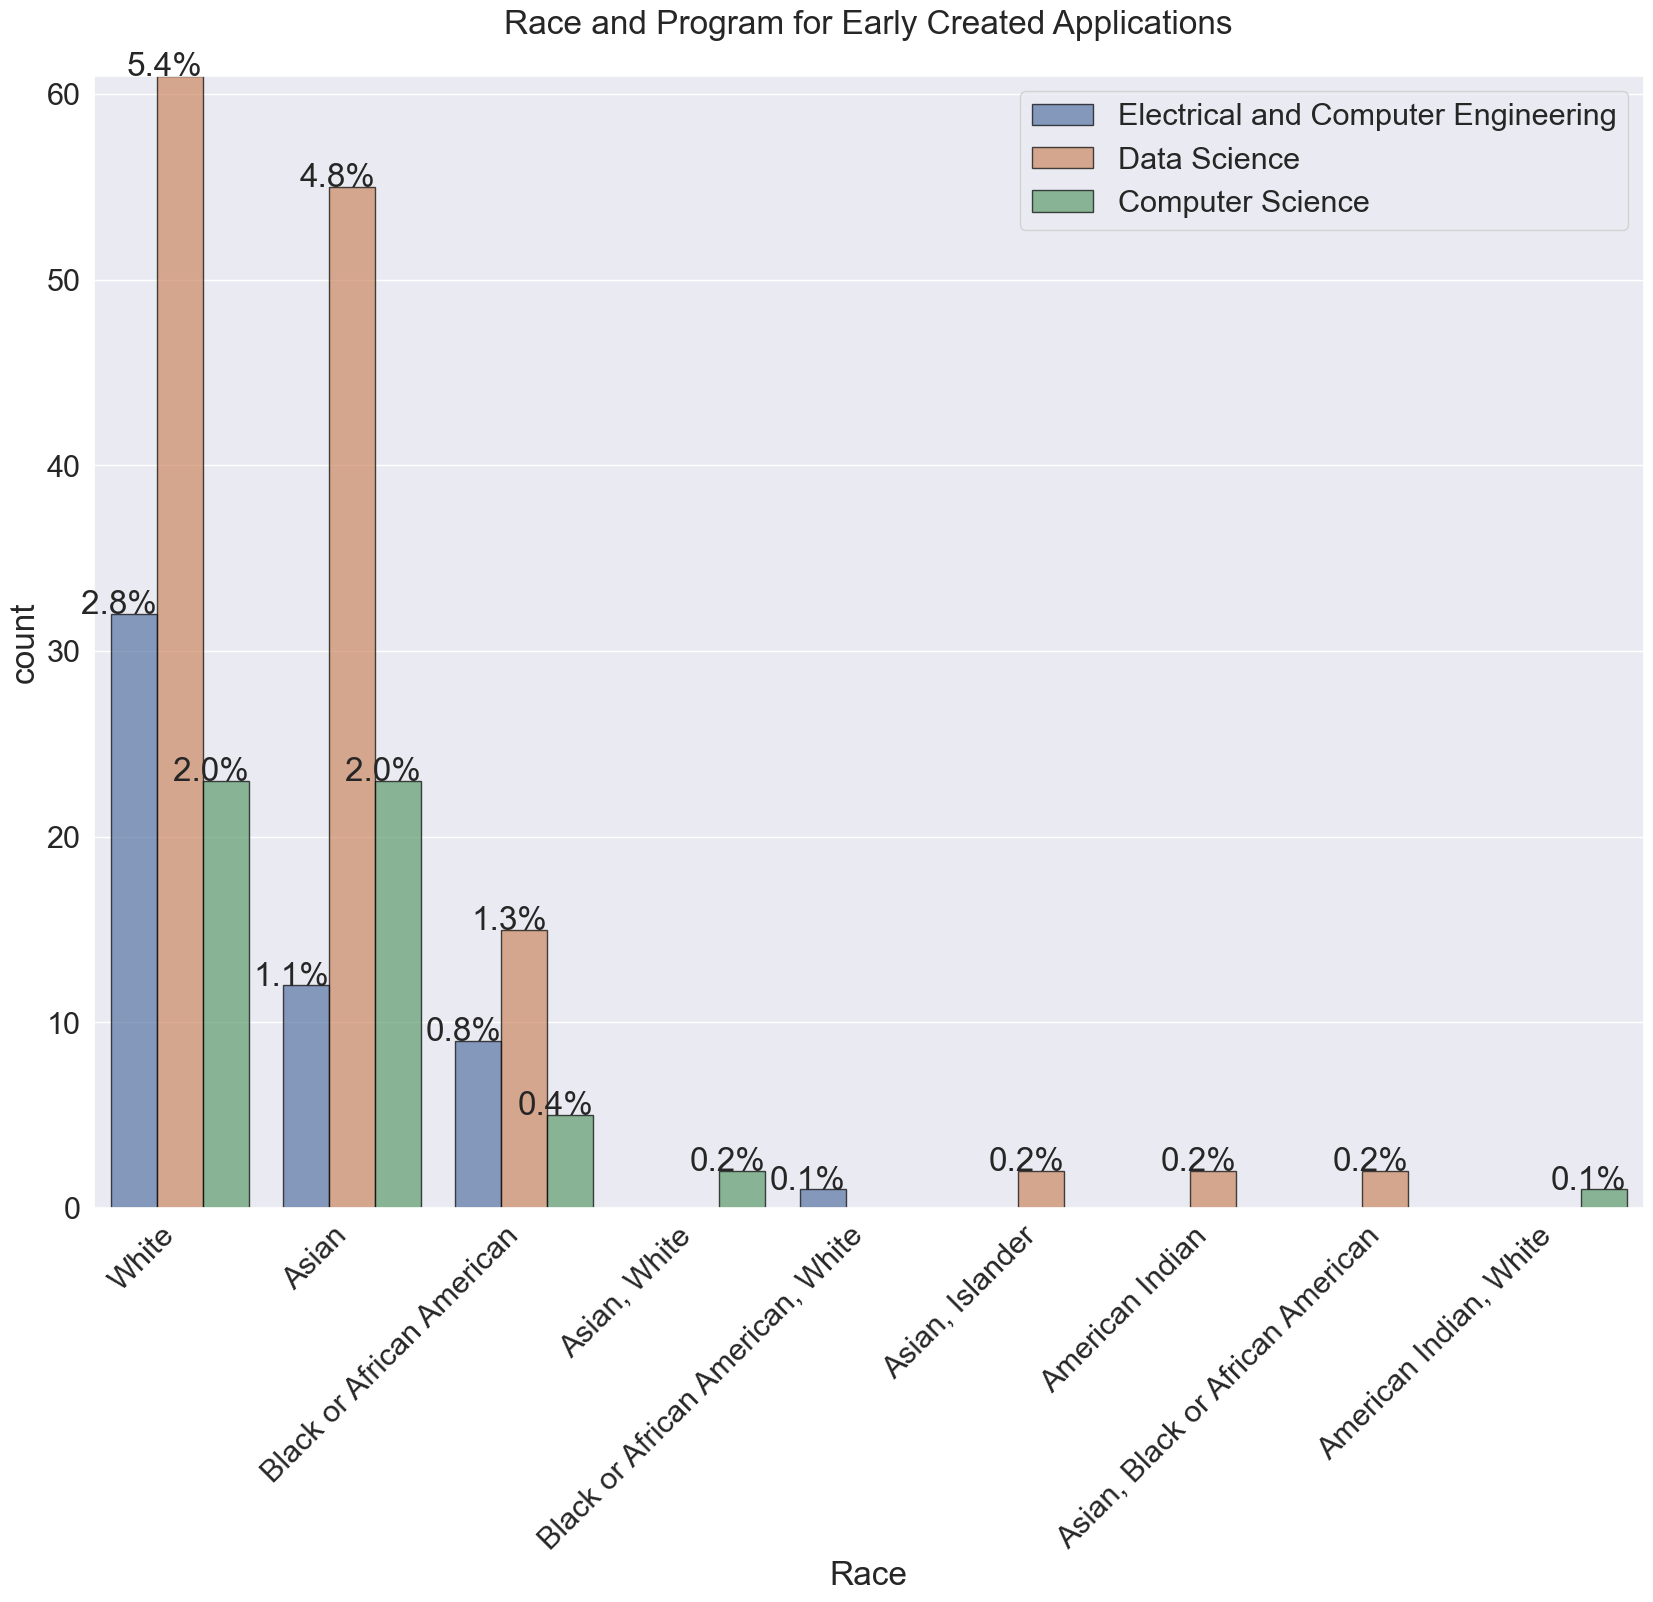

In [ ]:
#sns.set(style="whitegrid")
#sns.set_palette("pastel")
sns.set(font_scale=2)

plt.figure(figsize=(20,15),dpi=100)
total = float(len(early_create))
ax = sns.countplot(x="Race", hue="Program (ASE)", data=early_create, alpha=0.7, edgecolor='black')
plt.title('Race and Program for Early Created Applications')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    #fontsize='x-small'
    )
plt.legend(loc='upper right')
plt.show()

In [ ]:
category = pd.cut(df.submit_period,bins=[0,4,37,231],labels=['quick','average','procrastinate'])
df.insert(4,'TypesApplicants',category)

In [ ]:
df = df[df['TypesApplicants'].notna()]

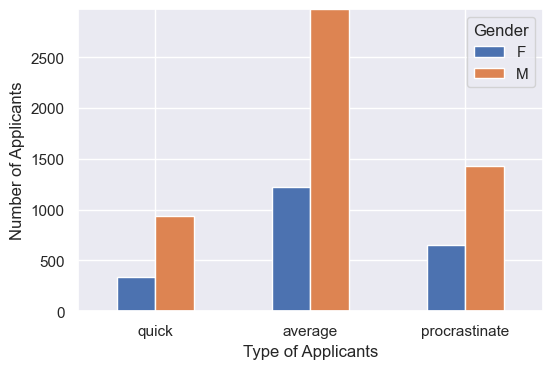

In [ ]:
sns.set(font_scale=1)
df['Gender']=df['Sex']
gender_column = df.Gender
#plt.figure(figsize=(20,20),dpi=100)
df.groupby(["TypesApplicants", gender_column]).size().unstack(level=1).plot(kind='bar',rot=0)
plt.xlabel('Type of Applicants')
plt.ylabel('Number of Applicants')
#plt.title('Gender of Different Types of Applicants')
plt.savefig('Fig/typeapplicant.png', bbox_inches = 'tight')


Text(0.5, 1.0, 'Gender of Different Types of Applicatants')

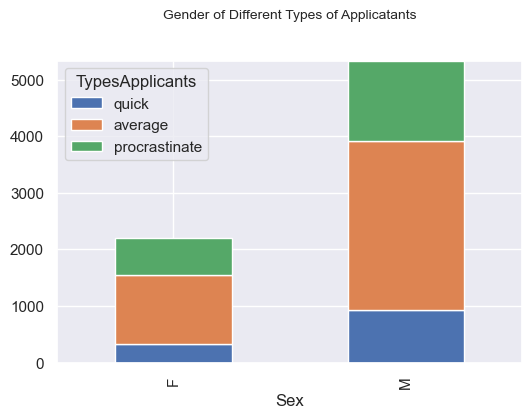

In [ ]:
df.groupby(['Sex', 'TypesApplicants']).size().unstack().plot.bar(stacked=True)
plt.title('Gender of Different Types of Applicatants', fontsize=10)

Text(0.5, 1.0, 'Gender of Different Types of Applicatants')

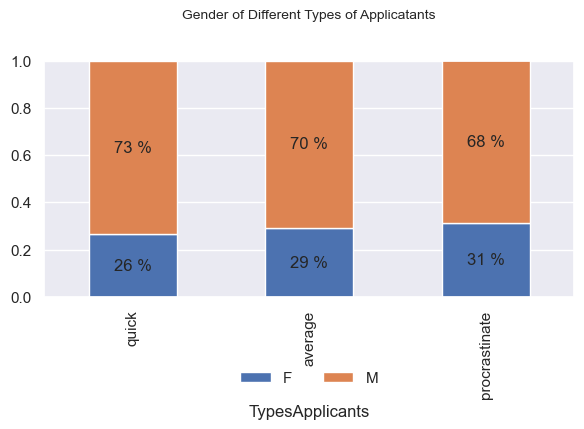

In [ ]:
    x_var, y_var = "TypesApplicants", "Sex"
    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)
    df_grouped.plot.bar(stacked=True)
    plt.legend(
        bbox_to_anchor=(0.5, -0.4),
        loc="lower center",
        borderaxespad=0,
        frameon=False,
        ncol=3,
    )
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        cumulative = 0
        for element in row:
            if element > 0.1:
                plt.text(
                    ix,
                    cumulative + element / 2,
                    f"{int(element * 100)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
    plt.tight_layout()
    plt.title('Gender of Different Types of Applicatants', fontsize=10)

0 Race
American Indian                               0.004274
American Indian, Asian, White                      NaN
American Indian, Black or African American         NaN
American Indian, White                        0.008547
Asian                                         0.722222
Asian, Black or African American                   NaN
Asian, Black or African American, White       0.004274
Asian, Islander                                    NaN
Asian, White                                  0.012821
Black or African American                     0.051282
White                                         0.196581
Name: 0, dtype: float64
1 Race
American Indian                               0.002323
American Indian, Asian, White                 0.001161
American Indian, Black or African American         NaN
American Indian, White                        0.002323
Asian                                         0.761905
Asian, Black or African American              0.001161
Asian, Black or African Ame

Text(0.5, 1.0, 'Race of Different Types of Applicatants')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


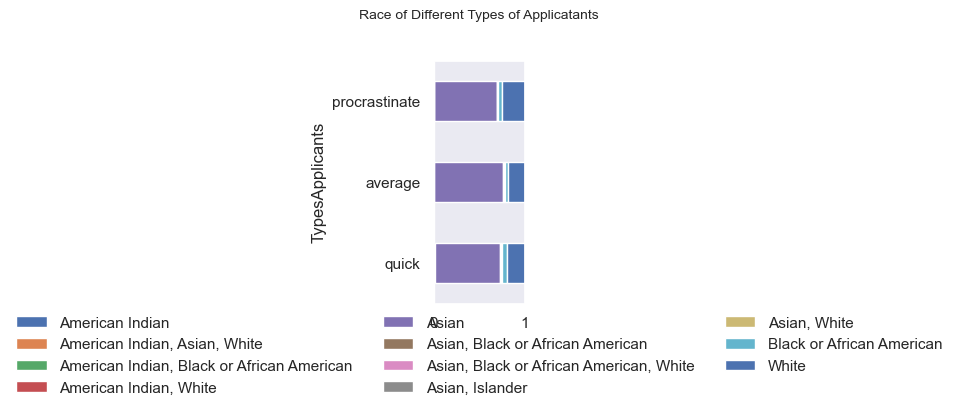

In [ ]:
    x_var = "TypesApplicants"
    y_var = "Race"
    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)
    df_grouped.plot.barh(stacked=True)
    plt.legend(
        bbox_to_anchor=(0.5, -0.4),
        loc="lower center",
        borderaxespad=0,
        frameon=False,
        ncol=3,
    )
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        print(ix, row)
        cumulative = 0
        for element in row:
            if element > 0.1:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element * 100)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
    plt.tight_layout()
    plt.title('Race of Different Types of Applicatants', fontsize=10)

### Do admitted students accept or deny our offers based on when they started or completed their application?

In [ ]:
df_q7 = df_temp[~df_temp['Decision 1'].isnull()&(~df_temp['Created'].isnull())&(~df_temp['Submitted'].isnull())]

program_dict = {'Electrical and Computer Engineering':'ECE', 'Computer Science':'CS',
       'Data Science':'DS'}
df_q7['Program'] = df_q7['Program (ASE)'].apply(lambda x:program_dict[x])
df_q7['Year'] = df_q7['Entry Term'].apply(lambda x : x[-4::])
df_q7['Degree']=df_q7['Degree'].replace('Master\'s','MS')
df_q7 = df_q7[df_q7['Degree']!='Advanced Certificate/Professional' ]
df_q7['UR_Decision'] = df_q7['Decision 1'].apply(urdecision)
df_q7['Applicant_Decision'] = df_q7.apply(lambda x: applicant_decision(x['Decision 1'],x['Decision 2'],x['UR_Decision']),axis=1)
#first create as start date of each term
start_time = df_q7.groupby(['Entry Term'])['Created'].min().to_dict()
# last submite date as due date of each term
end_time = df_q7.groupby(['Entry Term'])['Submitted'].max().to_dict()
for term in start_time.keys():
    start_time[term] = datetime.date(start_time[term])
for term in end_time.keys():
    end_time[term] = datetime.date(end_time[term])
df_q7['start'] = df_q7['Entry Term'].apply(lambda a : start_time[a])
df_q7['due'] = df_q7['Entry Term'].apply(lambda a : end_time[a])
#filter all data needed
df_q7 = df_q7[['UR_Decision','Applicant_Decision','Created','Submitted','start','due']]
df_q7['Created']=df_q7['Created'].apply(lambda a: pd.Timestamp(a))
df_q7['Submitted']=df_q7['Submitted'].apply(lambda a: pd.Timestamp(a))
df_q7['start']=df_q7['start'].apply(lambda a: pd.Timestamp(a))
df_q7['due']=df_q7['due'].apply(lambda a: pd.Timestamp(a))
# start period: from start date of application to the create date of students
df_q7['period1'] = df_q7.apply(lambda a:a['Created']-a['start'],axis=1)
df_q7['period2'] = df_q7.apply(lambda a:a['Submitted']-a['Created'],axis=1)
df_q7['period1Day'] = df_q7['period1'].apply(lambda a:a.days+1)
df_q7['period2Day'] = df_q7['period2'].apply(lambda a:a.days+1)
df_q7['period1Month'] = df_q7['period1'].apply(lambda a:math.ceil((a.days+1)/30))
df_q7['period2Month'] = df_q7['period2'].apply(lambda a:math.ceil((a.days+1)/30))


Simple Conclusion:


1.   Most admitted students prefer to start and submit their application on the first day
2.   Student who accept their offer prefer to start and complete earlier than those who deny their offer, which make sense. Students who really want to come will be eager to conmplete their application early, those who has other choice may slower as they have other applications to complete.

Day plot

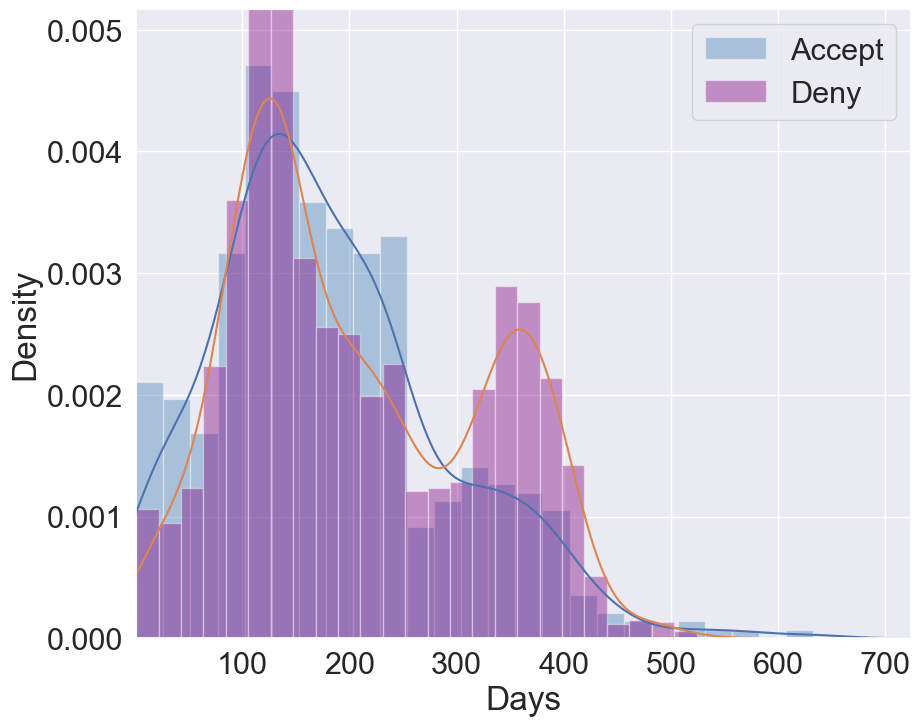

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(10,10/1.2))
p1_accept = df_q7[df_q7['Applicant_Decision']=='Accept']['period1Day']
p1_deny = df_q7[(df_q7['Applicant_Decision']!='Accept')&(df_q7['UR_Decision']=='Admit')]['period1Day']
#Accept Students
ax=sns.distplot(p1_accept,bins=25,kde=True,hist_kws={"color":"steelblue"},norm_hist=True,label="Accept")
#Deny students

#plt.title("When did admitted applicants \nstart their applications (days)")
ax=sns.distplot(p1_deny,bins=25,kde=True,hist_kws={"color":"purple"},norm_hist=True,label="Deny")
ax.set_xlabel("Days")
ax.set_ylabel("Density")
ax.set_xlim(left =1)
plt.legend(loc='upper right')
plt.show()

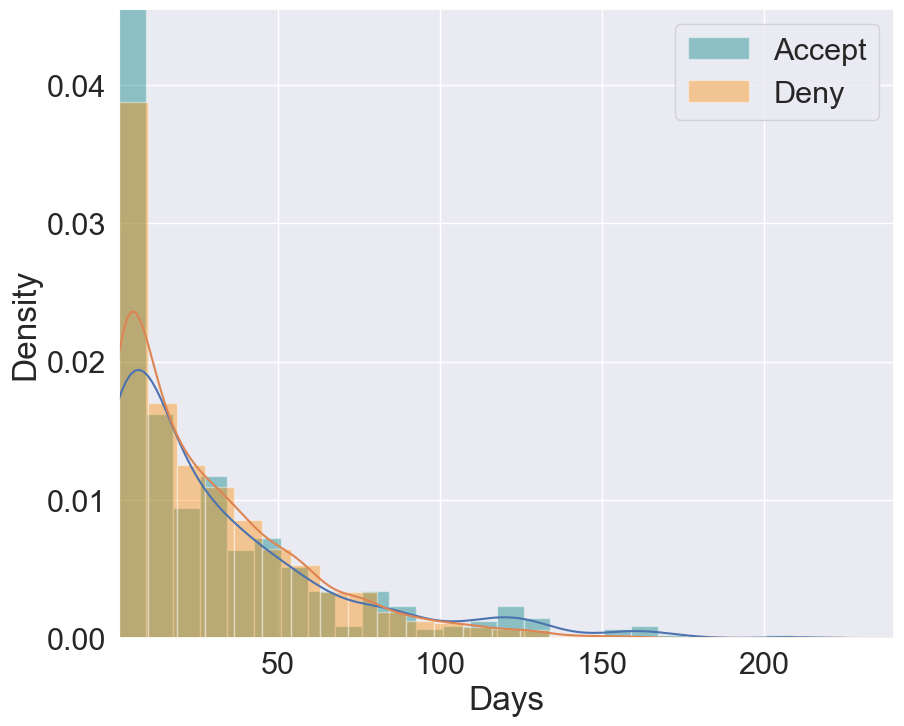

In [ ]:

plt.figure(figsize=(10,10/1.2),dpi=100)
p1_accept = df_q7[df_q7['Applicant_Decision']=='Accept']['period2Day']
p1_deny = df_q7[(df_q7['Applicant_Decision']!='Accept')&(df_q7['UR_Decision']=='Admit')]['period2Day']
#Accept Students

#Deny students

#plt.title("When did admitted applicants \ncomplete their applications (days)")
ax=sns.distplot(p1_accept,bins=25,kde=True,hist_kws={"color":"teal"},norm_hist=True,label="Accept")
ax=sns.distplot(p1_deny,bins=25,kde=True,hist_kws={"color":"darkorange"},norm_hist=True,label="Deny")

ax.set_xlabel("Days")
ax.set_ylabel("Density")
ax.set_xlim(left =1)
plt.legend(loc='upper right')

Month Plot

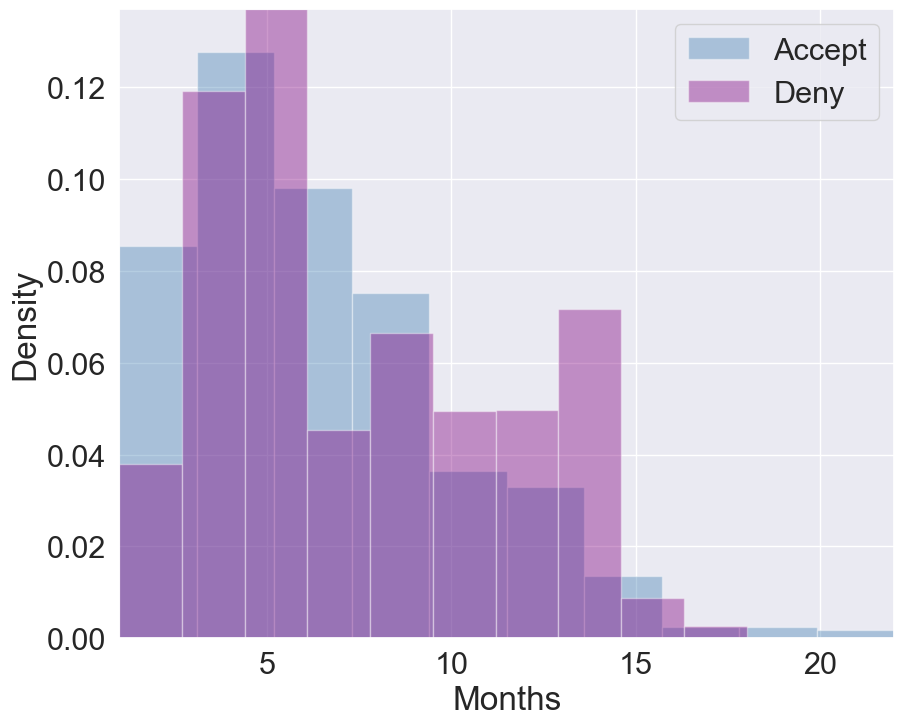

In [ ]:
plt.figure(figsize=(10,10/1.2),dpi=100)
p1_accept = df_q7[df_q7['Applicant_Decision']=='Accept']['period1Month']
p1_deny = df_q7[(df_q7['Applicant_Decision']!='Accept')&(df_q7['UR_Decision']=='Admit')]['period1Month']
#Accept Students
ax=sns.distplot(p1_accept,bins=10,kde=False,hist_kws={"color":"steelblue"},norm_hist=True,label="Accept")
#Deny students

#plt.title("When did admitted applicants \nstart their applications (months)")
ax=sns.distplot(p1_deny,bins=10,kde=False,hist_kws={"color":"purple"},norm_hist=True,label="Deny")
ax.set_xlabel("Months")
ax.set_ylabel("Density")
plt.legend(loc='upper right')

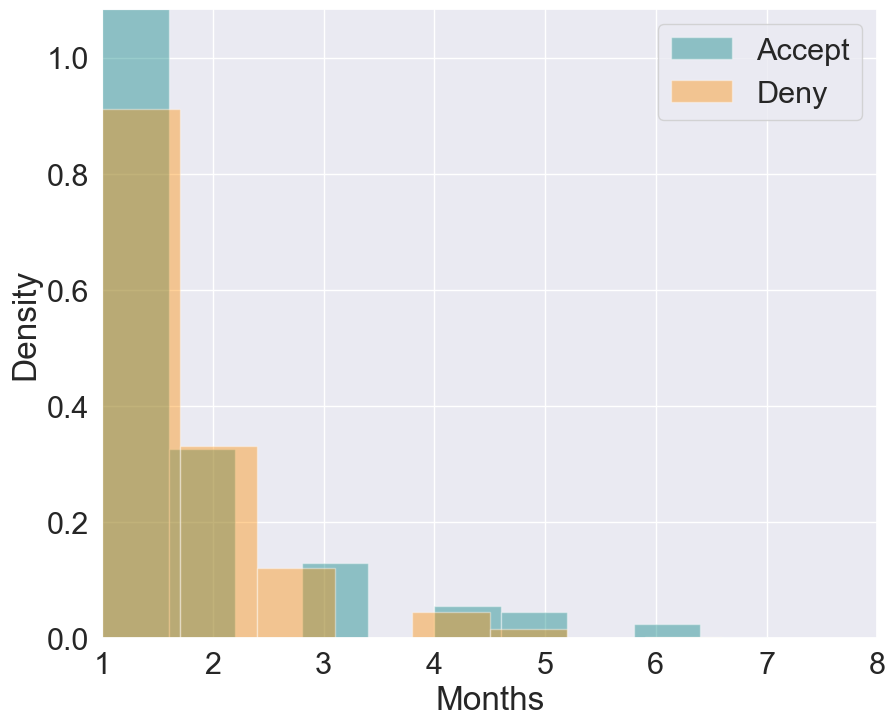

In [ ]:
plt.figure(figsize=(10,10/1.2),dpi=100)
p1_accept = df_q7[df_q7['Applicant_Decision']=='Accept']['period2Month']
p1_deny = df_q7[(df_q7['Applicant_Decision']!='Accept')&(df_q7['UR_Decision']=='Admit')]['period2Month']
#Accept Students
ax=sns.distplot(p1_accept,bins=10,kde=False,hist_kws={"color":"teal"},norm_hist=True,label="Accept")
#Deny students

#plt.title("When did admitted applicants \ncomplete their applications (months)")
ax=sns.distplot(p1_deny,bins=10,kde=False,hist_kws={"color":"darkorange"},norm_hist=True,label="Deny")
ax.set_xlabel("Months")
#ax.set_xlim(left=0)
ax.set_ylabel("Density")
plt.legend(loc='upper right')

### What can you tell me about the people who don’t finish applications?


In [ ]:
df_q8 =  df_temp
df_q8['is_submit'] = df_q8['Submitted'].apply(lambda a : 0 if (pd.isna(a)) else 1)
df_q8['Program'] = df_q8['Program (ASE)'].apply(lambda x:program_dict[x])
df_q8['Year'] = df_q8['Entry Term'].apply(lambda x : x[-4::])
df_q8['Degree']=df_q8['Degree'].replace('Master\'s','MS')
df_q8 = df_q8[df_q8['Degree']!='Advanced Certificate/Professional' ]
#first create as start date of each term
start_time = df_q8.groupby(['Entry Term'])['Created'].min().to_dict()
for term in start_time.keys():
    start_time[term] = datetime.date(start_time[term])
df_q8['start'] = df_q8['Entry Term'].apply(lambda a : start_time[a])
df_q8['Created']=df_q8['Created'].apply(lambda a: pd.Timestamp(a))
df_q8['start']=df_q8['start'].apply(lambda a: pd.Timestamp(a))
# start period: from start date of application to the create date of students
df_q8['period1'] = df_q8.apply(lambda a:a['Created']-a['start'],axis=1)
df_q8['period1Day'] = df_q8['period1'].apply(lambda a:a.days+1)
df_q8['period1Month'] = df_q8['period1'].apply(lambda a:math.ceil((a.days+1)/30))

In [ ]:
unsubmit = df_q8.is_submit.value_counts()[0]
submitted = df_q8.is_submit.value_counts()[1]
print(f"{unsubmit} students don't finish their applications" )
print(f"{submitted} students  finish their applications" )

2105 students don't finish their applications
8665 students  finish their applications


1.Start Time

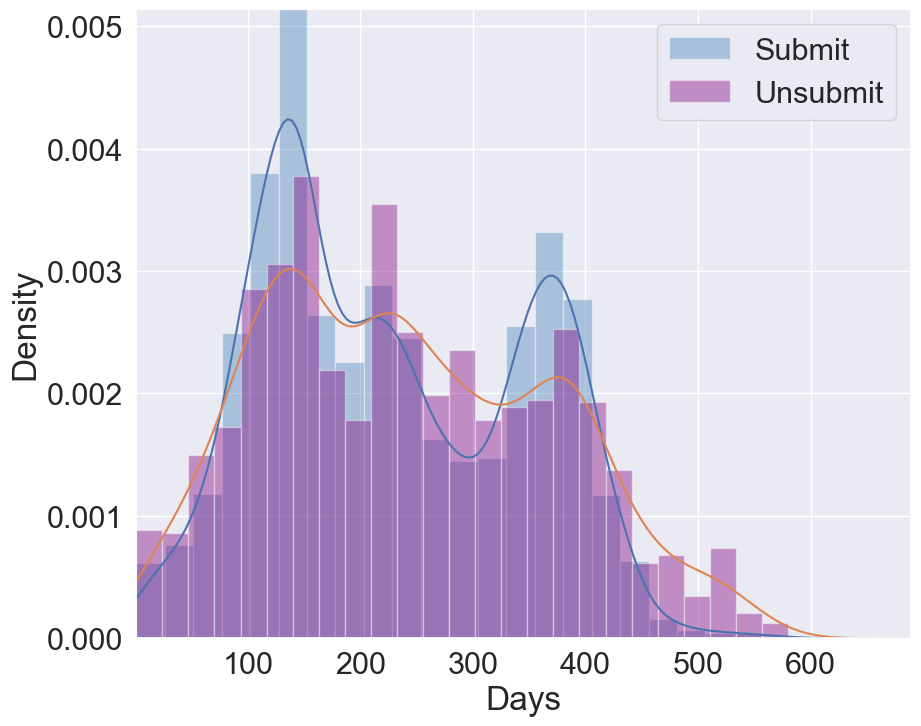

In [ ]:
# Start time

plt.figure(figsize=(10,10/1.2), dpi=100)
p1_submit = df_q8[df_q8['is_submit']==1]['period1Day']
p1_unsubmit = df_q8[df_q8['is_submit']==0]['period1Day']

ax=sns.distplot(p1_submit,bins=25,kde=True,hist_kws={"color":"steelblue"},norm_hist=True,label="Submit")
#Deny students

#plt.title("When did applicants start their applications (days)")
ax=sns.distplot(p1_unsubmit,bins=25,kde=True,hist_kws={"color":"purple"},norm_hist=True,label="Unsubmit")
ax.set_xlabel("Days")
ax.set_ylabel("Density")
ax.set_xlim(left =1)
plt.legend(loc='upper right')
#plt.savefig('./fig/p2_q8_1.png')
plt.show()

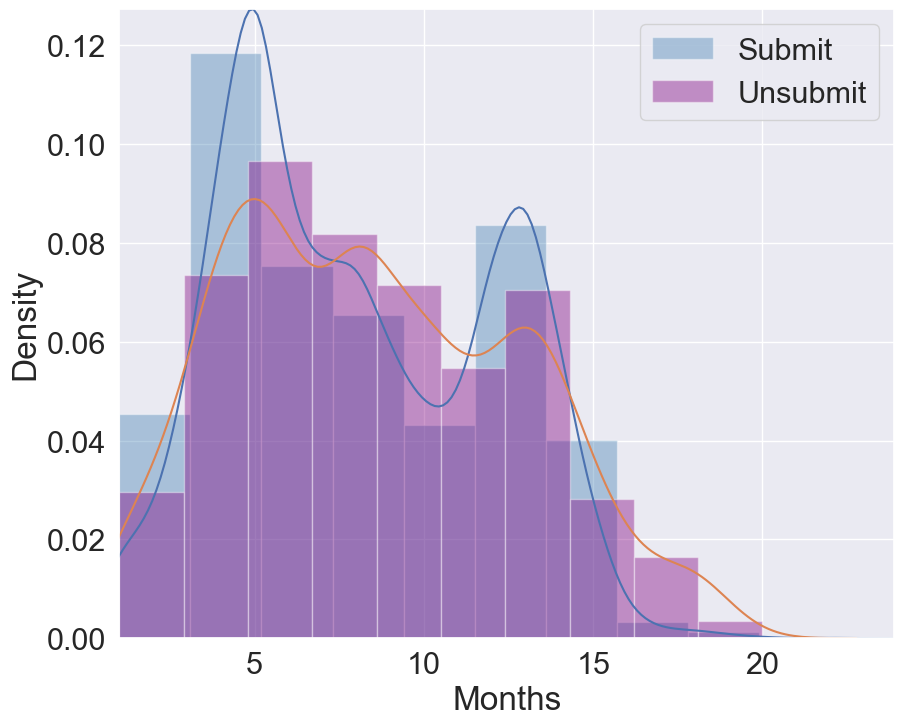

In [ ]:
# Start time
plt.figure(figsize=(10,10/1.2), dpi=100)
p1_submit = df_q8[df_q8['is_submit']==1]['period1Month']
p1_unsubmit = df_q8[df_q8['is_submit']==0]['period1Month']

ax=sns.distplot(p1_submit,bins=10,kde=True,hist_kws={"color":"steelblue"},norm_hist=True,label="Submit")
#Deny students

#plt.title("When did applicants start their applications (months)")
ax=sns.distplot(p1_unsubmit,bins=10,kde=True,hist_kws={"color":"purple"},norm_hist=True,label="Unsubmit")
ax.set_xlabel("Months")
ax.set_ylabel("Density")
ax.set_xlim(left =1)
plt.legend(loc='upper right')
#plt.savefig('./fig/p2_q8_2.png')
plt.show()

2.Country

USA students has a high rate of unsubmission


<Figure size 600x400 with 0 Axes>

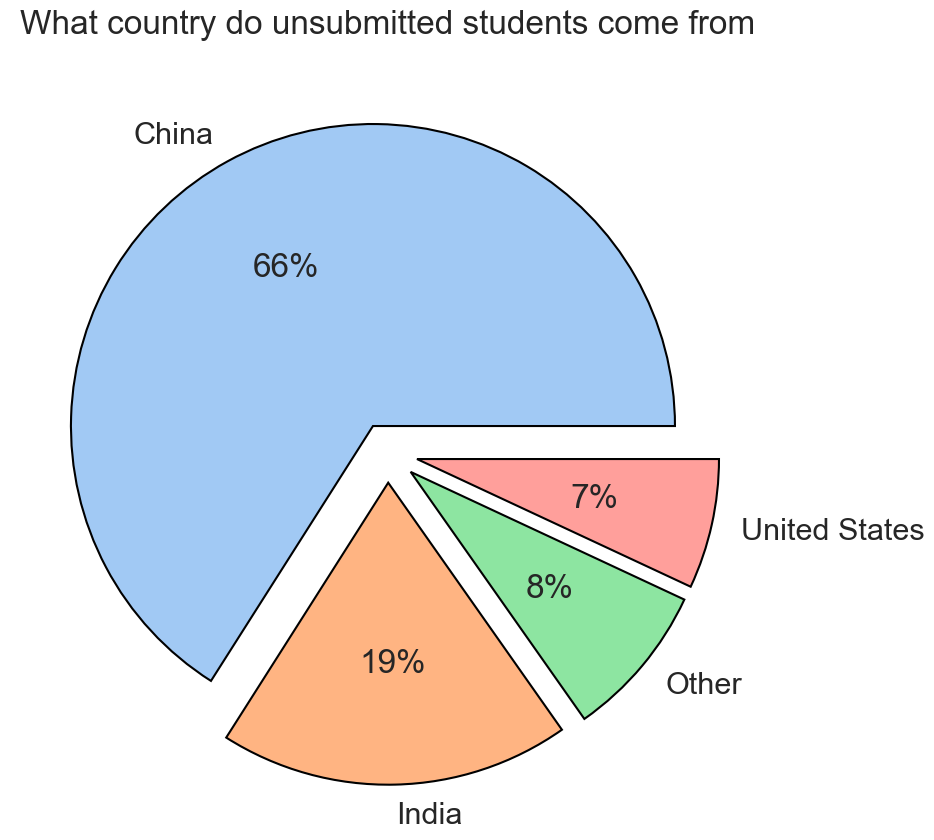

In [ ]:
plt.figure(dpi=100)
plt.figure(figsize=(10,10), dpi=100)
main_country = ['India','China','United States']
df_q8['Country'] = df_q8['Birth Country'].apply(lambda a: a if (a in main_country) else 'Other')
submitted=df_q8[df_q8['is_submit']==1]['Country'].value_counts()
unsubmitted=df_q8[df_q8['is_submit']==0]['Country'].value_counts()
all=df_q8['Country'].value_counts()
#plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
palette_color = sns.color_palette("pastel")
plt.pie(submitted, labels=submitted.index, colors=palette_color, autopct='%.0f%%',explode=(0.1, 0.1, 0.1, 0.1),wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.5,
                      'antialiased': True})
plt.title("What country do unsubmitted students come from")
#plt.savefig('./fig/p2_q8_3.png')
plt.show()


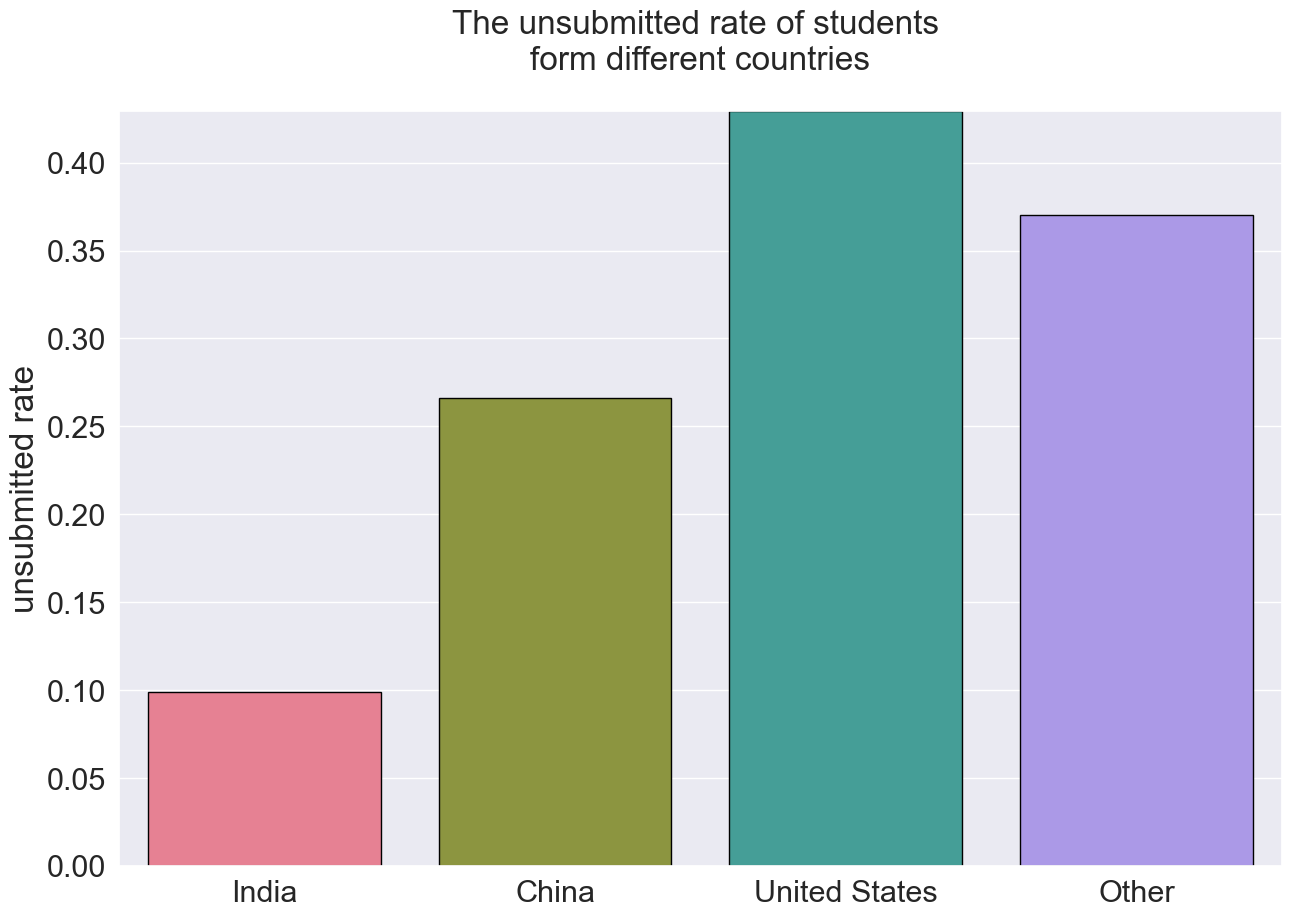

In [ ]:
unsubmitted_rate=unsubmitted.values/all.values

unsubmitted_label = unsubmitted.index
plt.figure(figsize=(15,10), dpi=100)
sns.barplot(x = unsubmitted_label,y=unsubmitted_rate, palette="husl", edgecolor='black')
plt.title("The unsubmitted rate of students \nform different countries")
plt.ylabel("unsubmitted rate")
#plt.savefig('./fig/p2_q8_5.png')
plt.show()

3.Gender

Unsubmitted rate is close between different gender

<Figure size 1500x1000 with 0 Axes>

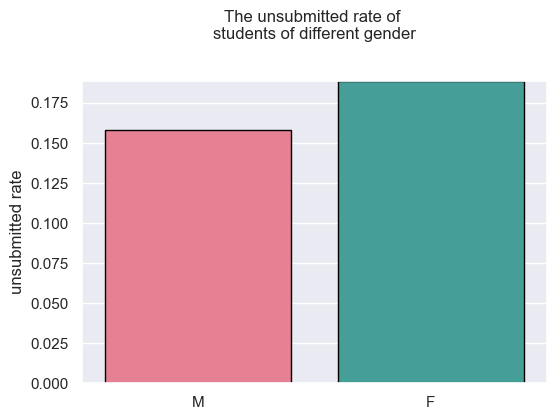

In [ ]:
sns.set(font_scale=1)
submitted=df_q8[df_q8['is_submit']==1]['Sex'].value_counts()
unsubmitted=df_q8[df_q8['is_submit']==0]['Sex'].value_counts()
all=df_q8['Sex'].value_counts()
plt.figure(figsize=(15,10), dpi=100)
unsubmitted_rate=unsubmitted.values/all.values
unsubmitted_label = unsubmitted.index
plt.figure(dpi=100)
sns.barplot(x = unsubmitted_label,y=unsubmitted_rate, palette="husl", edgecolor='black')
plt.title("The unsubmitted rate of \nstudents of different gender")
plt.ylabel("unsubmitted rate")
#plt.savefig('./fig/p2_q8_6.png')
plt.show()

4.Score

Students with low GPA are more likely to give up their application as they find it is too hard for them to apply

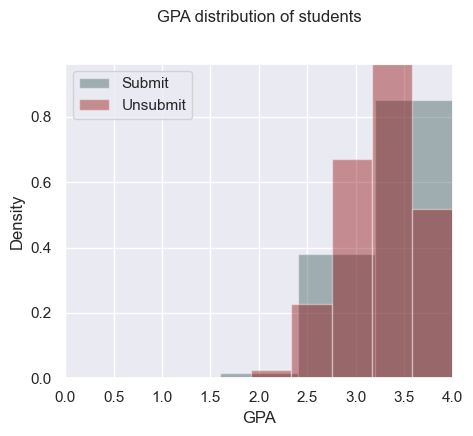

In [ ]:
df_q8['GPA'] = df_q8['Institution 1 GPA (4.0 Scale)']
submitted_gpa=df_q8[df_q8['is_submit']==1]['GPA']
unsubmitted_gpa=df_q8[df_q8['is_submit']==0]['GPA']
all_gpa=df_q8['GPA']
plt.figure(figsize=(5,5/1.2),dpi=100)
#Accept Students
ax=sns.distplot(submitted_gpa,bins=5,kde=False,hist_kws={"color":"darkslategrey"},norm_hist=True,label="Submit")
#Deny students

plt.title("GPA distribution of students")
ax=sns.distplot(unsubmitted_gpa,bins=5,kde=False,hist_kws={"color":"darkred"},norm_hist=True,label="Unsubmit")
ax.set_xlabel("GPA")
#ax.set_xlim(left=0)
ax.set_ylabel("Density")
#plt.savefig('./fig/p2_q8_7.png')
plt.legend()

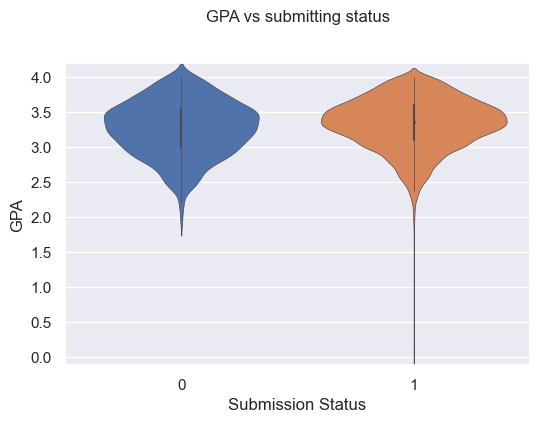

In [ ]:
axes = plt.figure(dpi=100).add_subplot(111)
axes = sns.violinplot(data=df_q8, y="GPA", x="is_submit", saturation=0.9, linewidth=0.5)
plt.title('GPA vs submitting status')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Unsubmitted'
labels[1] = 'Submitted'
#axes.set_xticklabels(labels)
plt.xlabel("Submission Status")
#plt.xticks(['Unsubmitted','Submitted'])
#fig = px.violin(df, y="relative_created", x="Year", color="Season", box=False, points="outliers",
#          hover_data=df.columns)
fig.show()

### What other programs did applicants say they were also applying to? What is the “rank” of these schools?

<AxesSubplot:>

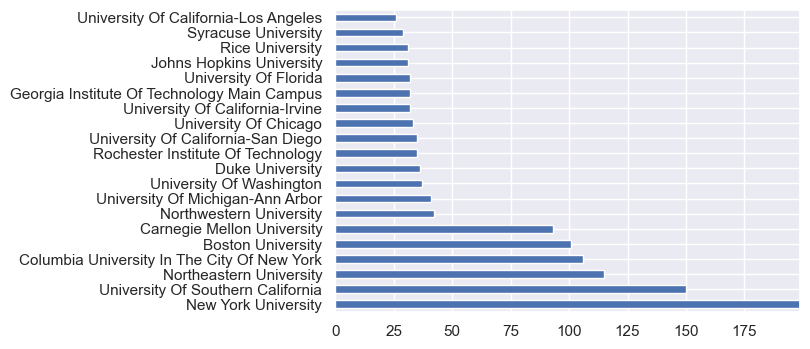

In [ ]:
df['Other Schools Applying To'].value_counts()[:20].plot(kind='barh')

### How many schools do applicants say they typically apply to?

<AxesSubplot:>

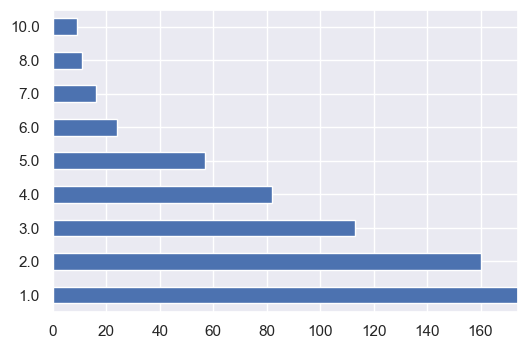

In [ ]:
df['Other Schools Applying To'].str.count(',').add(1).groupby(df['Other Schools Applying To']).sum().value_counts()[:10].plot(kind='barh')

### How did they hear about our program?

In [ ]:

df = df[df['Degree']=='Master\'s']
df = df[df['Time Status']=='Full Time']
period = ['Fall 2022','Fall 2023','Spring 2022','Spring 2023', 'Summer 2022', 'Summer 2023']
df = df[~df['Entry Term'].isin(period)]
df['Degree']=df['Degree'].replace('Master\'s','MS')
program_dict = {'Electrical and Computer Engineering':'ECE', 'Computer Science':'CS',
       'Data Science':'DS'}
df['Program'] = df['Program (ASE)'].apply(lambda x:program_dict[x])
df['Year'] = df['Entry Term'].apply(lambda x : x[-4::])
df['Degree']=df['Degree'].replace('Master\'s','MS')
df = df[df['Degree']!='Advanced Certificate/Professional' ]
#stu_df = pd.read_csv('merge-2.csv',index_col=0)

Text(0.5, 1.0, 'How Applicant Heard About UR')

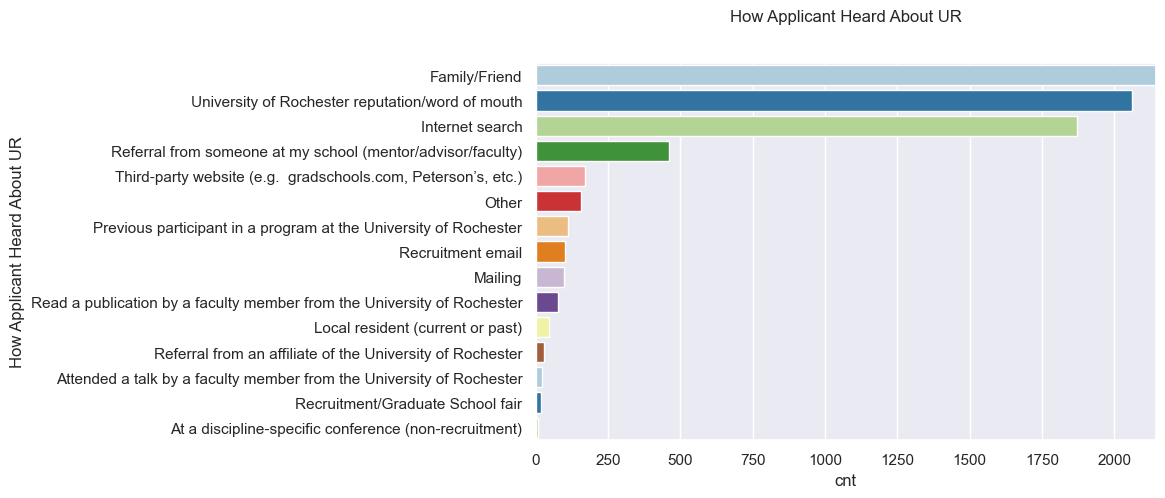

In [ ]:
fig = plt.figure(figsize=(8,5))
df_heard = df['How Applicant Heard About UR'].value_counts().to_frame(name="counts")
df_heard.reset_index(inplace=True)
df_heard.columns=['How Applicant Heard About UR','cnt']
sns.barplot(x='cnt', y='How Applicant Heard About UR',data=df_heard, palette = 'Paired')
# University Rochester for some students who comes from UR
plt.title("How Applicant Heard About UR")

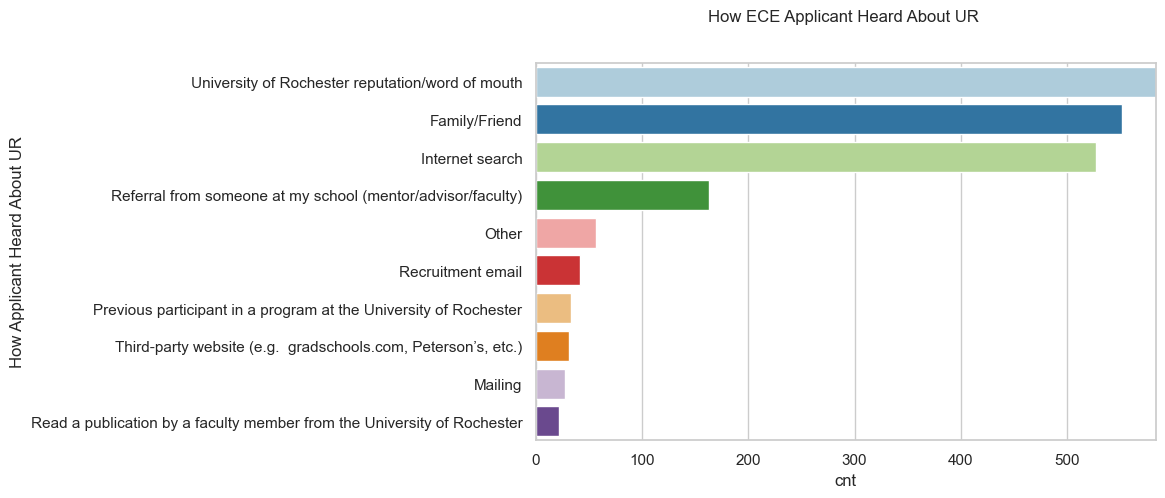

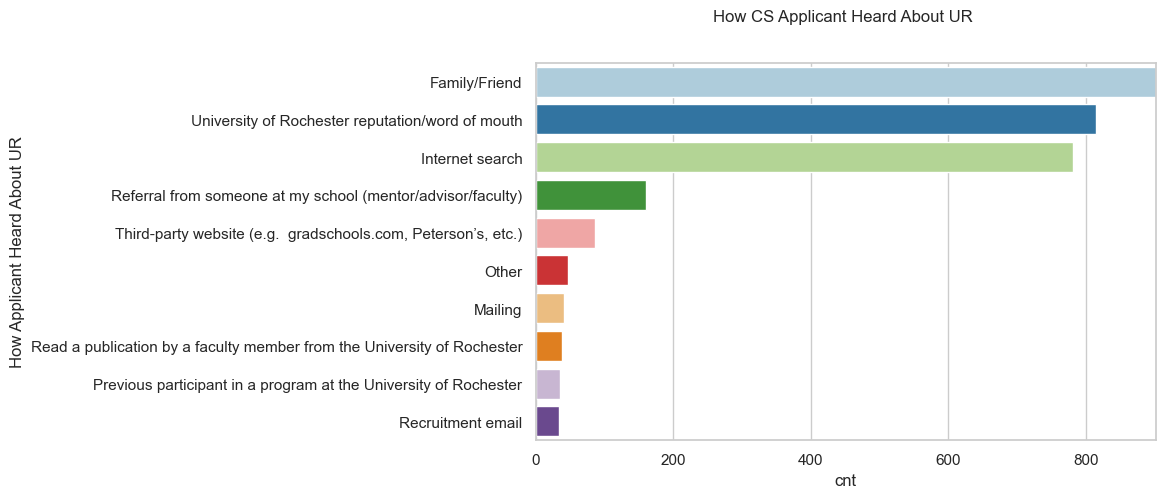

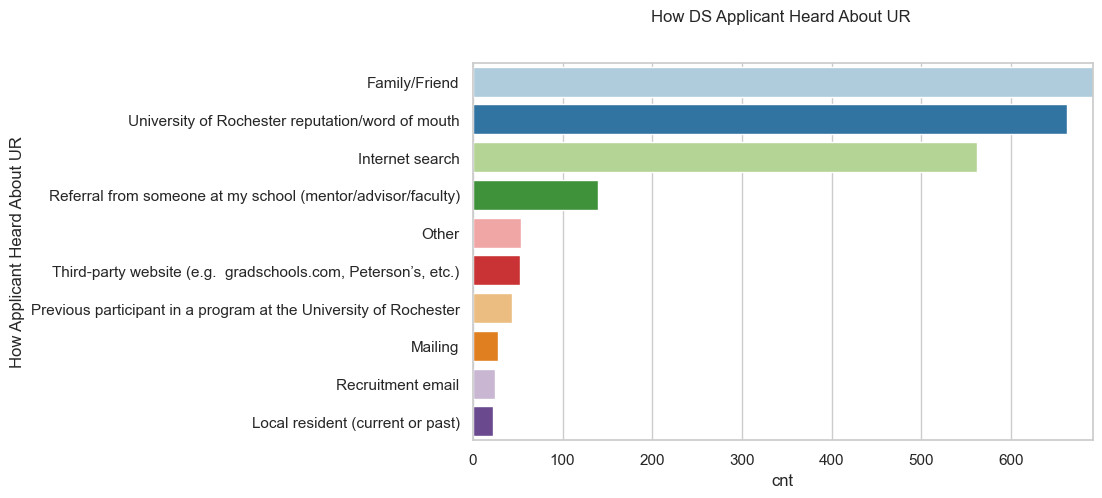

In [ ]:
programs = df['Program'].unique()
sns.set_style("whitegrid")
for program in programs:
    df_program = df[df['Program'] ==program]['How Applicant Heard About UR'].value_counts().to_frame(name="counts")
    df_program.reset_index(inplace=True)
    df_program.columns=['How Applicant Heard About UR','cnt']
    fig = plt.figure(figsize=(8,5))
    sns.barplot(x='cnt',y='How Applicant Heard About UR', data=df_program[0:10], palette = 'Paired')
    # University Rochester for some students who comes from UR
    plt.title(f"How {program} Applicant Heard About UR ")

### Where do our admitted applicants go when they don’t choose Rochester?

In [ ]:
stu_df = pd.read_csv('./DATA/merge-2.csv',index_col=0)
df_q5 = df[~df['Decision 1'].isnull()]

program_dict = {'Electrical and Computer Engineering':'ECE', 'Computer Science':'CS',
       'Data Science':'DS'}
df_q5['Program'] = df_q5['Program (ASE)'].apply(lambda x:program_dict[x])
df_q5['Year'] = df_q5['Entry Term'].apply(lambda x : x[-4::])
df_q5['Degree']=df_q5['Degree'].replace('Master\'s','MS')
df_q5 = df_q5[df_q5['Degree']!='Advanced Certificate/Professional' ]
df_q5['UR_Decision'] = df_q5['Decision 1'].apply(urdecision)
df_q5['Applicant_Decision'] = df_q5.apply(lambda x: applicant_decision(x['Decision 1'],x['Decision 2'],x['UR_Decision']),axis=1)

decline_ref=df_q5[df_q5['Applicant_Decision']=='Decline'][['Ref','Year','Program']]
decline_stu = stu_df[stu_df.Ref.isin(decline_ref['Ref'])]
decline_stu = decline_stu[decline_stu['Graduated.']=='Y']
decline_stu=decline_stu.set_index('Ref').join(decline_ref.set_index('Ref'), how='left')
decline_stu=decline_stu[decline_stu['Period']>=pd.to_numeric(decline_stu['Year'])]
decline_college = decline_stu['College.Name'].value_counts().to_frame(name="counts")
decline_college.reset_index(inplace=True)
decline_college.columns=['college','cnt']
decline_state = decline_stu['College.State'].value_counts().to_frame(name="counts")
decline_state.reset_index(inplace=True)
decline_state.columns=['state','cnt']

Text(0.5, 1.0, 'Top State Where Declined Students Go To')

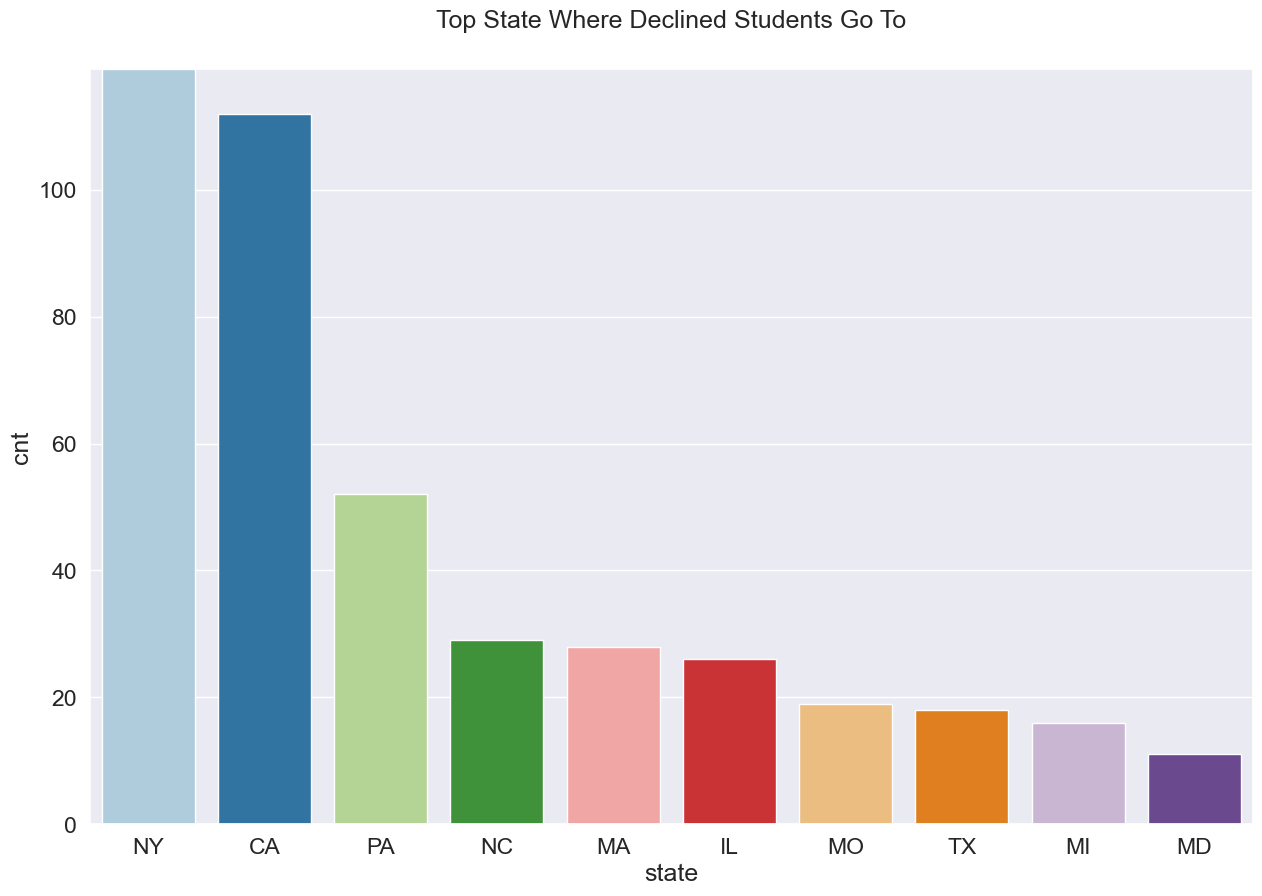

In [ ]:
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(15,10))
sns.barplot(x='state',y='cnt', data=decline_state[0:10], palette = 'Paired')
# University Rochester for some students who comes from UR
plt.title("Top State Where Declined Students Go To")

Text(0.5, 1.0, 'Top College Where Declined Students Go To')

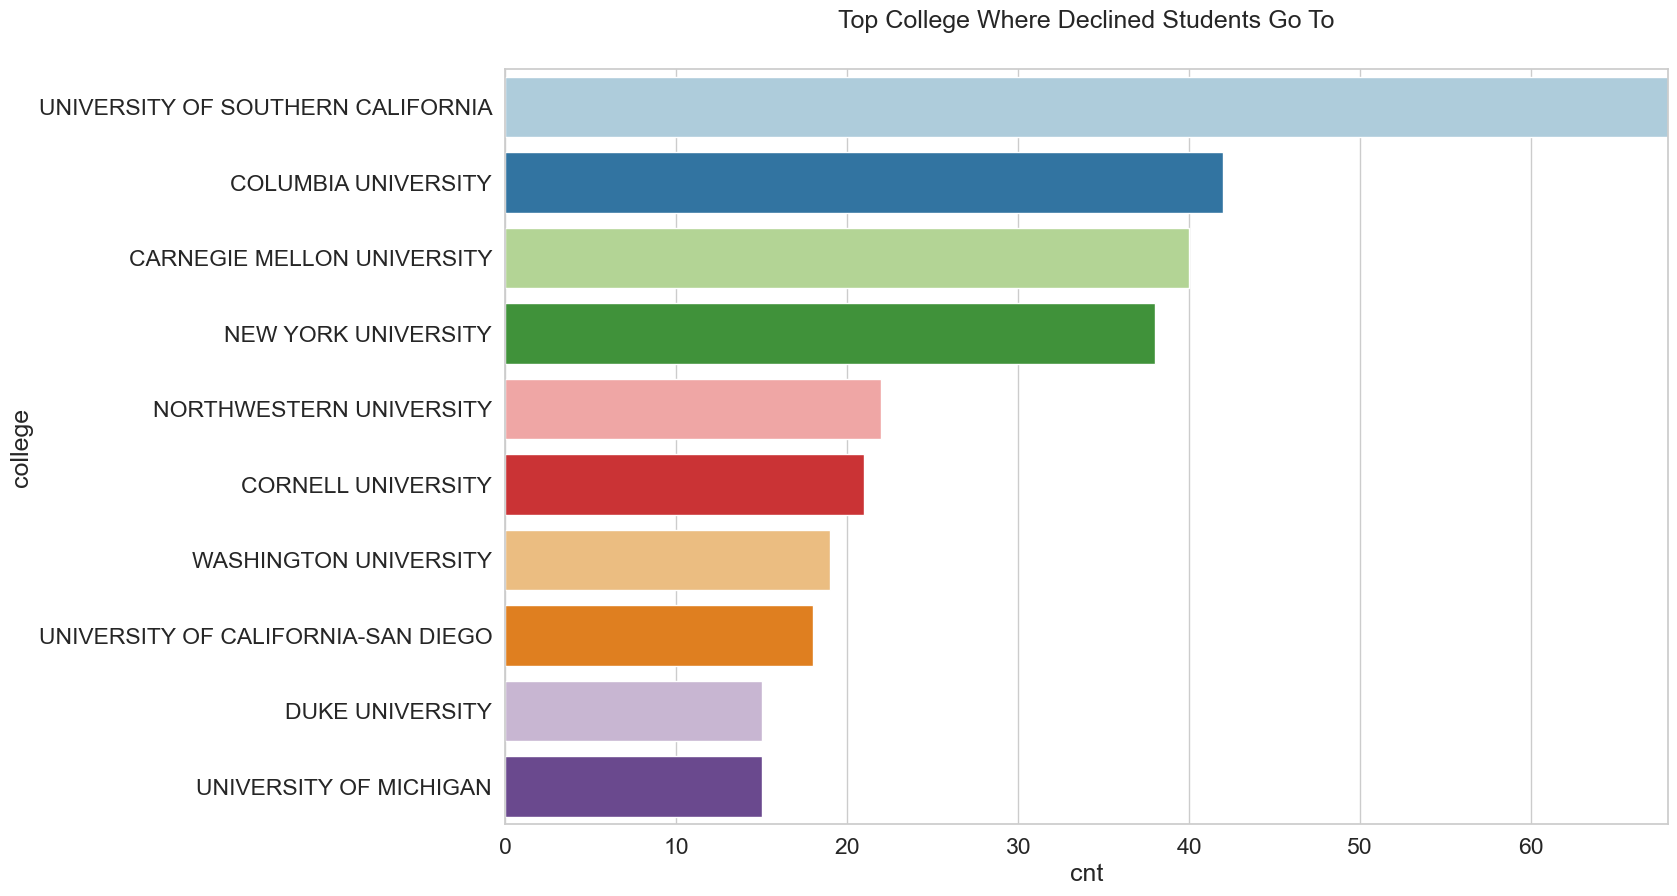

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
sns.barplot(x='cnt',y='college', data=decline_college[0:10], palette = 'Paired')
# University Rochester for some students who comes from UR
plt.title("Top College Where Declined Students Go To")

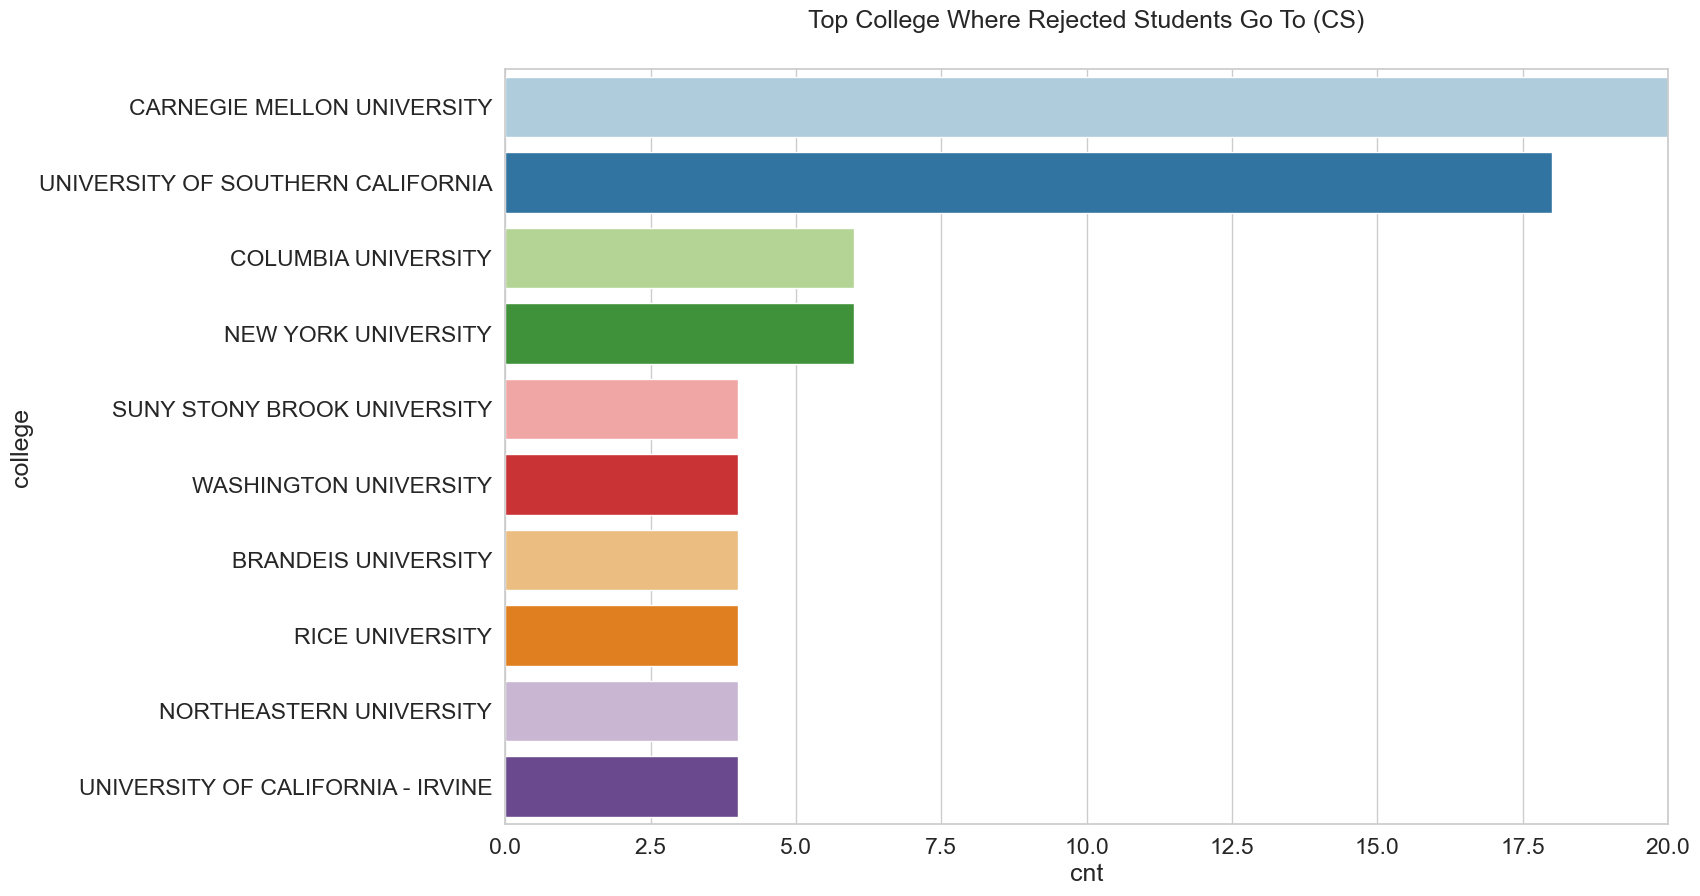

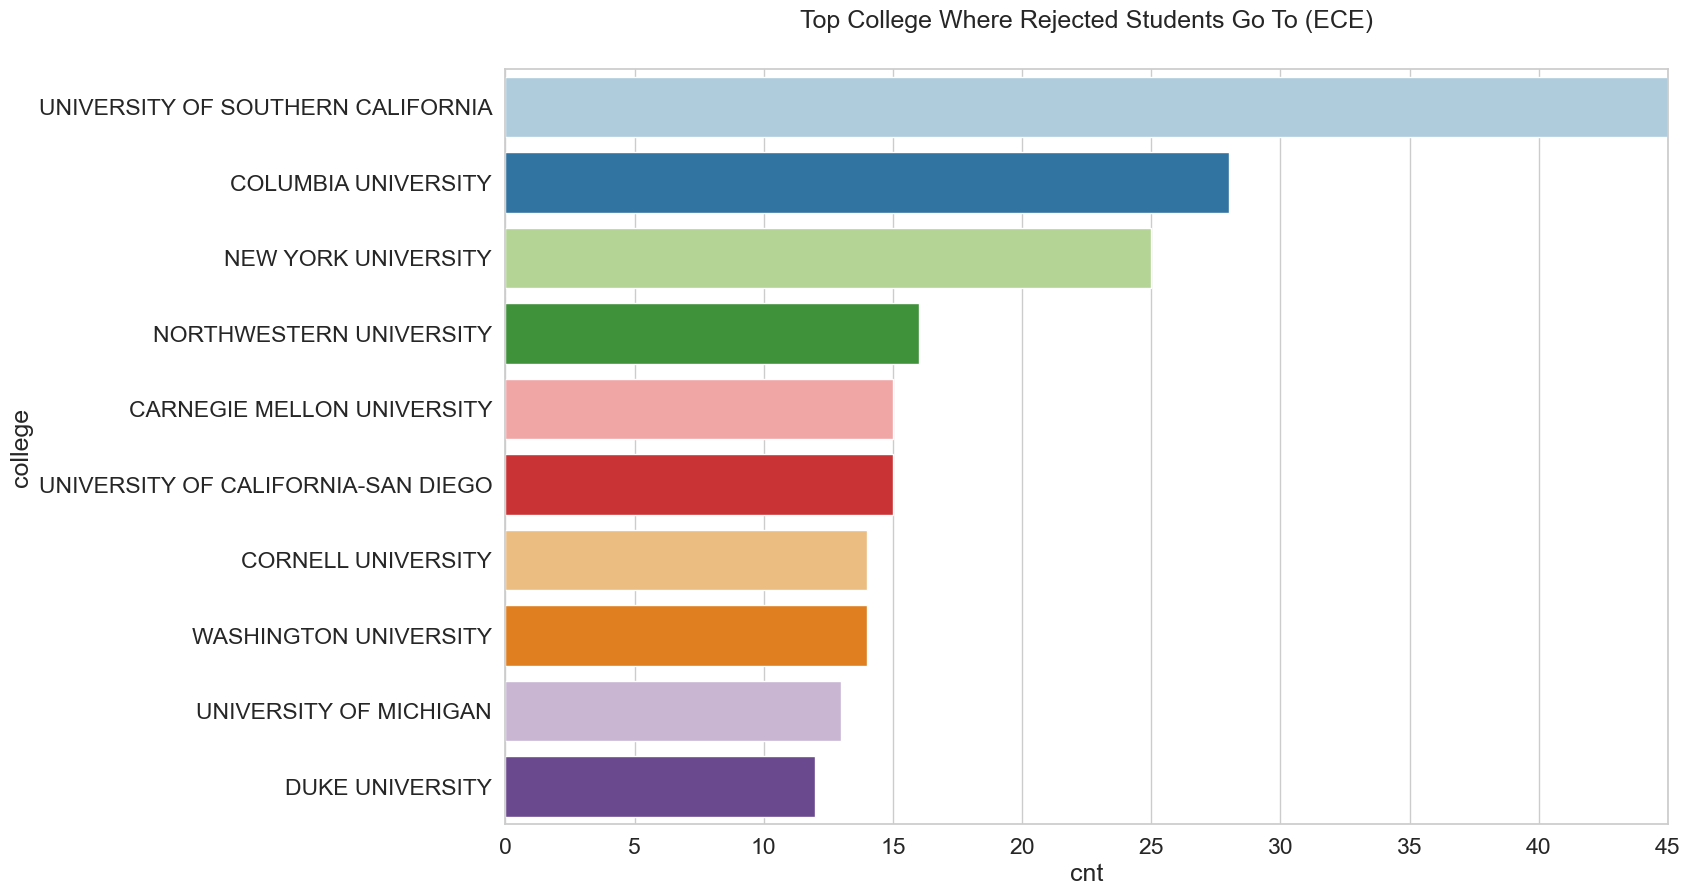

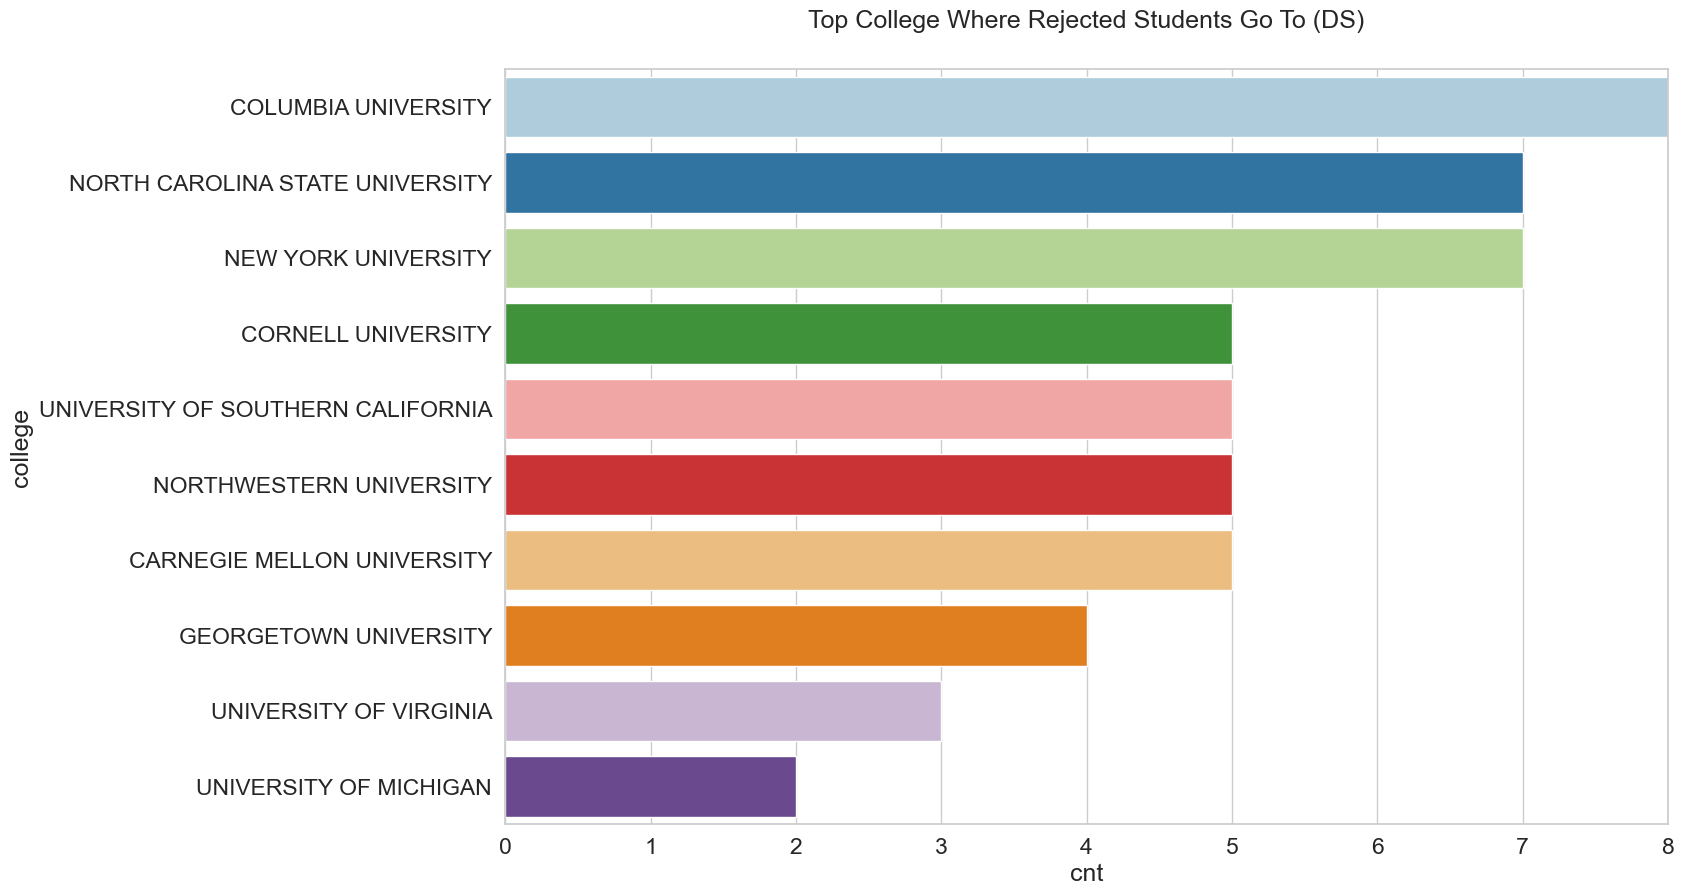

In [ ]:
programs = decline_stu['Program'].unique()
sns.set_style("whitegrid")
for program in programs:
    decline_college = decline_stu[decline_stu['Program'] ==program]['College.Name'].value_counts().to_frame(name="counts")
    decline_college.reset_index(inplace=True)
    decline_college.columns=['college','cnt']
    fig = plt.figure(figsize=(15,10))
    sns.barplot(x='cnt',y='college', data=decline_college[0:10], palette = 'Paired')
    # University Rochester for some students who comes from UR
    plt.title(f"Top College Where Rejected Students Go To ({program})")

In [ ]:
df_q5['Program'] = df_q5['Program (ASE)'].apply(lambda x:program_dict[x])
df_q5['Year'] = df_q5['Entry Term'].apply(lambda x : x[-4::])
df_q5['Degree']=df_q5['Degree'].replace('Master\'s','MS')
df_q5 = df_q5[df_q5['Degree']!='Advanced Certificate/Professional' ]
df_q5['UR_Decision'] = df_q5['Decision 1'].apply(urdecision)
df_q5['Applicant_Decision'] = df_q5.apply(lambda x: applicant_decision(x['Decision 1'],x['Decision 2'],x['UR_Decision']),axis=1)

In [ ]:
rej_ref=df_q5[df_q5['UR_Decision']=='Reject'][['Ref','Year','Program']]
rej_stu = stu_df[stu_df.Ref.isin(rej_ref['Ref'])]
rej_stu = rej_stu[rej_stu['Graduated.']=='Y']
rej_stu=rej_stu.set_index('Ref').join(rej_ref.set_index('Ref'), how='left')
rej_stu=rej_stu[rej_stu['Period']>=pd.to_numeric(rej_stu['Year'])]
rej_college = rej_stu['College.Name'].value_counts().to_frame(name="counts")
rej_college.reset_index(inplace=True)
rej_college.columns=['college','cnt']
rej_state = rej_stu['College.State'].value_counts().to_frame(name="counts")
rej_state.reset_index(inplace=True)
rej_state.columns=['state','cnt']
#Year of enrollment must bigger than or equal with the year when they apply for UR
#Some students may apply for our school for the second master degree

In [ ]:
school_name = pd.read_excel('./DATA/schoolForm.xlsx').set_index('school').to_dict()

ranks= school_name['rank']
school_name = school_name['name']

def school_formula(schoolList):
    if len(schoolList)==0:
        return []
    else:
        form = []
        for s in schoolList:
            if(s in school_name.keys()):
                form.append(school_name[s])
            else:
                continue
        return form

In [ ]:
rej_df = rej_stu[rej_stu['Other Schools Applying To'].notna()][['Other Schools Applying To','College.Name','College.State','Year','Program']]
rej_df['Other Schools Applying To']=rej_df['Other Schools Applying To'].str.split(',')
rej_df['Other Schools Applying To'] = rej_df['Other Schools Applying To'].apply(school_formula)
rej_df.columns = ['Applied','Enrolled','State','Year','Program']
rej_df.reset_index(inplace=True)
rej_applied = rej_df[['Applied','Program']].explode('Applied')
applied_name = rej_applied['Applied'].value_counts().to_frame(name="counts")
applied_name.reset_index(inplace=True)
applied_name.columns=['college','cnt']

Text(0.5, 1.0, 'Top College Where Rejected Students Applied')

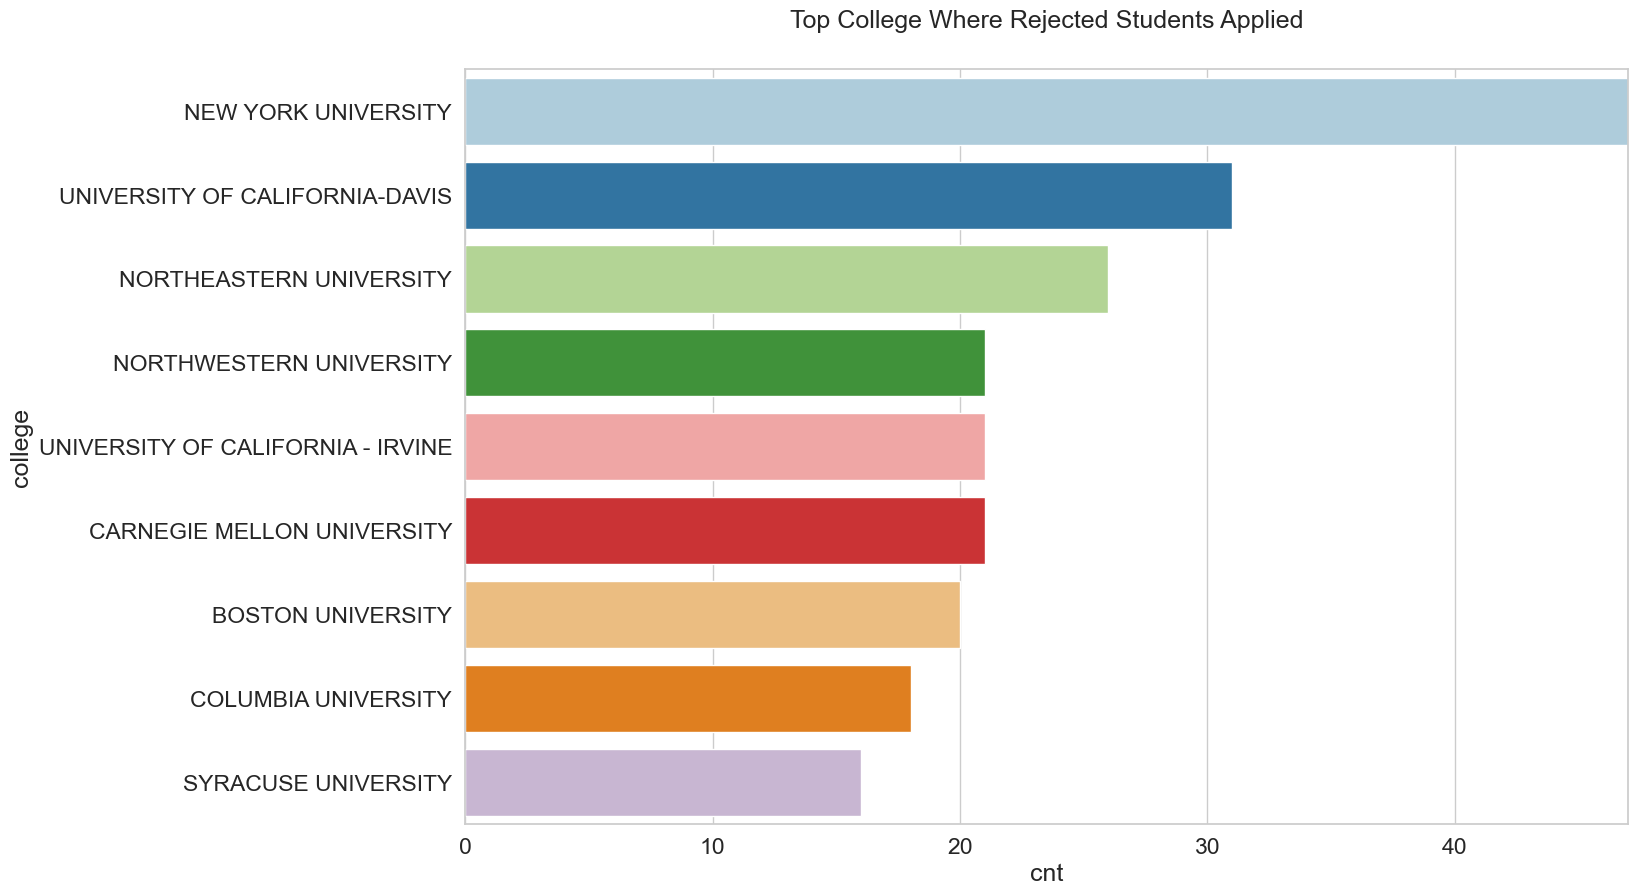

In [ ]:

fig = plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
sns.barplot(x='cnt',y='college', data=applied_name[1:10], palette = 'Paired')
# University Rochester for some students who comes from UR
plt.title("Top College Where Rejected Students Applied")

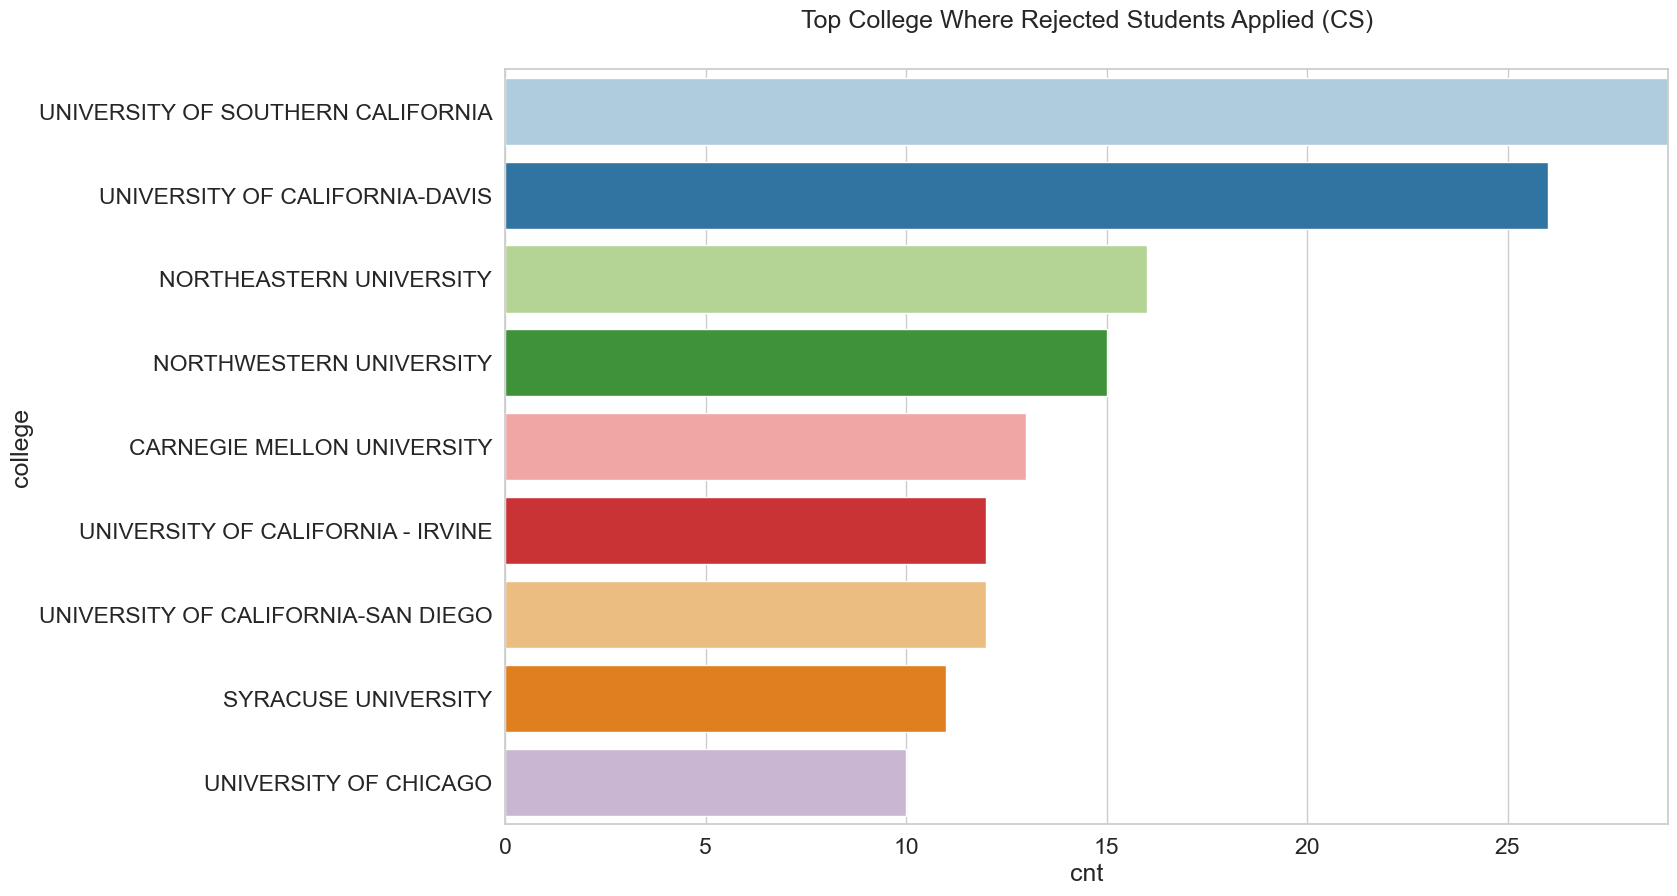

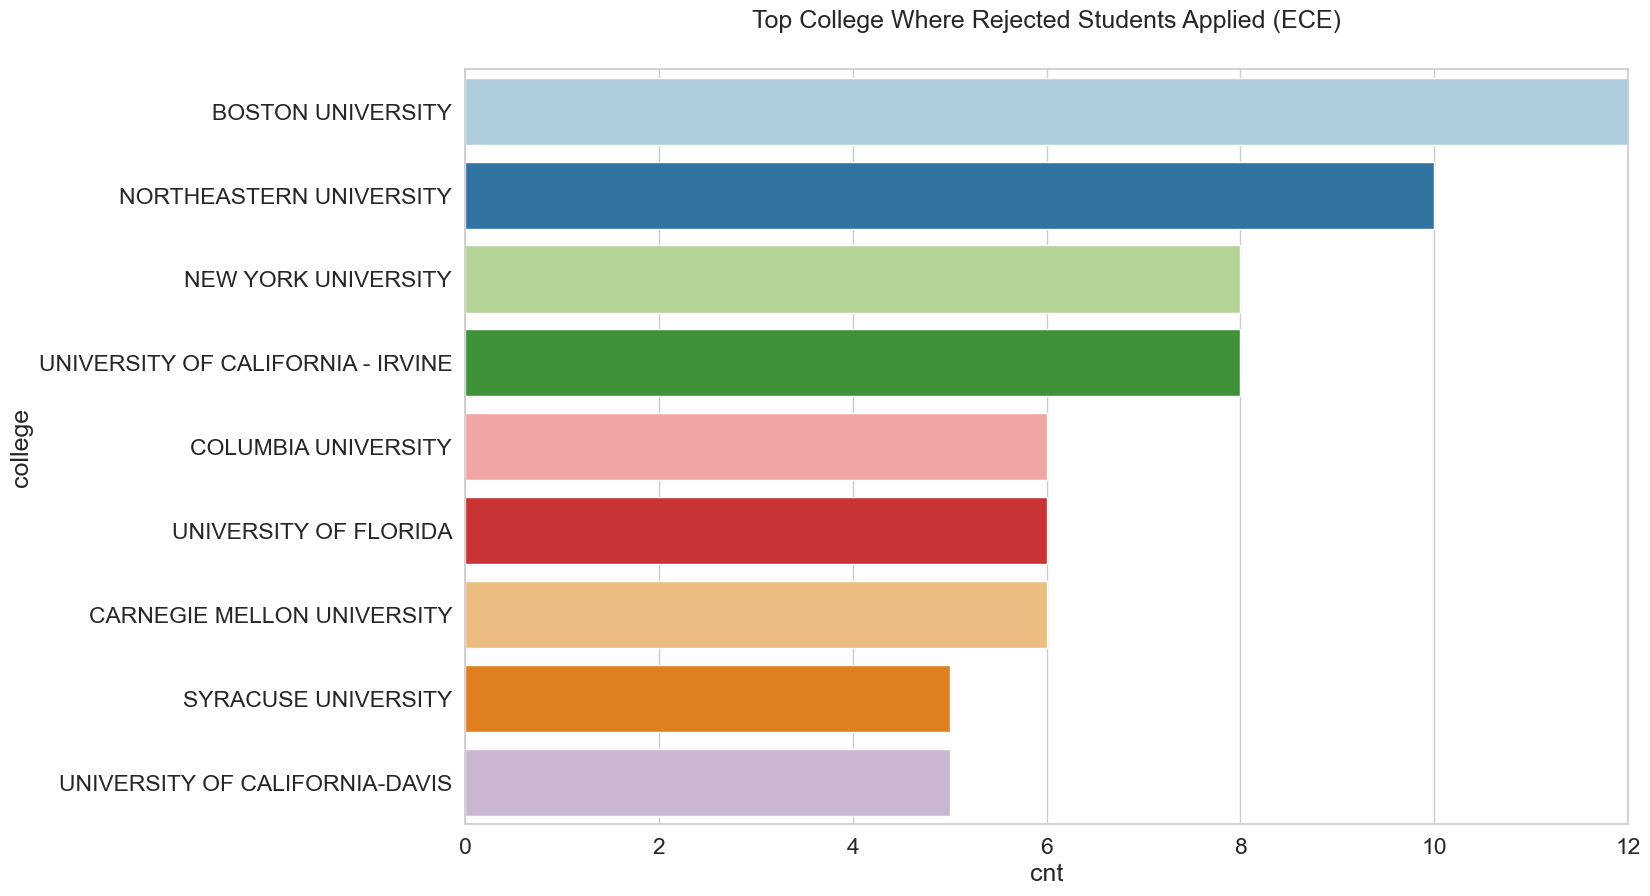

Error in callback <function flush_figures at 0x000002068542A790> (for post_execute):


KeyboardInterrupt: 

In [ ]:
programs = rej_stu['Program'].unique()
sns.set_style("whitegrid")
for program in programs:
    rej_college = rej_applied[rej_applied['Program'] ==program]['Applied'].value_counts().to_frame(name="counts")
    rej_college.reset_index(inplace=True)
    rej_college.columns=['college','cnt']
    fig = plt.figure(figsize=(15,10))
    sns.barplot(x='cnt',y='college', data=rej_college[1:10], palette = 'Paired')
    # University Rochester for some students who comes from UR
    plt.title(f"Top College Where Rejected Students Applied ({program})")